In [ ]:
# Import Libraries - Enhanced for Statistical Analysis
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
from dotenv import load_dotenv

# Set up plotting style
sns.set_theme(style="whitegrid")
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (12, 8)

# Load environment variables from .env file
load_dotenv()

# Set Up Database Connection from environment variables
DB_CONFIG = {
    "dbname": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD"),
    "host": os.getenv("DB_HOST"),
    "port": os.getenv("DB_PORT")
}


None


In [ ]:

db_set = False
if DB_CONFIG["host"] is not None:
    db_set = True
    print("Database configuration loaded successfully")
    try:
        conn = psycopg2.connect(**DB_CONFIG)
        print("✅ Database connection established")
    except Exception as e:
        print(f"❌ Connection error: {e}")
else:
    print("Database configuration not found. using CSV.") 

def get_descriptive_stats(data, column_name):
    """Calculate comprehensive descriptive statistics"""
    stats_dict = {
        'count': len(data),
        'min': data.min(),
        'max': data.max(),
        'mean': data.mean(),
        'median': data.median(),
        'std': data.std(),
        'q25': data.quantile(0.25),
        'q75': data.quantile(0.75)
    }
    return stats_dict

def get_top_values(data, n=15):
    """Get top N occurring values with percentages"""
    value_counts = data.value_counts().head(n)
    percentages = (value_counts / len(data) * 100).round(2)
    return pd.DataFrame({
        'value': value_counts.index,
        'count': value_counts.values,
        'percentage': percentages.values
    })

def create_distribution_plots(data, title, bins=50):
    """Create histogram and box plot for a variable"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram using seaborn
    sns.histplot(data.dropna(), bins=bins, kde=True, ax=ax1)
    ax1.set_title(f'{title} - Distribution')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    
    # Box plot using seaborn
    sns.boxplot(y=data.dropna(), ax=ax2)
    ax2.set_title(f'{title} - Box Plot')
    ax2.set_ylabel('Value')
    
    plt.tight_layout()
    plt.show()

print("📊 Helper functions defined successfully!")


✅ Database connection established
📊 Helper functions defined successfully!


In [ ]:
if db_set:
        
    # Query for detailed round outcomes

    query_detailed = """
    WITH round_equipment AS (
        SELECT 
            r.id,
            r.match_id,
            r.id_demo_exports,
            r.round_num,
            r.ct_winner,
            r.team1_winner,
            r.is_ct_t1,
            r.round_end_reason,
            -- CT team equipment
            SUM(CASE WHEN (is_ct_t1 = (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as ct_equipment,
            -- T team equipment
            SUM(CASE WHEN (is_ct_t1 != (pr.team = 1)) THEN pr.eq_val_fte ELSE 0 END) as t_equipment,
            r.t1_score_end,
            r.t2_score_end,
            r.t1_score_start,
            r.t2_score_start,
            hmi.team_1_id,
            hmi.team_2_id,
            hmi.event_id
        FROM rounds_ed r
        JOIN player_round_ed pr ON r.id = pr.round_id
        LEFT JOIN hltv_match_info hmi ON r.match_id = hmi.match_id
        WHERE pr.eq_val_fte > 0
        GROUP BY 1,2,3,4,5,6,7,8, 11,12,13, 14,15,16,17
    ),
    bomb_planted AS (
        SELECT 
            round_id,
            CASE WHEN COUNT(*) > 0 THEN 1 ELSE 0 END as bomb_planted
        FROM bomb_events_round_ed
        WHERE bomb_event_type = 0
        GROUP BY round_id
    ),
    round_survivors AS (
        SELECT 
            r.id as round_id,
            r.is_ct_t1,
            -- Count total players per team (5 players each)
            -- CT survivors = 5 - (deaths of CT players)
            5 - COUNT(DISTINCT CASE 
                WHEN (r.is_ct_t1 = (pv.team = 1)) THEN k.victim_hltv_id 
            END) as ct_survivors,
            -- T survivors = 5 - (deaths of T players)
            5 - COUNT(DISTINCT CASE 
                WHEN (r.is_ct_t1 != (pv.team = 1)) THEN k.victim_hltv_id 
            END) as t_survivors
        FROM rounds_ed r
        LEFT JOIN kills_round_ed k ON r.id = k.round_id
        LEFT JOIN player_round_ed pv ON k.victim_hltv_id = pv.player_id AND k.round_id = pv.round_id and pv.player_id != 0
        GROUP BY 1,2
    ),
    saved_equipment AS (
        SELECT 
            r.id as round_id,
            r.is_ct_t1,
            -- CT team saved equipment from player_economy_ed joined with player_round_ed
            SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN COALESCE(pe.saved_eq_val, 0) ELSE 0 END) as ct_saved_equipment,
            SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN COALESCE(pe.starting_eq_val, 0) ELSE 0 END) as ct_starting_equipment,
            -- T team saved equipment from player_economy_ed joined with player_round_ed
            SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN COALESCE(pe.saved_eq_val, 0) ELSE 0 END) as t_saved_equipment,
            SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN COALESCE(pe.starting_eq_val, 0) ELSE 0 END) as t_starting_equipment
        FROM rounds_ed r
        JOIN player_economy_ed pe ON r.id = pe.round_id
        JOIN player_round_ed pr ON r.id = pr.round_id AND pe.player_id = pr.player_id and pr.player_id != 0
        GROUP BY 1,2
    ),
    team_money AS (
        SELECT 
            r.id as round_id,
            r.is_ct_t1,
            -- CT team player money (money_earned + money_earned_re) joined with player_round_ed
            CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) AND (pe.money_earned = 0 OR pe.money_earned IS NULL) THEN 1 END) > 0 
                OR SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN 1 ELSE 0 END) = 0
                THEN NULL 
                ELSE SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN pe.money_earned ELSE 0 END) 
            END as ct_money_earned,
            -- CT team player money at start 
            CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) AND (pe.money_start = 0 OR pe.money_start IS NULL) THEN 1 END) > 0 
                OR SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN 1 ELSE 0 END) = 0
                THEN NULL 
                ELSE SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN pe.money_start ELSE 0 END) 
            END as ct_money_start,
            -- CT team player money spent (no zero check)
            CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) AND pe.money_spent IS NULL THEN 1 END) > 0 
                THEN NULL 
                ELSE SUM(CASE WHEN (r.is_ct_t1 = (pr.team = 1)) THEN pe.money_spent ELSE 0 END) 
            END as ct_money_spent,
            -- T team player money (money_earned + money_earned_re) joined with player_round_ed
            CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) AND (pe.money_earned = 0 OR pe.money_earned IS NULL) THEN 1 END) > 0 
                OR SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN 1 ELSE 0 END) = 0
                THEN NULL 
                ELSE SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN pe.money_earned ELSE 0 END) 
            END as t_money_earned,
            -- T team player money at start 
            CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) AND (pe.money_start = 0 OR pe.money_start IS NULL) THEN 1 END) > 0 
                OR SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN 1 ELSE 0 END) = 0
                THEN NULL 
                ELSE SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN pe.money_start ELSE 0 END) 
            END as t_money_start,
            -- T team player money spent (no zero check)
            CASE WHEN COUNT(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) AND pe.money_spent IS NULL THEN 1 END) > 0 
                THEN NULL 
                ELSE SUM(CASE WHEN (r.is_ct_t1 != (pr.team = 1)) THEN pe.money_spent ELSE 0 END) 
            END as t_money_spent
        FROM rounds_ed r
        JOIN player_economy_ed pe ON r.id = pe.round_id
        JOIN player_round_ed pr ON r.id = pr.round_id AND pe.player_id = pr.player_id and pr.player_id != 0
        GROUP BY 1,2
    ),
    ranked_data AS (
        SELECT 
            trd.id,
            trd.id_demo_exports,
            trd.round_num,
            trd.team1_winner,
            -- Team 1 metrics
            COALESCE(CAST(het1.rank_during AS INTEGER), 999) as t1_rank,
            -- Team 2 metrics
            COALESCE(CAST(het2.rank_during AS INTEGER), 999) as t2_rank
        FROM round_equipment trd
        LEFT JOIN hltv_events_teams het1 ON het1.team_id = trd.team_1_id AND het1.event_id = trd.event_id
        LEFT JOIN hltv_events_teams het2 ON het2.team_id = trd.team_2_id AND het2.event_id = trd.event_id
    ),
    previous_round_stats AS (
        SELECT 
            r.id as round_id,
            r.id_demo_exports,
            r.round_num,
            COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 = (pr_prev.team = 1)) THEN COALESCE(pr_prev.kills, 0) ELSE 0 END), 0) as ct_prev_kills,
            COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 != (pr_prev.team = 1)) THEN COALESCE(pr_prev.kills, 0) ELSE 0 END), 0) as t_prev_kills,
            COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 = (pr_prev.team = 1)) THEN COALESCE(pr_prev.assists, 0) ELSE 0 END), 0) as ct_prev_assists,
            COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 != (pr_prev.team = 1)) THEN COALESCE(pr_prev.assists, 0) ELSE 0 END), 0) as t_prev_assists,
            COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 = (pr_prev.team = 1)) THEN COALESCE(pr_prev.deaths, 0) ELSE 0 END), 0) as ct_prev_deaths,
            COALESCE(SUM(CASE WHEN (r_prev.is_ct_t1 != (pr_prev.team = 1)) THEN COALESCE(pr_prev.deaths, 0) ELSE 0 END), 0) as t_prev_deaths
        FROM rounds_ed r
        LEFT JOIN rounds_ed r_prev ON r.id_demo_exports = r_prev.id_demo_exports 
            AND r_prev.round_num = r.round_num - 1 
            AND r.round_num > 1
        LEFT JOIN player_round_ed pr_prev ON r_prev.id = pr_prev.round_id AND pr_prev.player_id != 0
        GROUP BY 1,2,3
    ),
    streaks as (
        SELECT 
        rse.round_id,
        rse.id_demo_exports,
        rse.round_num,
        rse.t1_win_streak,
        rse.t1_loss_streak,
        rse.t1_win_streak_cons,
        rse.t1_loss_streak_cons,
        rse.t2_win_streak,
        rse.t2_loss_streak,
        rse.t2_win_streak_cons,
        rse.t2_loss_streak_cons,
        COALESCE(rse.t1_win_streak, 0) as t1_win_streak_prev,
        COALESCE(rse.t1_loss_streak, 0) as t1_loss_streak_prev,
        COALESCE(rse.t1_win_streak_cons, 0) as t1_win_streak_cons_prev ,
        COALESCE(rse.t1_loss_streak_cons, 0) as t1_loss_streak_cons_prev ,
        COALESCE(rse.t2_win_streak, 0) as t2_win_streak_prev,
        COALESCE(rse.t2_loss_streak, 0) as t2_loss_streak_prev,
        COALESCE(rse.t2_win_streak_cons, 0) as t2_win_streak_cons_prev,
        COALESCE(rse.t2_loss_streak_cons, 0) as t2_loss_streak_cons_prev
        FROM round_streaks_ed rse
        -- loockback part
        LEFT JOIN round_streaks_ed rse_prev ON rse.id_demo_exports = rse_prev.id_demo_exports 
            AND rse_prev.round_num = rse.round_num - 1 
            AND rse.round_num > 1
    )

    SELECT 
        re.*,
        -- Add bomb planted status
        COALESCE(bp.bomb_planted, 0) as bomb_planted,
        -- Add survivor counts from round_survivors CTE
        rs.ct_survivors,
        rs.t_survivors,
        -- Higher and lower equipment
        CASE 
            WHEN re.ct_equipment > re.t_equipment THEN re.ct_equipment
            ELSE re.t_equipment
        END as higher_equipment,
        CASE 
            WHEN re.ct_equipment <= re.t_equipment THEN re.ct_equipment
            ELSE re.t_equipment
        END as lower_equipment,
        -- Did higher equipment team win?
        CASE 
            WHEN (re.ct_equipment > re.t_equipment AND re.ct_winner)
            OR (re.ct_equipment < re.t_equipment AND NOT re.ct_winner)
            THEN 1
            ELSE 0
        END as higher_eq_won,
        -- Winner's survivors (only from is_alive_re)
        CASE 
            WHEN re.ct_winner THEN rs.ct_survivors
            ELSE rs.t_survivors
        END as winner_survivors,
        -- Winner's saved equipment (from player_economy_ed.saved_eq_val)
        CASE 
            WHEN re.ct_winner THEN se.ct_saved_equipment
            ELSE se.t_saved_equipment
        END as winner_saved_equipment,
        -- CT and T saved equipment 
        se.ct_saved_equipment,
        se.ct_starting_equipment,
        se.t_saved_equipment,
        se.t_starting_equipment,
        -- All money columns for analysis
        tm.ct_money_earned,
        tm.ct_money_start,
        tm.ct_money_spent,
        tm.t_money_earned,
        tm.t_money_start,
        tm.t_money_spent,
        -- Previous round stats
        prs.ct_prev_kills,
        prs.t_prev_kills,
        prs.ct_prev_assists,
        prs.t_prev_assists,
        prs.ct_prev_deaths,
        prs.t_prev_deaths,
        -- Ranked data
        rd.t1_rank,
        rd.t2_rank,
        -- streaks data
        st.t1_win_streak,
        st.t1_loss_streak,
        st.t1_win_streak_cons,
        st.t1_loss_streak_cons,
        st.t2_win_streak,
        st.t2_loss_streak,
        st.t2_win_streak_cons,
        st.t2_loss_streak_cons,
        st.t1_win_streak_prev, 
        st.t1_loss_streak_prev, 
        st.t1_win_streak_cons_prev, 
        st.t1_loss_streak_cons_prev, 
        st.t2_win_streak_prev, 
        st.t2_loss_streak_prev, 
        st.t2_win_streak_cons_prev, 
        st.t2_loss_streak_cons_prev
    FROM round_equipment re
    LEFT JOIN bomb_planted bp ON re.id = bp.round_id
    LEFT JOIN round_survivors rs ON re.id = rs.round_id
    LEFT JOIN saved_equipment se ON re.id = se.round_id
    LEFT JOIN previous_round_stats prs ON re.id = prs.round_id
    LEFT JOIN team_money tm ON re.id = tm.round_id
    LEFT JOIN ranked_data rd ON re.id = rd.id
    LEFT JOIN streaks st ON re.id = st.round_id
    WHERE re.ct_equipment > 0 AND re.t_equipment > 0 
    ORDER BY re.id_demo_exports, re.round_num
    """

    print("📊 Fetching detailed round data...")
    detailed_df = pd.read_sql_query(query_detailed, conn)
    print(f"✅ Loaded {len(detailed_df):,} rounds with complete data")
    print()

    # Combine round end reasons 12 and 7
    print("🔹 Pre-processing: Combining round end reasons 12 and 7")
    detailed_df['round_end_reason'] = detailed_df['round_end_reason'].replace({12: 7})
    print(f"   Round end reasons 12 merged into 7")
    print()

    # Recode round end reasons: 1→1, 9→2, 7→3, 8→4
    print("🔹 Recoding round end reasons")
    original_count = len(detailed_df)
    print(f"   Original distribution:")
    for old_code in [1, 7, 8, 9]:
        count = (detailed_df['round_end_reason'] == old_code).sum()
        pct = count / len(detailed_df) * 100 if len(detailed_df) > 0 else 0
        print(f"      Reason {old_code}: {count:,} rounds ({pct:.2f}%)")

    detailed_df['round_end_reason'] = detailed_df['round_end_reason'].replace({
        1: 1,  # T Win (Target Bombed) - no change
        9: 2,  # T Win (Elimination) - 9 → 2
        7: 3,  # CT Win (Defuse) - 7 → 3
        8: 4,  # CT Win (Elimination) - 8 → 4
    })

    print(f"   New distribution:")
    for new_code in [1, 2, 3, 4]:
        count = (detailed_df['round_end_reason'] == new_code).sum()
        pct = count / len(detailed_df) * 100 if len(detailed_df) > 0 else 0
        print(f"      Reason {new_code}: {count:,} rounds ({pct:.2f}%)")
    print()



📊 Fetching detailed round data...


C:\Users\peter\AppData\Local\Temp\ipykernel_28588\2950286755.py:260: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  detailed_df = pd.read_sql_query(query_detailed, conn)


✅ Loaded 2,601,592 rounds with complete data

🔹 Pre-processing: Combining round end reasons 12 and 7
   Round end reasons 12 merged into 7

🔹 Recoding round end reasons
   Original distribution:
      Reason 1: 407,446 rounds (15.66%)
      Reason 7: 405,067 rounds (15.57%)
      Reason 8: 934,538 rounds (35.92%)
      Reason 9: 854,541 rounds (32.85%)
   New distribution:
      Reason 1: 407,446 rounds (15.66%)
      Reason 2: 854,541 rounds (32.85%)
      Reason 3: 405,067 rounds (15.57%)
      Reason 4: 934,538 rounds (35.92%)



# Export of the original Query for Replication in csv format
If the notebook is to be replicated outside of the DB environment, use the provided CSV from this point on

In [ ]:
if db_set:
    # Export the detailed_df dataframe to CSV
    from datetime import datetime

    # Create filename with current date
    export_date = datetime.now().strftime('%Y%m%d')
    csv_filename = f'descriptive_statistics_{export_date}.csv'

    # Export to CSV
    detailed_df.to_csv(csv_filename, index=False)

    print(f"✅ Data exported to: {csv_filename}")
    print(f"   Rows: {len(detailed_df):,}")
    print(f"   Columns: {len(detailed_df.columns)}")
    print(f"   Column names: {', '.join(detailed_df.columns.tolist())}")

✅ Data exported to: descriptive_statistics_20260213.csv
   Rows: 2,601,592
   Columns: 59
   Column names: id, match_id, id_demo_exports, round_num, ct_winner, team1_winner, is_ct_t1, round_end_reason, ct_equipment, t_equipment, t1_score_end, t2_score_end, t1_score_start, t2_score_start, team_1_id, team_2_id, event_id, bomb_planted, ct_survivors, t_survivors, higher_equipment, lower_equipment, higher_eq_won, winner_survivors, winner_saved_equipment, ct_saved_equipment, ct_starting_equipment, t_saved_equipment, t_starting_equipment, ct_money_earned, ct_money_start, ct_money_spent, t_money_earned, t_money_start, t_money_spent, ct_prev_kills, t_prev_kills, ct_prev_assists, t_prev_assists, ct_prev_deaths, t_prev_deaths, t1_rank, t2_rank, t1_win_streak, t1_loss_streak, t1_win_streak_cons, t1_loss_streak_cons, t2_win_streak, t2_loss_streak, t2_win_streak_cons, t2_loss_streak_cons, t1_win_streak_prev, t1_loss_streak_prev, t1_win_streak_cons_prev, t1_loss_streak_cons_prev, t2_win_streak_prev, 

If outside of the DB environment, uncomment the following code block and delete/comment out the above query from the DB

In [ ]:
if not db_set:
    csv_filename = f'DB_Data.csv'
    detailed_df = pd.read_csv(csv_filename)

In [6]:


# Filter out inconsistent data
# Reason 2 (T Win Elimination - was 9) should have CT survivors = 0
filtered_9 = (detailed_df['round_end_reason'] == 2) & (detailed_df['ct_survivors'] > 0)

# Find last round of each game
last_round_per_game = detailed_df.groupby('id_demo_exports')['round_num'].max()
is_last_round = detailed_df['round_num'] == detailed_df['id_demo_exports'].map(last_round_per_game)

# Separate last rounds from others
is_last_round_issue = filtered_9 & is_last_round
is_other_issue = filtered_9 & ~is_last_round

reason_9_issues = detailed_df[filtered_9]
print(f"🔹 Filtering inconsistent Reason 2 (T Win Elimination) rounds:")
print(f"   Found {len(reason_9_issues):,} rounds where Reason 2 occurred but CT had survivors > 0")

# Correct ct_survivors to 0 for last round inconsistencies, this can happen as the parser sometimes does not receive the death of the last player
#before the demo is ended
num_corrected = is_last_round_issue.sum()
if num_corrected > 0:
    detailed_df.loc[is_last_round_issue, 'ct_survivors'] = 0
    print(f"   Corrected ct_survivors to 0 for {num_corrected:,} last round inconsistencies")

# Filter out other inconsistencies
before = len(detailed_df)
detailed_df = detailed_df[~is_other_issue]
total_filtered = before - len(detailed_df)

print(f"   Removed: {total_filtered:,} rounds (non-last-round inconsistencies)")
print(f"   Remaining: {len(detailed_df):,} rounds")
print()
print("✅ Data quality filtering complete")

🔹 Filtering inconsistent Reason 2 (T Win Elimination) rounds:
   Found 2,821 rounds where Reason 2 occurred but CT had survivors > 0
   Corrected ct_survivors to 0 for 51 last round inconsistencies
   Removed: 2,770 rounds (non-last-round inconsistencies)
   Remaining: 2,598,822 rounds

✅ Data quality filtering complete


In [7]:
#transforming rank data for ct/t side

detailed_df['ct_rank'] = detailed_df[detailed_df['is_ct_t1'] == 1]['t1_rank'].combine_first(
    detailed_df[detailed_df['is_ct_t1'] == 0]['t2_rank']
)

detailed_df['t_rank'] = detailed_df[detailed_df['is_ct_t1'] == 0]['t1_rank'].combine_first(
    detailed_df[detailed_df['is_ct_t1'] == 1]['t2_rank']
)

In [15]:
print("="*80)
print("DATAFRAME COLUMNS")
print("="*80)
print()

print(f"Total Columns: {len(detailed_df.columns)}")
print()

print("Column Details:")
print("-"*120)
print(f"{'#':<3} {'Column Name':<30} {'Type':<15} {'Non-Null':<12} {'Null%':<8} {'Min':<15} {'Max':<15}")
print("-"*120)

for i, col in enumerate(detailed_df.columns, 1):
    dtype = detailed_df[col].dtype
    non_null = detailed_df[col].notna().sum()
    null_pct = (detailed_df[col].isna().sum() / len(detailed_df)) * 100
    
    # Calculate min/max for numeric columns
    if detailed_df[col].dtype in ['int64', 'float64', 'Int64', 'Float64']:
        try:
            min_val = detailed_df[col].min()
            max_val = detailed_df[col].max()
            min_str = f"{min_val:.2f}" if isinstance(min_val, float) else str(min_val)
            max_str = f"{max_val:.2f}" if isinstance(max_val, float) else str(max_val)
        except:
            min_str = "N/A"
            max_str = "N/A"
    else:
        min_str = "N/A"
        max_str = "N/A"
    
    print(f"{i:<3} {col:<30} {str(dtype):<15} {non_null:>10,}  {null_pct:>6.1f}%  {min_str:<15} {max_str:<15}")

print()
print("="*120)
print("DATAFRAME INFO")
print("="*120)
print(f"Shape: {detailed_df.shape[0]:,} rows × {detailed_df.shape[1]} columns")
print(f"Memory Usage: {detailed_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print()

print("Data Types Summary:")
print(detailed_df.dtypes.value_counts())

DATAFRAME COLUMNS

Total Columns: 67

Column Details:
------------------------------------------------------------------------------------------------------------------------
#   Column Name                    Type            Non-Null     Null%    Min             Max            
------------------------------------------------------------------------------------------------------------------------
1   id                             int64            2,598,822     0.0%  5891            2612227        
2   match_id                       int64            2,598,822     0.0%  2292524         2367066        
3   id_demo_exports                int64            2,598,822     0.0%  1               242827         
4   round_num                      int64            2,598,822     0.0%  1               78             
5   ct_winner                      bool             2,598,822     0.0%  N/A             N/A            
6   team1_winner                   bool             2,598,822     0.0%  N/A    

In [17]:
# Export column details to CSV
""" from datetime import datetime

# Create a dataframe with column details
column_details = []

for i, col in enumerate(detailed_df.columns, 1):
    dtype = detailed_df[col].dtype
    non_null = detailed_df[col].notna().sum()
    null_count = detailed_df[col].isna().sum()
    null_pct = (null_count / len(detailed_df)) * 100
    
    # Calculate min/max for numeric columns
    if detailed_df[col].dtype in ['int64', 'float64', 'Int64', 'Float64']:
        try:
            min_val = detailed_df[col].min()
            max_val = detailed_df[col].max()
        except:
            min_val = None
            max_val = None
    else:
        min_val = None
        max_val = None
    
    column_details.append({
        'Column_Number': i,
        'Column_Name': col,
        'Data_Type': str(dtype),
        'Non_Null_Count': non_null,
        'Null_Count': null_count,
        'Null_Percentage': null_pct,
        'Min_Value': min_val,
        'Max_Value': max_val
    })

# Create DataFrame
column_details_df = pd.DataFrame(column_details)

# Export to CSV with date stamp
export_date = datetime.now().strftime('%Y%m%d')
column_csv_filename = f'column_details_{export_date}.csv'
column_details_df.to_csv(column_csv_filename, index=False)

print(f"✓ Column details exported to: {column_csv_filename}")
print(f"  Exported {len(column_details_df)} columns") """

' from datetime import datetime\n\n# Create a dataframe with column details\ncolumn_details = []\n\nfor i, col in enumerate(detailed_df.columns, 1):\n    dtype = detailed_df[col].dtype\n    non_null = detailed_df[col].notna().sum()\n    null_count = detailed_df[col].isna().sum()\n    null_pct = (null_count / len(detailed_df)) * 100\n\n    # Calculate min/max for numeric columns\n    if detailed_df[col].dtype in [\'int64\', \'float64\', \'Int64\', \'Float64\']:\n        try:\n            min_val = detailed_df[col].min()\n            max_val = detailed_df[col].max()\n        except:\n            min_val = None\n            max_val = None\n    else:\n        min_val = None\n        max_val = None\n\n    column_details.append({\n        \'Column_Number\': i,\n        \'Column_Name\': col,\n        \'Data_Type\': str(dtype),\n        \'Non_Null_Count\': non_null,\n        \'Null_Count\': null_count,\n        \'Null_Percentage\': null_pct,\n        \'Min_Value\': min_val,\n        \'Max_Valu

In [9]:
# Analyze economy variables
economy_variables = ['money_spent', 'money_earned', 'money_start', 'equipment', 'spent_ratio', 'invested_ratio', 'saved_equipment_ratio']

economy_df = detailed_df

economy_df['ct_spent_ratio'] = economy_df['ct_money_spent'] / (economy_df['ct_money_start'] + 1)  # Avoid division by zero
economy_df['ct_invested_ratio'] = economy_df['ct_equipment'] / (economy_df['ct_money_start'] + economy_df['ct_starting_equipment'] + 1)  # Avoid division by zero
economy_df['ct_saved_equipment_ratio'] = economy_df['ct_saved_equipment'].replace(0, np.nan) / economy_df['ct_survivors'].replace(0, np.nan)  # Avoid division by zero

economy_df['t_spent_ratio'] = economy_df['t_money_spent'] / (economy_df['t_money_start'] + 1)  # Avoid division by zero
economy_df['t_invested_ratio'] = economy_df['t_equipment'] / (economy_df['t_money_start'] + economy_df['t_starting_equipment'] + 1)  # Avoid division by zero
economy_df['t_saved_equipment_ratio'] = economy_df['t_saved_equipment'].replace(0, np.nan) / economy_df['t_survivors'].replace(0, np.nan)  # Avoid division by zero

#TODO: as a quick fix while the larger problem is not solved, exclude invested ratio values over 1 (as that should not be possible). 
#There might be multiple underlying reasons for this: 1. players not present at RS cause values to be missed i.e. 0 which skews the sums
#2. potentially defuse kits are not calculated correctly in eq_val_fte
#3. other parser or demos issues (see example below)
# 
# 
# e.g. id_demo_exports 4561 (match_id 2364701) round_id 96905. there seem to have been tech issues. therefore the values at the previous round ROFE are incorrect. as well as the RS values
# the biggest issue with the previously mentioned demo is that the heuristic thinks the players respawned after being killed. actually they were respawned due to tech issues
# their correct inventory values have not been reset yet to the previous values. That's where the issue lies. cannot be fixed at this stage. issue could probably be solved at the parser level. 

#workaround fix: is to set those values to NAN, as I cannot verify them properly. should be around 400 rounds affected. 
#the good thing is, tech issues as described above, are rare and if they occur, this fix catches virtually all of them. 
economy_df.loc[economy_df['ct_invested_ratio'] > 1, ['ct_invested_ratio', 'ct_money_spent', 'ct_money_start', 'ct_spent_ratio', 'ct_starting_equipment']] = np.nan
economy_df.loc[economy_df['t_invested_ratio'] > 1, ['t_invested_ratio', 't_money_spent', 't_money_start', 't_spent_ratio', 't_starting_equipment']] = np.nan

ECONOMY ANALYSIS: CT vs T SIDE-BY-SIDE COMPARISON



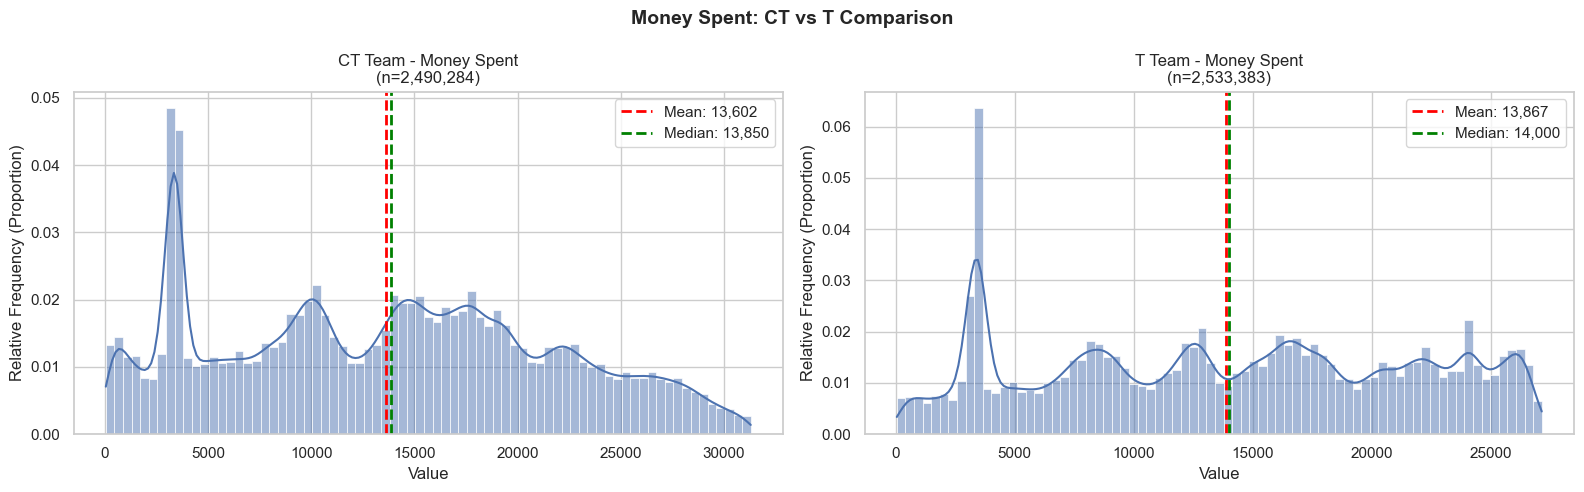

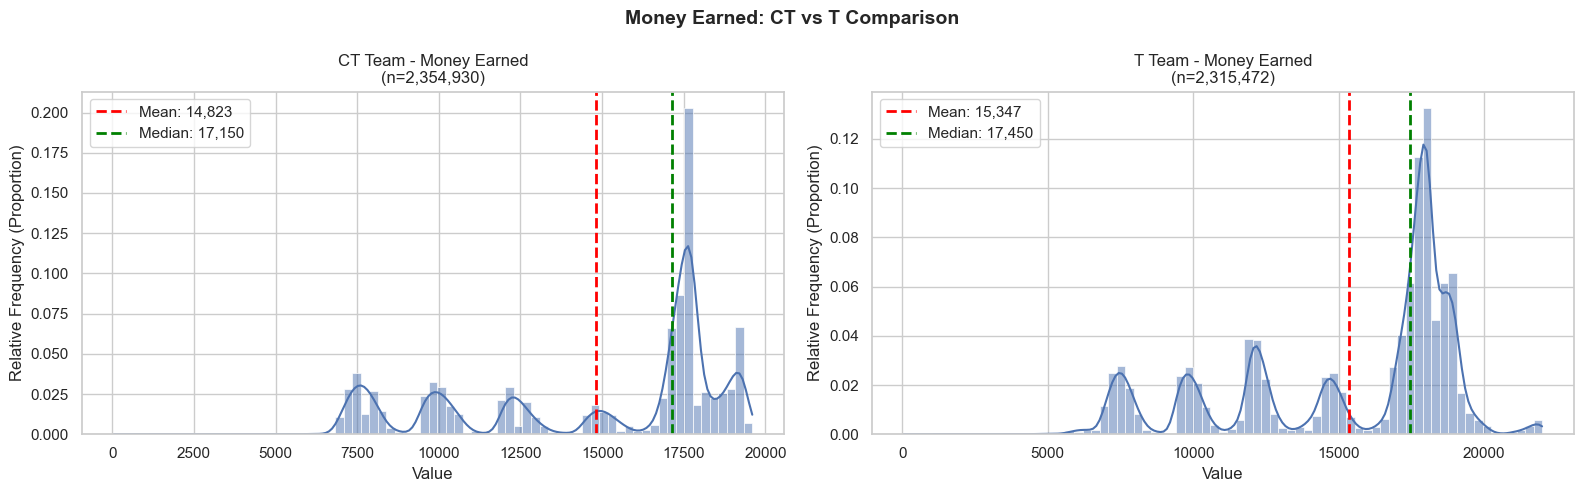

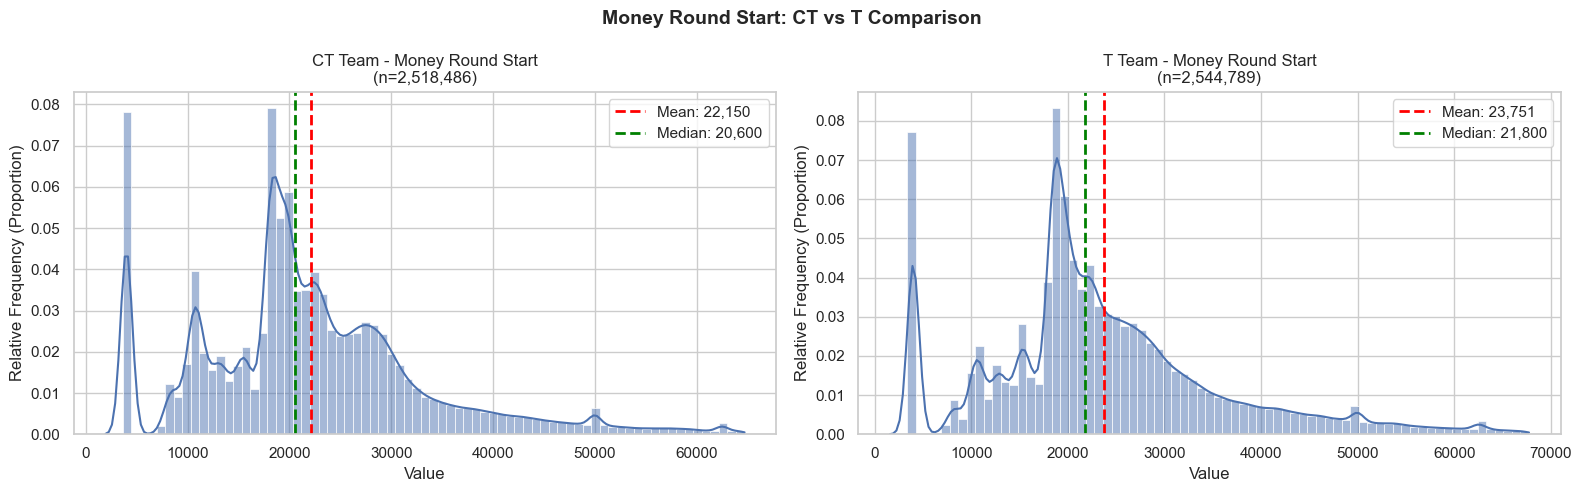

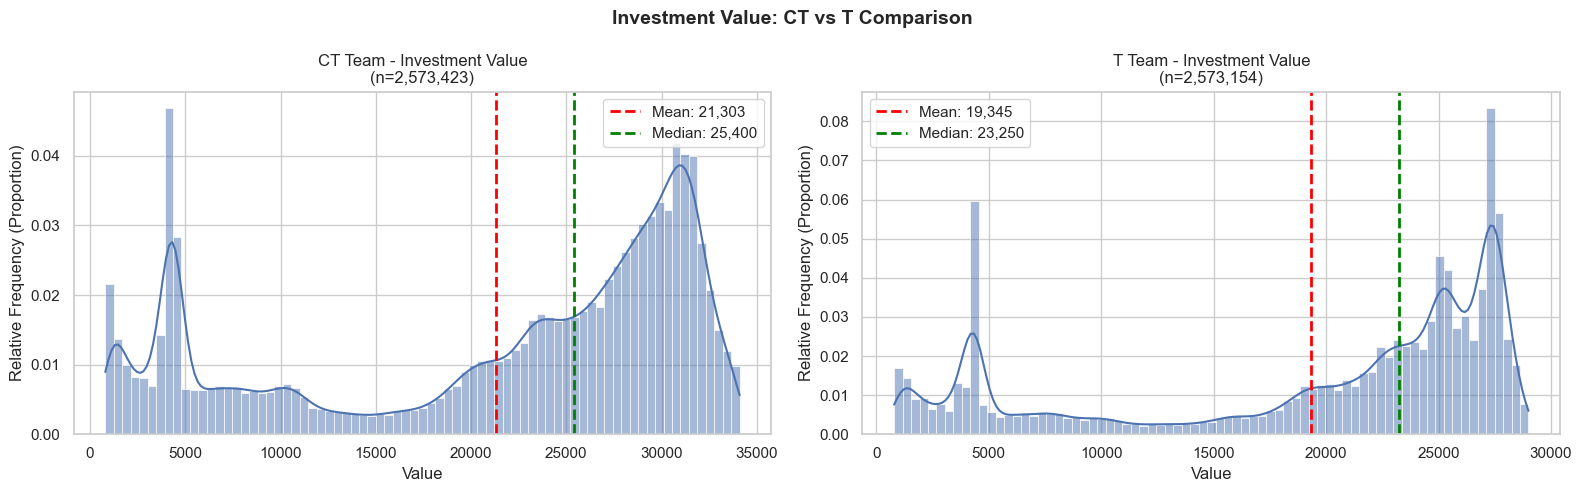

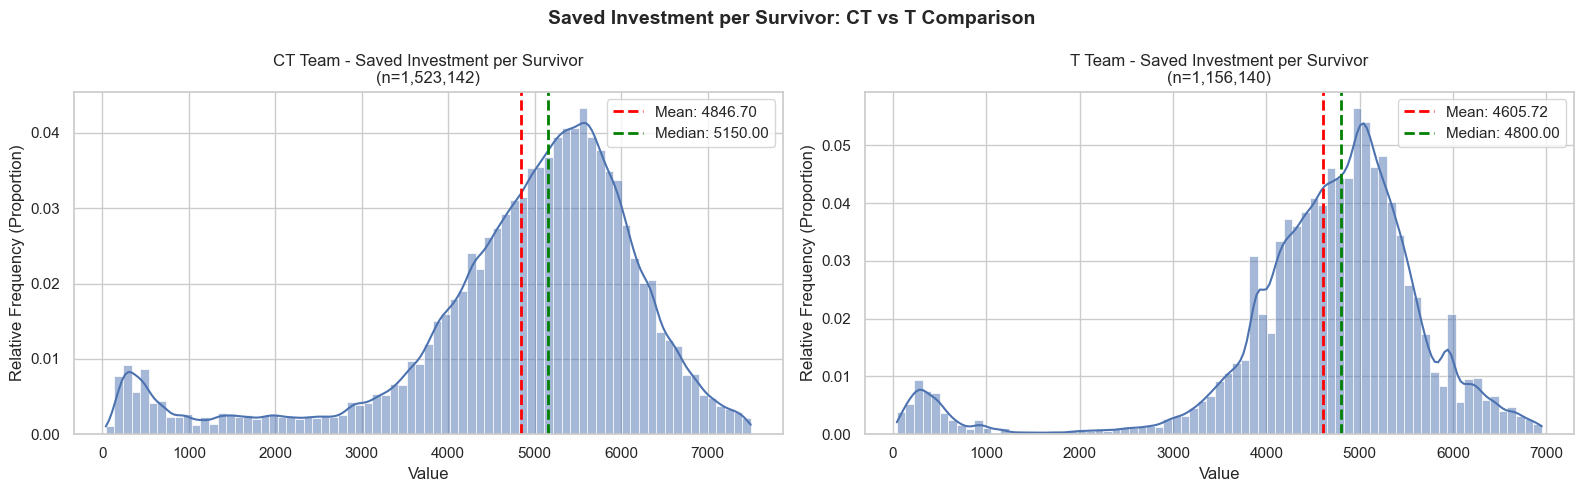

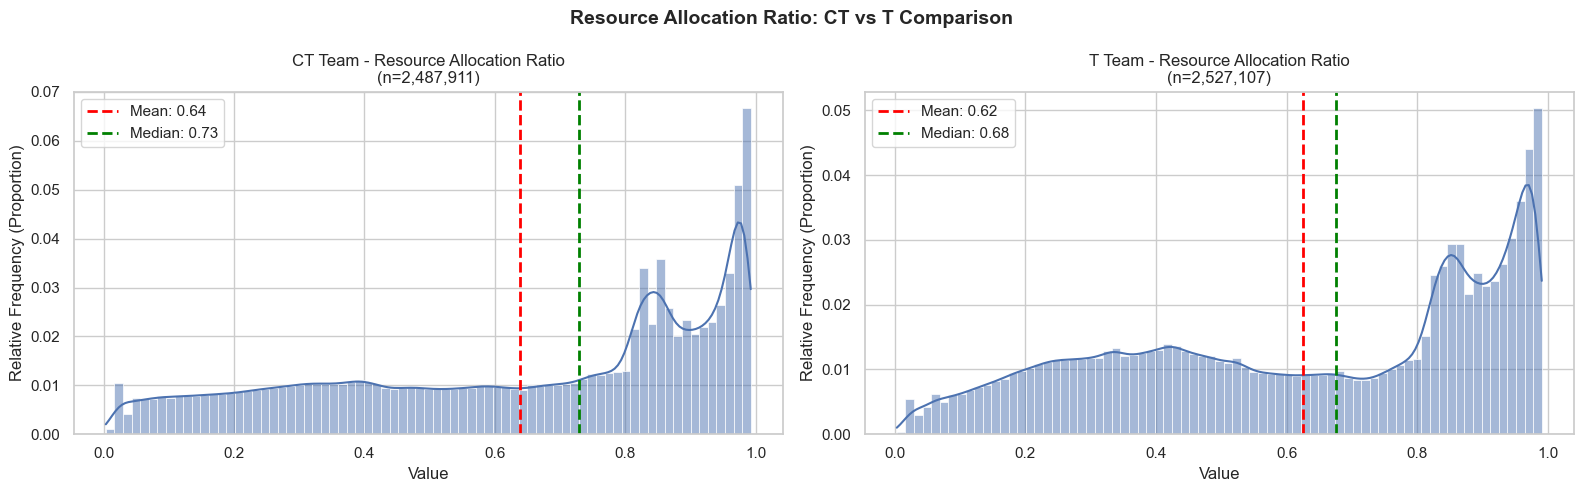

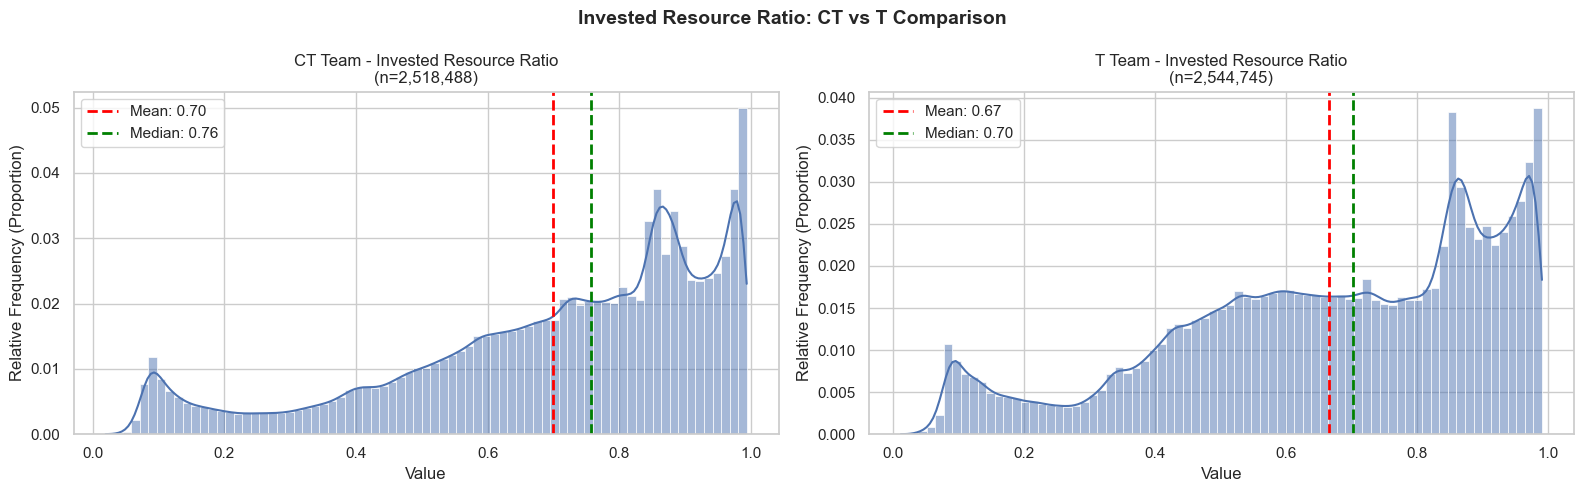

In [10]:
print("="*80)
print("ECONOMY ANALYSIS: CT vs T SIDE-BY-SIDE COMPARISON")
print("="*80)
print()


# Define economy variables for CT and T teams
team_variables = [
    ('ct_money_spent', 't_money_spent', 'Money Spent'),
    ('ct_money_earned', 't_money_earned', 'Money Earned'),
    ('ct_money_start', 't_money_start', 'Money Round Start'),
    ('ct_equipment', 't_equipment', 'Investment Value'),
    ('ct_saved_equipment_ratio', 't_saved_equipment_ratio', 'Saved Investment per Survivor'),
    ('ct_spent_ratio', 't_spent_ratio', 'Resource Allocation Ratio'),
    ('ct_invested_ratio', 't_invested_ratio', 'Invested Resource Ratio'),
]

# Create side-by-side comparisons for CT vs T
for ct_var, t_var, label in team_variables:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    fig.suptitle(f'{label}: CT vs T Comparison', fontsize=14, fontweight='bold')
    
    # CT Team Data
    ct_clean = economy_df[ct_var].dropna()
    ct_clean = ct_clean[ct_clean > 0]
    if len(ct_clean) > 0:
        q99 = np.percentile(ct_clean, 99)
        ct_viz = ct_clean[ct_clean <= q99]
        
        # Use seaborn histogram with stat='probability' for relative frequencies
        sns.histplot(ct_viz, bins=75, kde=True, stat='probability', ax=axes[0])
        ct_mean = ct_viz.mean()
        ct_median = ct_viz.median()
        ct_mean_label = f'{ct_mean:.2f}' if 'ratio' in ct_var else f'{ct_mean:,.0f}'
        ct_median_label = f'{ct_median:.2f}' if 'ratio' in ct_var else f'{ct_median:,.0f}'
        axes[0].axvline(ct_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {ct_mean_label}')
        axes[0].axvline(ct_median, color='green', linestyle='--', linewidth=2, label=f'Median: {ct_median_label}')
        axes[0].set_title(f'CT Team - {label}\n(n={len(ct_viz):,})')
        axes[0].set_xlabel('Value')
        axes[0].set_ylabel('Relative Frequency (Proportion)')
        axes[0].legend()
    else:
        axes[0].text(0.5, 0.5, f'No data for CT {label}', ha='center', va='center')
    
    # T Team Data
    t_clean = economy_df[t_var].dropna()
    t_clean = t_clean[t_clean > 0]
    
    
    if len(t_clean) > 0:
        q99 = np.percentile(t_clean, 99)
        t_viz = t_clean[t_clean <= q99]
        
        # Use seaborn histogram with stat='probability' for relative frequencies
        sns.histplot(t_viz, bins=75, kde=True, stat='probability', ax=axes[1])
        t_mean = t_viz.mean()
        t_median = t_viz.median()
        t_mean_label = f'{t_mean:.2f}' if 'ratio' in t_var else f'{t_mean:,.0f}'
        t_median_label = f'{t_median:.2f}' if 'ratio' in t_var else f'{t_median:,.0f}'
        axes[1].axvline(t_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {t_mean_label}')
        axes[1].axvline(t_median, color='green', linestyle='--', linewidth=2, label=f'Median: {t_median_label}')
        axes[1].set_title(f'T Team - {label}\n(n={len(t_viz):,})')
        axes[1].set_xlabel('Value')
        axes[1].set_ylabel('Relative Frequency (Proportion)')
        axes[1].legend()
    else:
        axes[1].text(0.5, 0.5, f'No data for T {label}', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    





ECONOMY ANALYSIS: COMBINED TEAMS (CT + T)



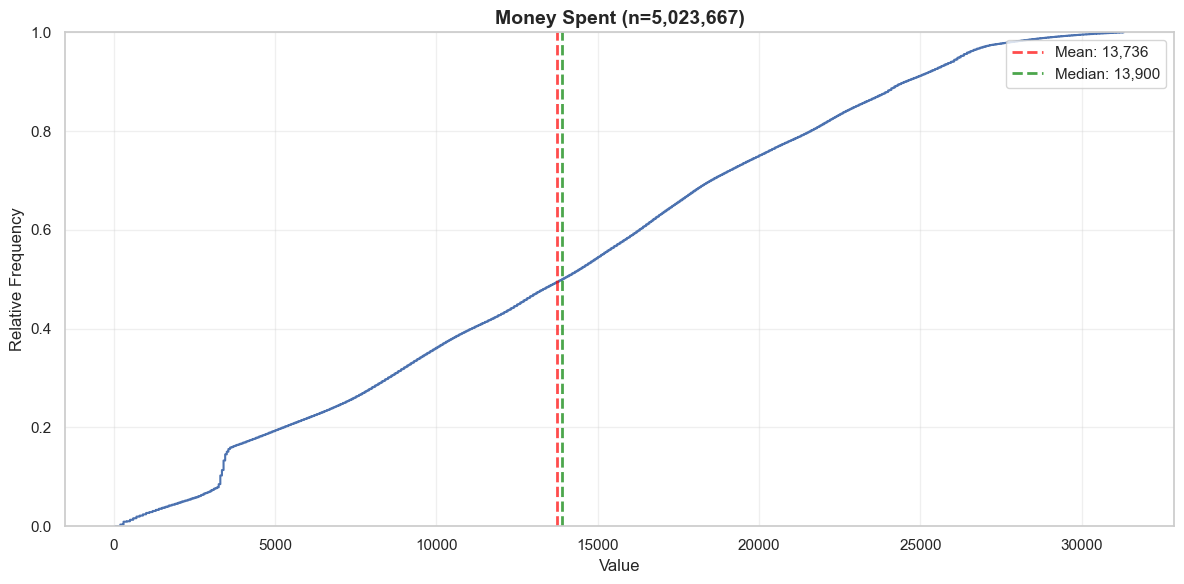

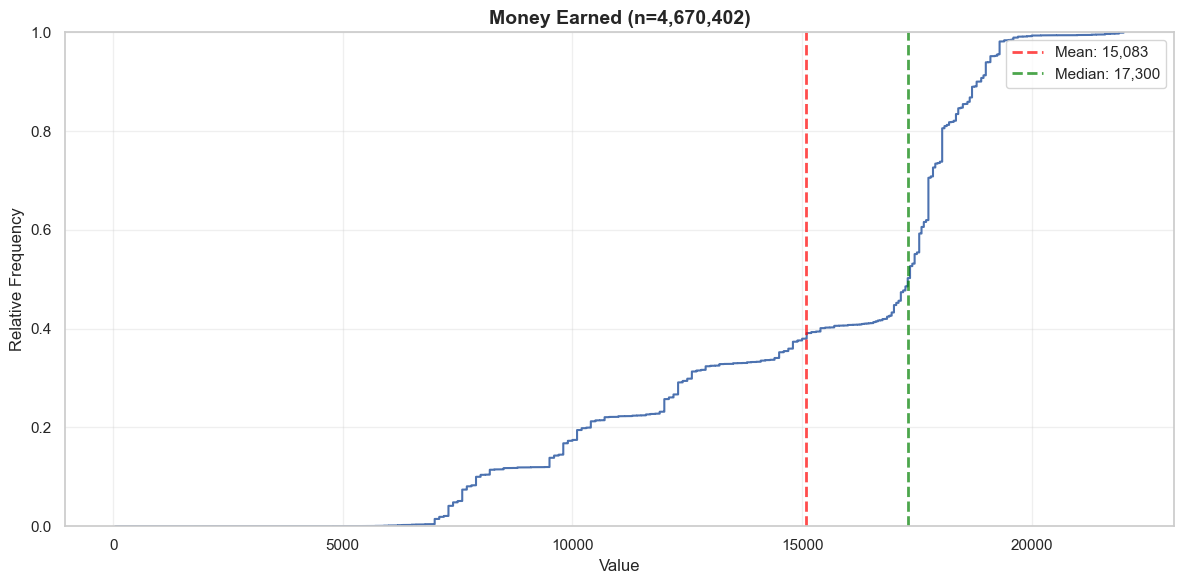

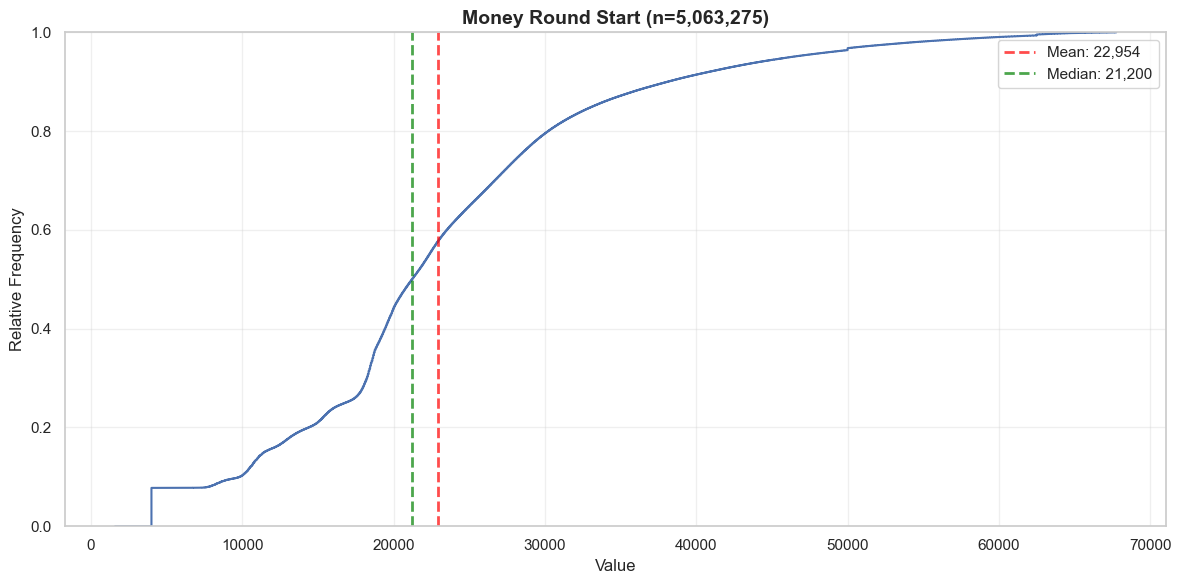

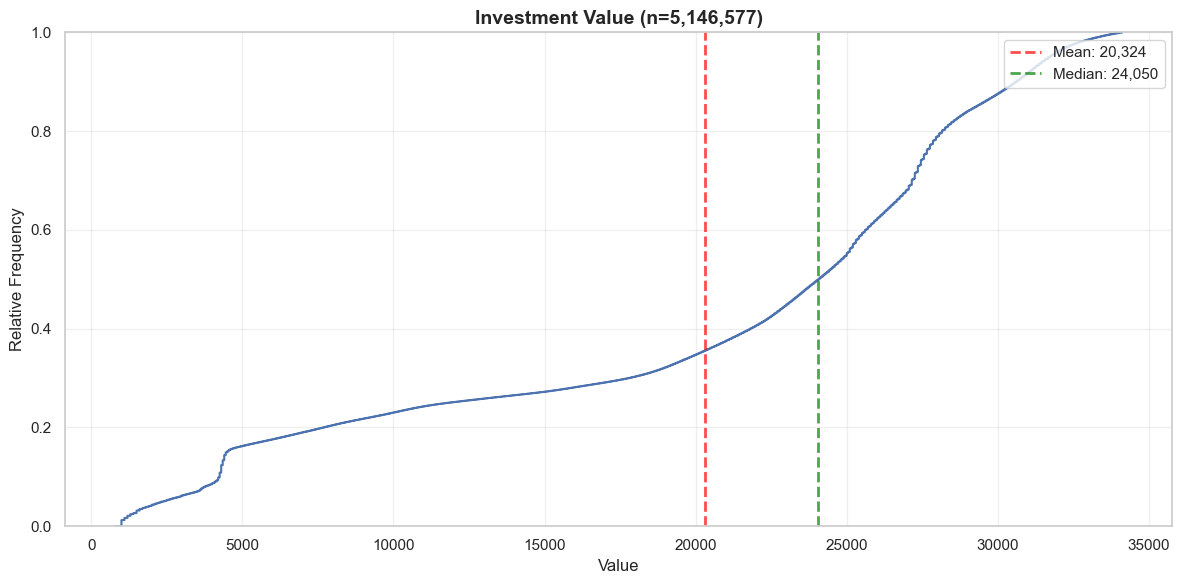

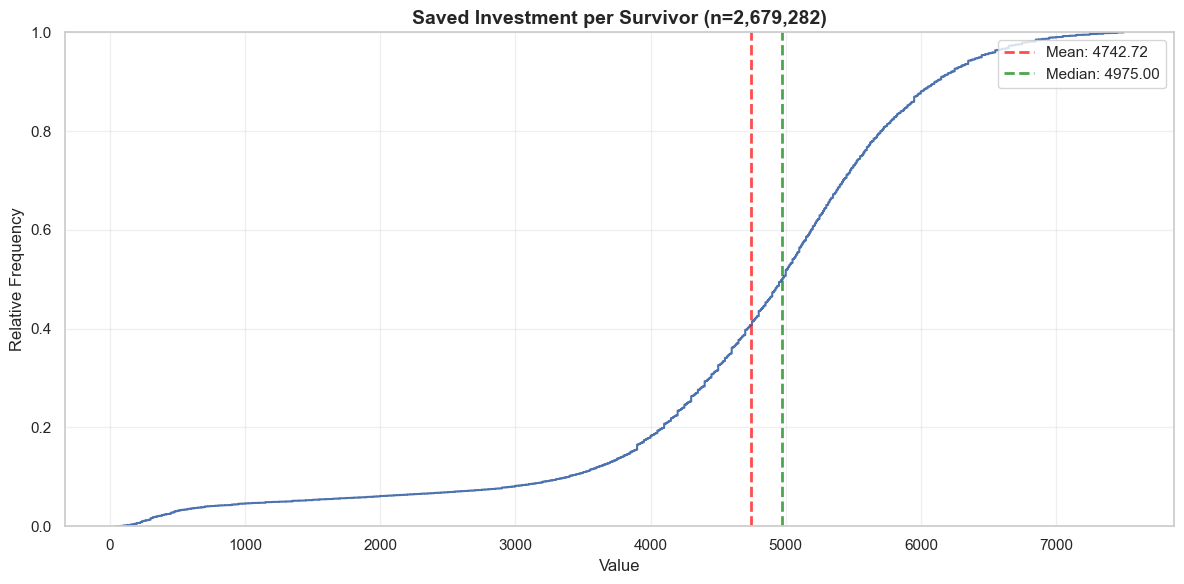

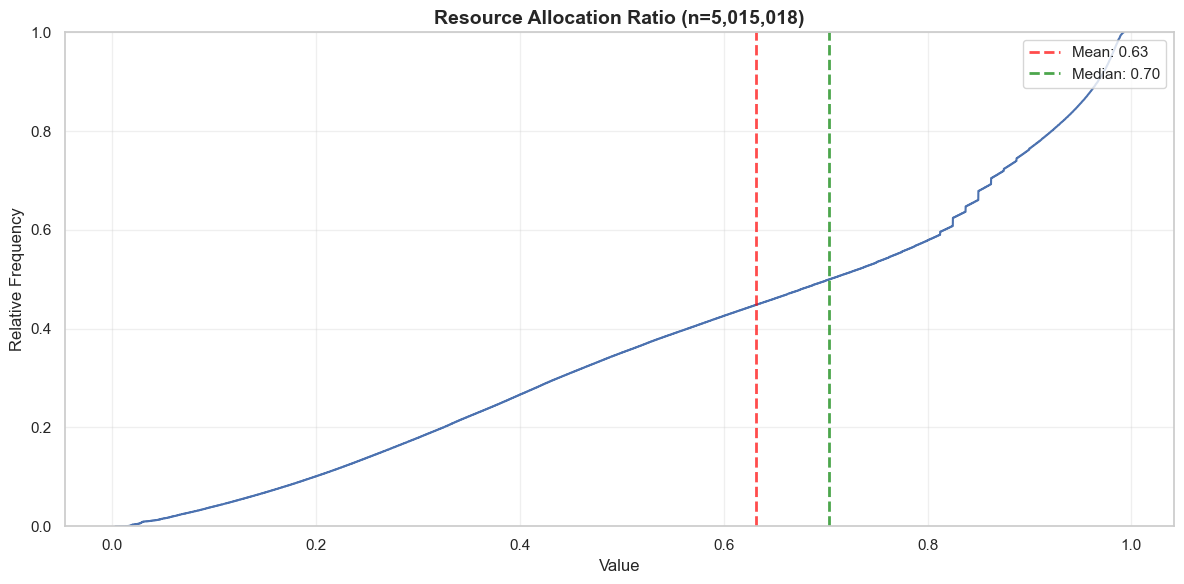

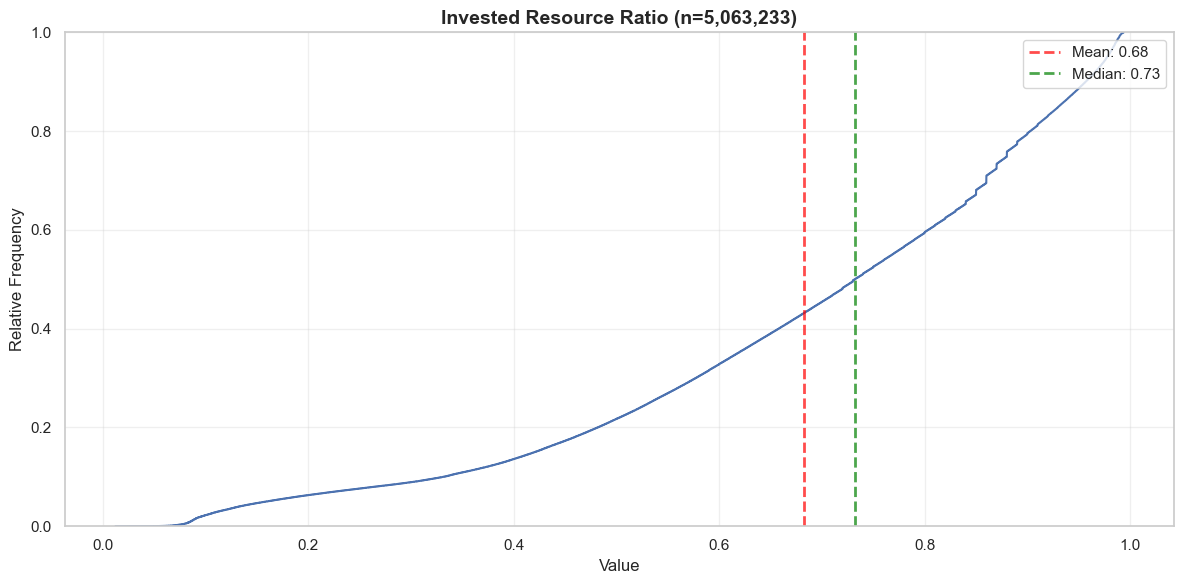

In [11]:
print()
print("="*80)
print("ECONOMY ANALYSIS: COMBINED TEAMS (CT + T)")
print("="*80)
print()

# Create combined overlapping histograms for each variable
for ct_var, t_var, label in team_variables:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # CT Team Data
    ct_clean = economy_df[ct_var].dropna()
    ct_clean = ct_clean[ct_clean > 0]
    
    # T Team Data
    t_clean = economy_df[t_var].dropna()
    t_clean = t_clean[t_clean > 0]

    
    if len(ct_clean) > 0 and len(t_clean) > 0:
        # Apply 99th percentile filter to both
        q99_ct = np.percentile(ct_clean, 99)
        q99_t = np.percentile(t_clean, 99)
        
        ct_viz = ct_clean[ct_clean <= q99_ct]
        t_viz = t_clean[t_clean <= q99_t]
        
        # Combine both teams into single dataset
        combined_data = pd.concat([ct_viz, t_viz])
        
        # Plot combined histogram
        ax.ecdf(combined_data)
        
        # Add statistics for combined data
        combined_mean = combined_data.mean()
        combined_median = combined_data.median()
        
        combined_mean_label = f'{combined_mean:.2f}' if 'ratio' in ct_var else f'{combined_mean:,.0f}'
        combined_median_label = f'{combined_median:.2f}' if 'ratio' in ct_var else f'{combined_median:,.0f}'
        ax.axvline(combined_mean, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Mean: {combined_mean_label}')
        ax.axvline(combined_median, color='green', linestyle='--', linewidth=2, alpha=0.7, label=f'Median: {combined_median_label}')
        
        ax.set_title(f'{label} (n={len(combined_data):,})', fontsize=14, fontweight='bold')
        ax.set_xlabel('Value')
        ax.set_ylabel('Relative Frequency')
        ax.legend(loc='upper right')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

                

COMBINED INVESTMENT METRICS ANALYSIS - CDF



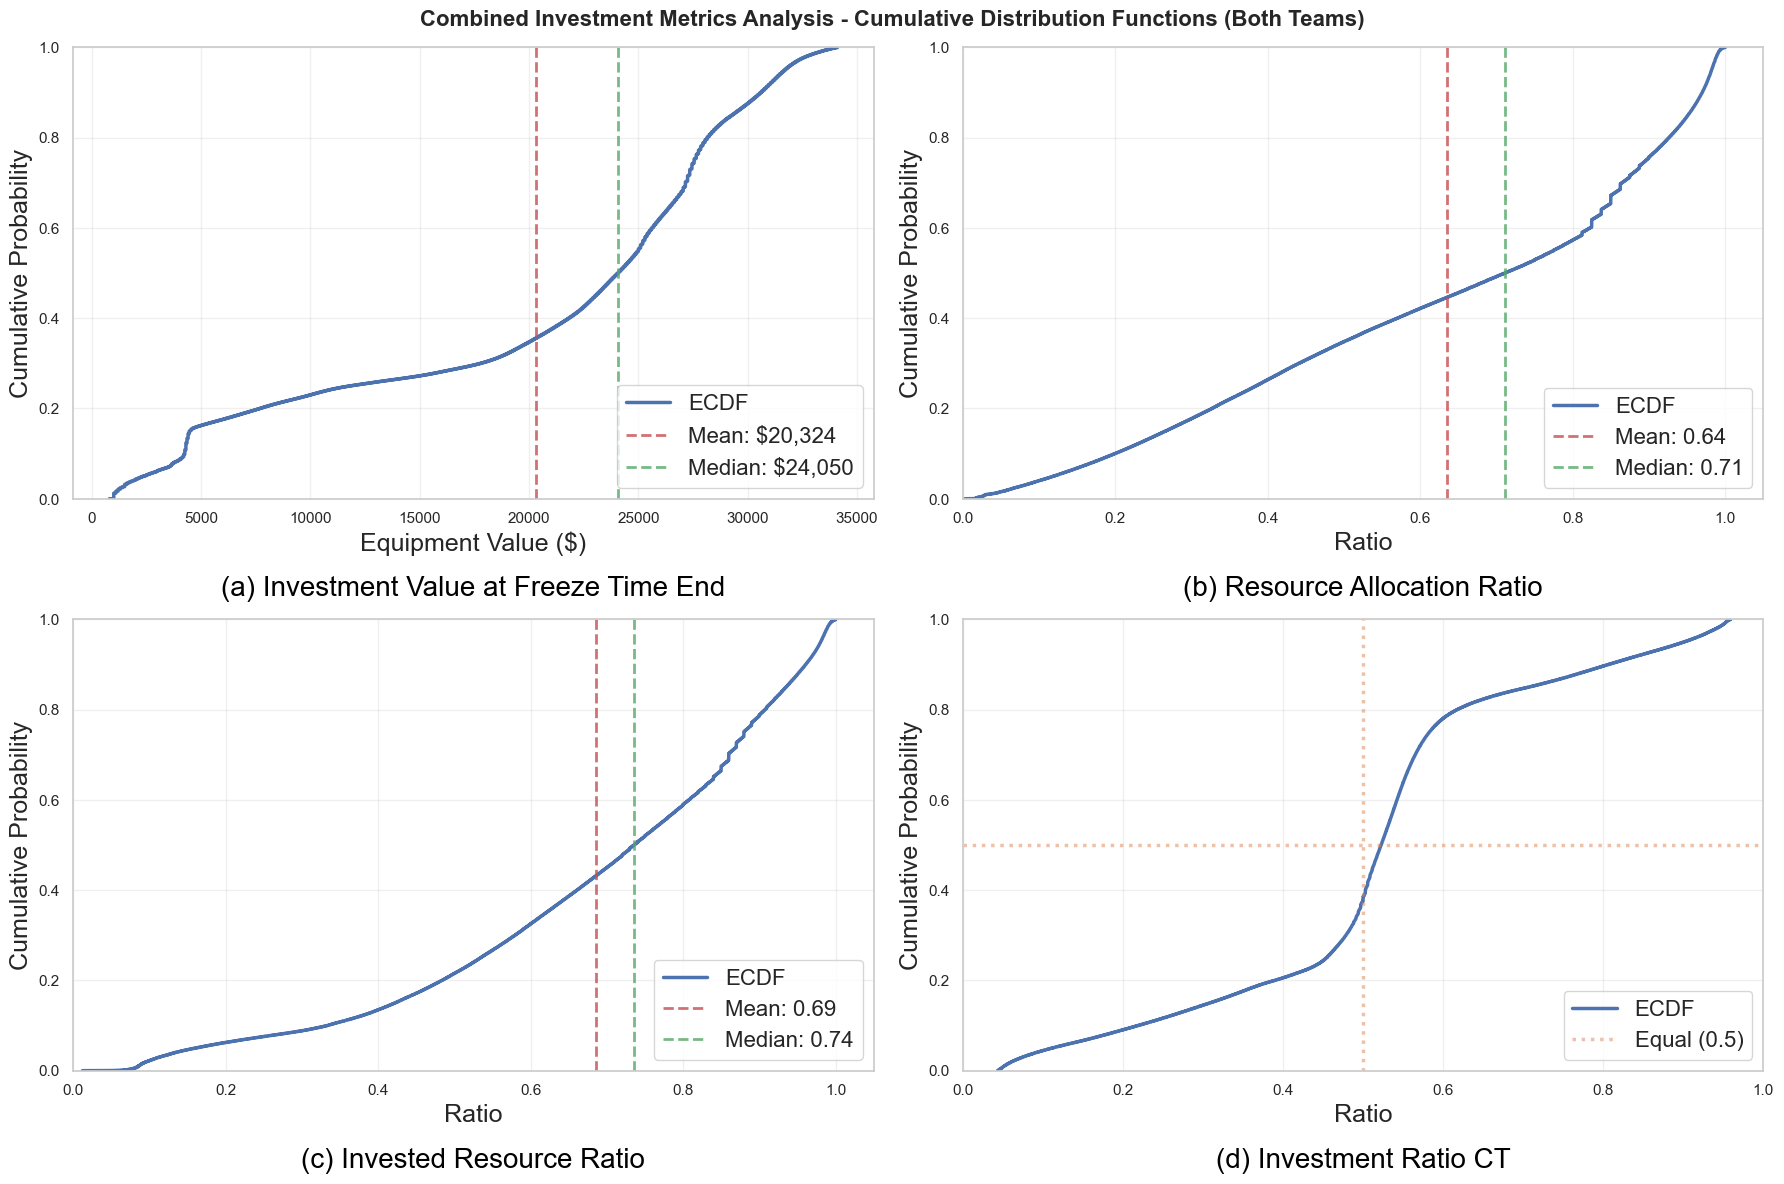

In [12]:
print("="*80)
print("COMBINED INVESTMENT METRICS ANALYSIS - CDF")
print("="*80)
print()

investment_ratio_df = economy_df[['ct_equipment', 't_equipment']].copy()
# Calculate Investment Ratio (CT equipment / (CT + T equipment))
# Filter out rounds where either team has 0 equipment to avoid division by zero
valid_equipment = (investment_ratio_df['ct_equipment'] > 0) & (investment_ratio_df['t_equipment'] > 0)
investment_ratio_df['investment_ratio_ct'] = np.where(
    valid_equipment,
    investment_ratio_df['ct_equipment'] / (investment_ratio_df['ct_equipment'] + investment_ratio_df['t_equipment']),
    np.nan
)


# Create a 2x2 subplot figure for all four metrics
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Combined Investment Metrics Analysis - Cumulative Distribution Functions (Both Teams)', fontsize=16, fontweight='bold')

# ============================================================================
# Plot 1: Investment Value (top-left)
# ============================================================================
ax1 = axes[0, 0]

# Combine CT and T equipment values
ct_equip = economy_df['ct_equipment'].dropna()
ct_equip = ct_equip[ct_equip > 0]
t_equip = economy_df['t_equipment'].dropna()
t_equip = t_equip[t_equip > 0]

if len(ct_equip) > 0 and len(t_equip) > 0:
    # Apply 99th percentile filter
    q99_ct = np.percentile(ct_equip, 99)
    q99_t = np.percentile(t_equip, 99)
    
    ct_viz = ct_equip[ct_equip <= q99_ct]
    t_viz = t_equip[t_equip <= q99_t]
    
    # Combine both teams into single dataset
    combined_equip = pd.concat([ct_viz, t_viz])
    
    # Plot CDF using seaborn
    sns.ecdfplot(data=combined_equip, ax=ax1, label='ECDF', color = "C0", linewidth=2.5)
    
    # Add mean and median lines
    combined_mean = combined_equip.mean()
    combined_median = combined_equip.median()
    ax1.axvline(combined_mean, color="C3", linestyle='--', linewidth=2, alpha=0.8, label=f'Mean: ${combined_mean:,.0f}')
    ax1.axvline(combined_median, color="C2", linestyle='--', linewidth=2, alpha=0.8, label=f'Median: ${combined_median:,.0f}')
    
    ax1.set_title('')
    ax1.set_xlabel('Equipment Value ($)', fontsize=18)
    ax1.set_ylabel('Cumulative Probability', fontsize=18)
    ax1.legend(loc='lower right', fontsize=16)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)

    ax1.text(0.5, -0.20, '(a) Investment Value at Freeze Time End', transform=ax1.transAxes, fontsize=20, color='black', ha="center", va="center", alpha=1)
# ============================================================================
# Plot 2: Resource Allocation Ratio (top-right)
# ============================================================================
ax2 = axes[0, 1]

# Combine CT and T spent ratios
ct_spent = economy_df['ct_spent_ratio'].dropna()
ct_spent = ct_spent[(ct_spent > 0) & (ct_spent <= 1)]
t_spent = economy_df['t_spent_ratio'].dropna()
t_spent = t_spent[(t_spent > 0) & (t_spent <= 1)]

if len(ct_spent) > 0 and len(t_spent) > 0:
    # Combine both teams into single dataset
    combined_spent = pd.concat([ct_spent, t_spent])
    
    # Plot CDF using seaborn
    sns.ecdfplot(data=combined_spent, ax=ax2, label='ECDF', color="C0", linewidth=2.5)
    
    # Add mean and median lines
    combined_mean_spent = combined_spent.mean()
    combined_median_spent = combined_spent.median()
    ax2.axvline(combined_mean_spent, color="C3", linestyle='--', linewidth=2, alpha=0.8, label=f'Mean: {combined_mean_spent:.2f}')
    ax2.axvline(combined_median_spent, color="C2", linestyle='--', linewidth=2, alpha=0.8, label=f'Median: {combined_median_spent:.2f}')
    
    ax2.set_title('')
    ax2.set_xlabel('Ratio', fontsize=18)
    ax2.set_ylabel('Cumulative Probability', fontsize=18)
    ax2.legend(loc='lower right', fontsize=16)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, 1.05)
    ax2.set_ylim(0, 1)

    ax2.text(0.5, -0.20, '(b) Resource Allocation Ratio', transform=ax2.transAxes, fontsize=20, color='black', ha="center", va="center", alpha=1)

# ============================================================================
# Plot 3: Invested Resource Ratio (bottom-left)
# ============================================================================
ax3 = axes[1, 0]

# Combine CT and T invested ratios
ct_invested = economy_df['ct_invested_ratio'].dropna()
ct_invested = ct_invested[(ct_invested > 0) & (ct_invested <= 1)]
t_invested = economy_df['t_invested_ratio'].dropna()
t_invested = t_invested[(t_invested > 0) & (t_invested <= 1)]

if len(ct_invested) > 0 and len(t_invested) > 0:
    # Combine both teams into single dataset
    combined_invested = pd.concat([ct_invested, t_invested])
    
    # Plot CDF using seaborn
    sns.ecdfplot(data=combined_invested, ax=ax3, label='ECDF', color="C0", linewidth=2.5)
    
    # Add mean and median lines
    combined_mean_invested = combined_invested.mean()
    combined_median_invested = combined_invested.median()
    ax3.axvline(combined_mean_invested, color="C3", linestyle='--', linewidth=2, alpha=0.8, label=f'Mean: {combined_mean_invested:.2f}')
    ax3.axvline(combined_median_invested, color="C2", linestyle='--', linewidth=2, alpha=0.8, label=f'Median: {combined_median_invested:.2f}')
    
    ax3.set_title('')
    ax3.set_xlabel('Ratio', fontsize=18)
    ax3.set_ylabel('Cumulative Probability', fontsize=18)
    ax3.legend(loc='lower right', fontsize=16)
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(0, 1.05)
    ax3.set_ylim(0, 1)

    ax3.text(0.5, -0.20, '(c) Invested Resource Ratio', transform=ax3.transAxes, fontsize=20, color='black', ha="center", va="center", alpha=1)

# ============================================================================
# Plot 4: Investment Ratio CT/T (bottom-right)
# ============================================================================
ax4 = axes[1, 1]

# Get CT/T investment ratio
investment_ratio = investment_ratio_df['investment_ratio_ct'].dropna()
investment_ratio = investment_ratio[investment_ratio > 0]

if len(investment_ratio) > 0:
    # Apply reasonable bounds (1st to 99th percentile for visualization)
    q1 = np.percentile(investment_ratio, 1)
    q99 = np.percentile(investment_ratio, 99)
    ratio_viz = investment_ratio[(investment_ratio >= q1) & (investment_ratio <= q99)]
    
    # Plot CDF using seaborn
    sns.ecdfplot(data=ratio_viz, ax=ax4, label='ECDF', color="C0", linewidth=2.5)
    
    # Add key reference lines
    ratio_mean = ratio_viz.mean()
    ratio_median = ratio_viz.median()
    ax4.axvline(0.5, color="C1", linestyle='dotted', linewidth=2.5, label='Equal (0.5)', alpha=0.5)
    ax4.axhline(0.5, color="C1", linestyle='dotted', linewidth=2.5, alpha=0.5)
    
    ax4.set_title('')
    ax4.set_xlabel('Ratio', fontsize=18)
    ax4.set_ylabel('Cumulative Probability', fontsize=18)
    ax4.legend(loc='lower right', fontsize=16)
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(0, 1)
    ax4.set_xlim(0, 1)

    ax4.text(0.5, -0.20, '(d) Investment Ratio CT', transform=ax4.transAxes, fontsize=20, color='black', ha="center", va="center", alpha=1)
    

plt.tight_layout()
plt.show()



INVESTMENT RATIOS BY ROUND NUMBER (Rounds 1-30)

Round 15 Debug:
  Total observations in economy_df for round 15: 98833
  CT spent ratio non-null: 97619
  T spent ratio non-null: 97968
  Combined spent ratio: 195587
  CT invested ratio non-null: 97619
  T invested ratio non-null: 97968
  Combined invested ratio: 195587
  Spent ratio stats: min=0.0000, max=1.0000, mean=0.7367
  Invested ratio stats: min=0.0451, max=1.0000, mean=0.7713



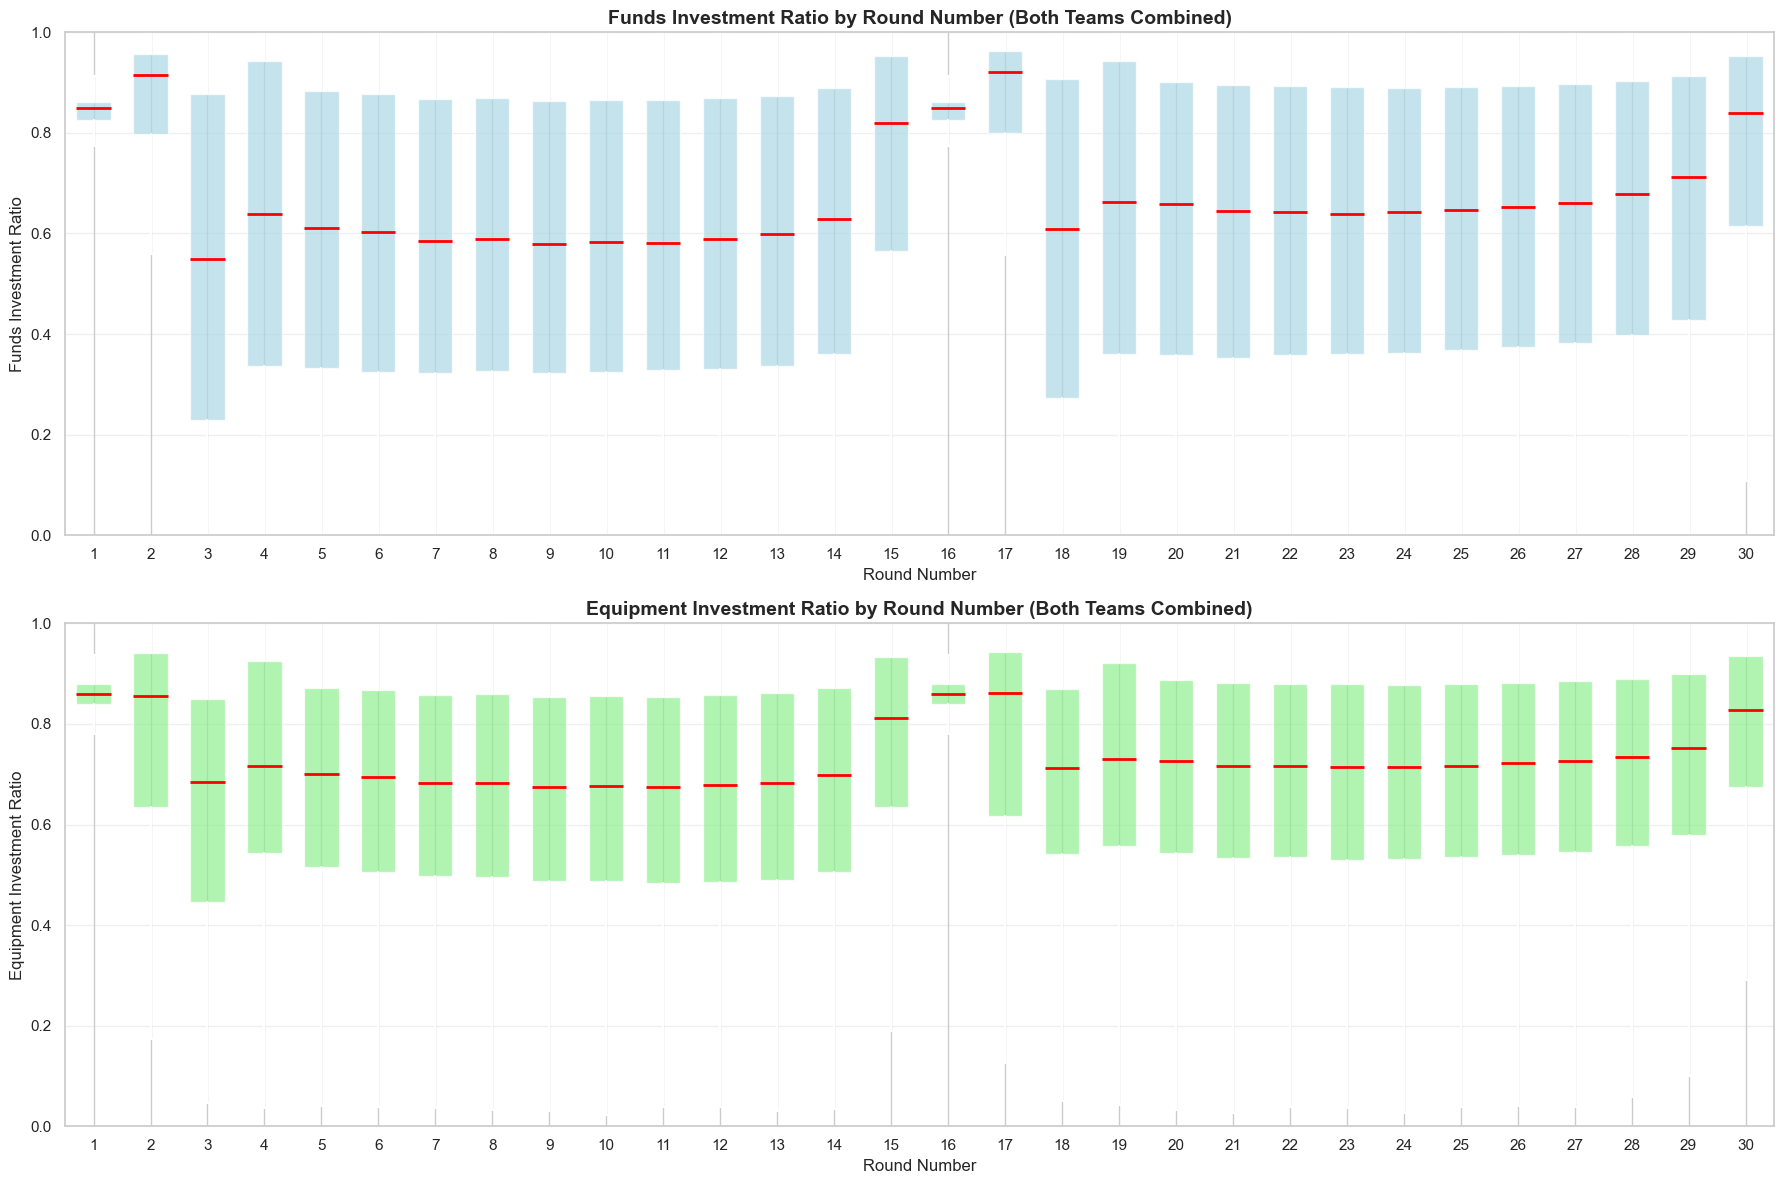

In [13]:
print("="*80)
print("INVESTMENT RATIOS BY ROUND NUMBER (Rounds 1-30)")
print("="*80)
print()

# Filter for rounds 1-30
rounds_filter = (economy_df['round_num'] >= 1) & (economy_df['round_num'] <= 30)
df_rounds = economy_df[rounds_filter].copy()

# Combine CT and T ratios for each metric
spent_ratio_data = []
invested_ratio_data = []

for round_num in range(1, 31):
    round_data = df_rounds[df_rounds['round_num'] == round_num]
    
    # Combine CT and T spent ratios
    ct_spent = round_data['ct_spent_ratio'].dropna()
    t_spent = round_data['t_spent_ratio'].dropna()
    combined_spent = pd.concat([ct_spent, t_spent])
    spent_ratio_data.append(combined_spent)
    
    # Combine CT and T invested ratios
    ct_invested = round_data['ct_invested_ratio'].dropna()
    t_invested = round_data['t_invested_ratio'].dropna()
    combined_invested = pd.concat([ct_invested, t_invested])
    invested_ratio_data.append(combined_invested)
    
    # Debug: Check if round 15 has data
    if round_num == 15:
        print(f"Round 15 Debug:")
        print(f"  Total observations in economy_df for round 15: {len(round_data)}")
        print(f"  CT spent ratio non-null: {len(ct_spent)}")
        print(f"  T spent ratio non-null: {len(t_spent)}")
        print(f"  Combined spent ratio: {len(combined_spent)}")
        print(f"  CT invested ratio non-null: {len(ct_invested)}")
        print(f"  T invested ratio non-null: {len(t_invested)}")
        print(f"  Combined invested ratio: {len(combined_invested)}")
        if len(combined_spent) > 0:
            print(f"  Spent ratio stats: min={combined_spent.min():.4f}, max={combined_spent.max():.4f}, mean={combined_spent.mean():.4f}")
        if len(combined_invested) > 0:
            print(f"  Invested ratio stats: min={combined_invested.min():.4f}, max={combined_invested.max():.4f}, mean={combined_invested.mean():.4f}")
        print()

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12))

# Box plot for Funds Investment Ratio (spent_ratio)
bp1 = ax1.boxplot(spent_ratio_data, 
                   positions=range(1, 31),
                   patch_artist=True,
                   widths=0.6,
                   showfliers=False,  # Hide outliers for cleaner visualization
                   boxprops=dict(facecolor='lightblue', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2),
                   whiskerprops=dict(linewidth=1.5),
                   capprops=dict(linewidth=1.5))

ax1.set_title('Funds Investment Ratio by Round Number (Both Teams Combined)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Round Number', fontsize=12)
ax1.set_ylabel('Funds Investment Ratio', fontsize=12)
ax1.set_xticks(range(1, 31))
ax1.set_xticklabels(range(1, 31))
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, 1)

# Box plot for Equipment Investment Ratio (invested_ratio)
bp2 = ax2.boxplot(invested_ratio_data, 
                   positions=range(1, 31),
                   patch_artist=True,
                   widths=0.6,
                   showfliers=False,  # Hide outliers for cleaner visualization
                   boxprops=dict(facecolor='lightgreen', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2),
                   whiskerprops=dict(linewidth=1.5),
                   capprops=dict(linewidth=1.5))

ax2.set_title('Equipment Investment Ratio by Round Number (Both Teams Combined)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Round Number', fontsize=12)
ax2.set_ylabel('Equipment Investment Ratio', fontsize=12)
ax2.set_xticks(range(1, 31))
ax2.set_xticklabels(range(1, 31))
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

#TODO: potentially add a last round of game analysis on ratios or when 1 team is about to win (scorline 15:x)

In [14]:
#CAUTION: this cell takes about 17min to complete. 
#TODO: optimize this cell

print("="*80)
print("INVESTMENT RATIOS AT CRITICAL SCORELINES (14:x and 15:x)")
print("="*80)
print()

# Filter for non-OT rounds (total score < 30)
economy_df_no_ot = economy_df[(economy_df['t1_score_start'] + economy_df['t2_score_start']) < 30].copy()

# Identify rounds where one team is at 14 or 15
# Case 1: Team 1 has 14, Team 2 has < 14 (Team 1 ahead)
t1_14_ahead = (economy_df_no_ot['t1_score_start'] == 14) & (economy_df_no_ot['t2_score_start'] < 14)

# Case 2: Team 2 has 14, Team 1 has < 14 (Team 2 ahead)
t2_14_ahead = (economy_df_no_ot['t2_score_start'] == 14) & (economy_df_no_ot['t1_score_start'] < 14)

# Case 3: Team 1 has 15, Team 2 has < 15 (Team 1 ahead) - includes 15:14
t1_15_ahead = (economy_df_no_ot['t1_score_start'] == 15) & (economy_df_no_ot['t2_score_start'] < 15)

# Case 4: Team 2 has 15, Team 1 has < 15 (Team 2 ahead) - includes 14:15
t2_15_ahead = (economy_df_no_ot['t2_score_start'] == 15) & (economy_df_no_ot['t1_score_start'] < 15)

# Combine cases for 14:x and 15:x
scoreline_14 = t1_14_ahead | t2_14_ahead
scoreline_15 = t1_15_ahead | t2_15_ahead

print(f"Rounds at 14:x scoreline (leading team has 14): {scoreline_14.sum():,}")
print(f"Rounds at 15:x scoreline (leading team has 15): {scoreline_15.sum():,}")
print()

# Calculate win probability for leading team
# Group by game to determine final winner
def calculate_leading_team_win_rate(df, t1_ahead_mask, t2_ahead_mask):
    """Calculate how often the leading team wins the game"""
    # Get unique games where these scorelines occurred
    t1_ahead_games = df[t1_ahead_mask]['id_demo_exports'].unique()
    t2_ahead_games = df[t2_ahead_mask]['id_demo_exports'].unique()
    
    # For each game, check if Team 1 won (t1_score_end > t2_score_end)
    t1_ahead_wins = 0
    t1_ahead_total = 0
    for game_id in t1_ahead_games:
        game_data = df[df['id_demo_exports'] == game_id].iloc[0]
        # Check final scores - need to get from last round
        final_round = df[df['id_demo_exports'] == game_id].iloc[-1]
        if final_round['t1_score_end'] > final_round['t2_score_end']:
            t1_ahead_wins += 1
        t1_ahead_total += 1
    
    # For Team 2 ahead games
    t2_ahead_wins = 0
    t2_ahead_total = 0
    for game_id in t2_ahead_games:
        final_round = df[df['id_demo_exports'] == game_id].iloc[-1]
        if final_round['t2_score_end'] > final_round['t1_score_end']:
            t2_ahead_wins += 1
        t2_ahead_total += 1
    
    total_wins = t1_ahead_wins + t2_ahead_wins
    total_games = t1_ahead_total + t2_ahead_total
    
    win_rate = (total_wins / total_games * 100) if total_games > 0 else 0
    
    return win_rate, total_wins, total_games

win_rate_14, wins_14, total_14 = calculate_leading_team_win_rate(economy_df_no_ot, t1_14_ahead, t2_14_ahead)
win_rate_15, wins_15, total_15 = calculate_leading_team_win_rate(economy_df_no_ot, t1_15_ahead, t2_15_ahead)

print("Leading Team Win Probability:")
print(f"  At 14:x - {wins_14}/{total_14} games won ({win_rate_14:.2f}%)")
print(f"  At 15:x - {wins_15}/{total_15} games won ({win_rate_15:.2f}%)")
print()

# Extract investment ratios for leading and losing teams
def get_team_ratios(df, t1_ahead_mask, t2_ahead_mask):
    """Extract ratios for both leading and losing teams"""
    leading_spent = []
    leading_invested = []
    losing_spent = []
    losing_invested = []
    
    # Team 1 ahead - Team 1 is leading, Team 2 is losing
    t1_ahead_df = df[t1_ahead_mask]
    leading_spent.extend(t1_ahead_df['t1_spent_ratio'].dropna().tolist())
    leading_invested.extend(t1_ahead_df['t1_invested_ratio'].dropna().tolist())
    losing_spent.extend(t1_ahead_df['t2_spent_ratio'].dropna().tolist())
    losing_invested.extend(t1_ahead_df['t2_invested_ratio'].dropna().tolist())
    
    # Team 2 ahead - Team 2 is leading, Team 1 is losing
    t2_ahead_df = df[t2_ahead_mask]
    leading_spent.extend(t2_ahead_df['t2_spent_ratio'].dropna().tolist())
    leading_invested.extend(t2_ahead_df['t2_invested_ratio'].dropna().tolist())
    losing_spent.extend(t2_ahead_df['t1_spent_ratio'].dropna().tolist())
    losing_invested.extend(t2_ahead_df['t1_invested_ratio'].dropna().tolist())
    
    return leading_spent, leading_invested, losing_spent, losing_invested

# Need to map t1/t2 to CT/T based on is_ct_t1
# Create combined team ratios
economy_df_no_ot['t1_spent_ratio'] = np.where(
    economy_df_no_ot['is_ct_t1'] == True,
    economy_df_no_ot['ct_spent_ratio'],
    economy_df_no_ot['t_spent_ratio']
)
economy_df_no_ot['t1_invested_ratio'] = np.where(
    economy_df_no_ot['is_ct_t1'] == True,
    economy_df_no_ot['ct_invested_ratio'],
    economy_df_no_ot['t_invested_ratio']
)
economy_df_no_ot['t2_spent_ratio'] = np.where(
    economy_df_no_ot['is_ct_t1'] == True,
    economy_df_no_ot['t_spent_ratio'],
    economy_df_no_ot['ct_spent_ratio']
)
economy_df_no_ot['t2_invested_ratio'] = np.where(
    economy_df_no_ot['is_ct_t1'] == True,
    economy_df_no_ot['t_invested_ratio'],
    economy_df_no_ot['ct_invested_ratio']
)

# Get ratios for leading and losing teams at each scoreline
leading_spent_14, leading_invested_14, losing_spent_14, losing_invested_14 = get_team_ratios(economy_df_no_ot, t1_14_ahead, t2_14_ahead)
leading_spent_15, leading_invested_15, losing_spent_15, losing_invested_15 = get_team_ratios(economy_df_no_ot, t1_15_ahead, t2_15_ahead)

print(f"Valid observations at 14:x scoreline:")
print(f"  Leading Team - Funds Ratio: {len(leading_spent_14):,}, Equipment Ratio: {len(leading_invested_14):,}")
print(f"  Losing Team  - Funds Ratio: {len(losing_spent_14):,}, Equipment Ratio: {len(losing_invested_14):,}")
print()

print(f"Valid observations at 15:x scoreline:")
print(f"  Leading Team - Funds Ratio: {len(leading_spent_15):,}, Equipment Ratio: {len(leading_invested_15):,}")
print(f"  Losing Team  - Funds Ratio: {len(losing_spent_15):,}, Equipment Ratio: {len(losing_invested_15):,}")
print()

# ============================================================================
# FIGURE 1: SCORELINE 14:x (Leading vs Losing Team)
# ============================================================================

#TODO: fix figures

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig1.suptitle('Allocation Ratios at Scoreline 14:x (Leading vs Losing Team)', fontsize=16, fontweight='bold')

# Resource Allocation Ratio at 14:x
bp1 = ax1.boxplot([leading_spent_14, losing_spent_14],
                   labels=['Leading Team', 'Losing Team'],
                   patch_artist=True,
                   widths=0.6,
                   showfliers=True,
                   medianprops=dict(color='red', linewidth=2),
                   whiskerprops=dict(linewidth=1.5),
                   capprops=dict(linewidth=1.5),
                   flierprops=dict(marker='o', markerfacecolor='gray', markersize=3, alpha=0.3))

ax1.set_title('Resource Allocation Ratio at 14:x', fontsize=14, fontweight='bold')
ax1.set_ylabel('Ratio', fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, 1.05)

# Add sample sizes
ax1.text(1, -0.08, f'n={len(leading_spent_14):,}', ha='center', transform=ax1.get_xaxis_transform(), fontsize=10)
ax1.text(2, -0.08, f'n={len(losing_spent_14):,}', ha='center', transform=ax1.get_xaxis_transform(), fontsize=10)

# Invested Resource Ratio at 14:x
bp2 = ax2.boxplot([leading_invested_14, losing_invested_14],
                   labels=['Leading Team', 'Losing Team'],
                   patch_artist=True,
                   widths=0.6,
                   showfliers=True,
                   medianprops=dict(color='red', linewidth=2),
                   whiskerprops=dict(linewidth=1.5),
                   capprops=dict(linewidth=1.5),
                   flierprops=dict(marker='o', markerfacecolor='gray', markersize=3, alpha=0.3))

ax2.set_title('Invested Resource Ratio at 14:x', fontsize=14, fontweight='bold')
ax2.set_ylabel('Ratio', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, 1.05)

# Add sample sizes
ax2.text(1, -0.08, f'n={len(leading_invested_14):,}', ha='center', transform=ax2.get_xaxis_transform(), fontsize=10)
ax2.text(2, -0.08, f'n={len(losing_invested_14):,}', ha='center', transform=ax2.get_xaxis_transform(), fontsize=10)

plt.tight_layout()
plt.show()

# ============================================================================
# FIGURE 2: SCORELINE 15:x (Leading vs Losing Team)
# ============================================================================
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(16, 7))
fig2.suptitle('Allocation Ratios at Scoreline 15:x (Leading vs Losing Team)', fontsize=16, fontweight='bold')

# Resource Allocation Ratio at 15:x
bp3 = ax3.boxplot([leading_spent_15, losing_spent_15],
                   labels=['Leading Team', 'Losing Team'],
                   patch_artist=True,
                   widths=0.6,
                   showfliers=True,
                   medianprops=dict(color='red', linewidth=2),
                   whiskerprops=dict(linewidth=1.5),
                   capprops=dict(linewidth=1.5),
                   flierprops=dict(marker='o', markerfacecolor='gray', markersize=3, alpha=0.3))

ax3.set_title('Resource Allocation Ratio at 15:x', fontsize=14, fontweight='bold')
ax3.set_ylabel('Ratio', fontsize=12)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim(0, 1.05)

# Add sample sizes
ax3.text(1, -0.08, f'n={len(leading_spent_15):,}', ha='center', transform=ax3.get_xaxis_transform(), fontsize=10)
ax3.text(2, -0.08, f'n={len(losing_spent_15):,}', ha='center', transform=ax3.get_xaxis_transform(), fontsize=10)

# Invested Resource Ratio at 15:x
bp4 = ax4.boxplot([leading_invested_15, losing_invested_15],
                   labels=['Leading Team', 'Losing Team'],
                   patch_artist=True,
                   widths=0.6,
                   showfliers=True,
                   medianprops=dict(color='red', linewidth=2),
                   whiskerprops=dict(linewidth=1.5),
                   capprops=dict(linewidth=1.5),
                   flierprops=dict(marker='o', markerfacecolor='gray', markersize=3, alpha=0.3))

ax4.set_title('Invested Resource Ratio at 15:x', fontsize=14, fontweight='bold')
ax4.set_ylabel('Ratio', fontsize=12)
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_ylim(0, 1.05)

# Add sample sizes
ax4.text(0.5, -0.18, f'(d) Invested Resource Ratio at 15:x', ha='center', transform=ax4.get_xaxis_transform(), fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()



INVESTMENT RATIOS AT CRITICAL SCORELINES (14:x and 15:x)

Rounds at 14:x scoreline (leading team has 14): 169,025
Rounds at 15:x scoreline (leading team has 15): 172,040



KeyboardInterrupt: 

ROUND END REASON DISTRIBUTION



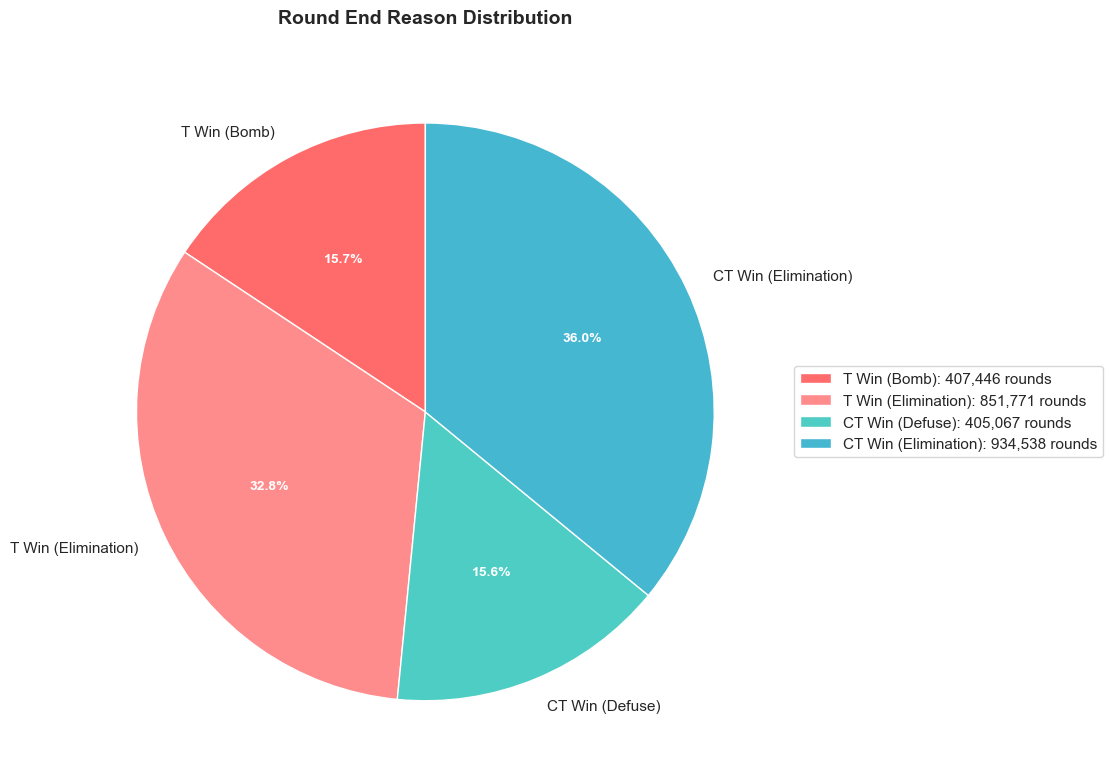

Round End Reason Statistics:
--------------------------------------------------------------------------------
  T Win (Bomb)                  :    407,446 rounds ( 15.7%)
  T Win (Elimination)           :    851,771 rounds ( 32.8%)
  CT Win (Defuse)               :    405,067 rounds ( 15.6%)
  CT Win (Elimination)          :    934,538 rounds ( 36.0%)

Total Rounds: 2,598,822


In [ ]:
print("="*80)
print("ROUND END REASON DISTRIBUTION")
print("="*80)
print()

# Define reason labels
reason_labels = {
    1: 'T Win (Bomb)',
    2: 'T Win (Elimination)',
    3: 'CT Win (Defuse)',
    4: 'CT Win (Elimination)'
}

# Count round end reasons
reason_counts = detailed_df['round_end_reason'].value_counts().sort_index()
reason_names = [reason_labels[r] for r in reason_counts.index]

# Create pie chart
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#ff6b6b', '#ff8c8c', '#4ecdc4', '#45b7d1']
wedges, texts, autotexts = ax.pie(reason_counts, 
                                    labels=reason_names, 
                                    autopct='%1.1f%%',
                                    colors=colors,
                                    startangle=90,
                                    textprops={'fontsize': 11})

# Enhance text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

ax.set_title('Round End Reason Distribution', fontsize=14, fontweight='bold', pad=20)

# Add legend with counts
legend_labels = [f'{reason_names[i]}: {reason_counts.iloc[i]:,} rounds' 
                 for i in range(len(reason_names))]
ax.legend(legend_labels, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

# Print statistics
print("Round End Reason Statistics:")
print("-"*80)
for reason_id in sorted(reason_counts.index):
    count = reason_counts[reason_id]
    pct = (count / reason_counts.sum()) * 100
    print(f"  {reason_labels[reason_id]:30s}: {count:>10,} rounds ({pct:>5.1f}%)")

print()
print(f"Total Rounds: {reason_counts.sum():,}")
print("="*80)

98937  games found for scoreline analysis

Game Length and Scoreline Analysis
Overall canonical scorelines (winner:loser):
       total_rounds  count    pct  cumulative_pct
canon                                            
16:0             16     44   0.04            0.04
16:1             17   1183   1.20            1.24
16:2             18   2267   2.29            3.53
16:3             19   3122   3.16            6.69
16:4             20   4135   4.18           10.87
16:5             21   5167   5.22           16.09
16:6             22   6305   6.37           22.46
16:7             23   6890   6.96           29.42
16:8             24   7693   7.78           37.20
16:9             25   8101   8.19           45.39
16:10            26   8411   8.50           53.89
16:11            27   8692   8.79           62.68
16:12            28   8874   8.97           71.65
16:13            29   8917   9.01           80.66
16:14            30   9952  10.06           90.72
19:15            34   1359 

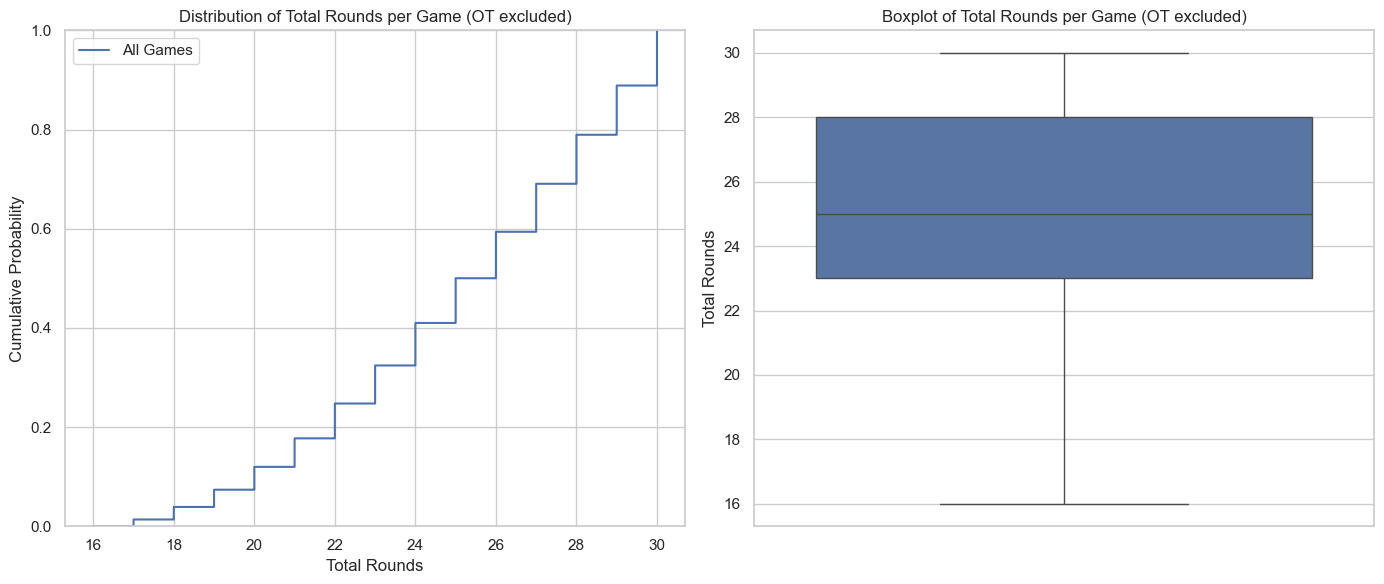

In [ ]:


scores = (
    detailed_df.sort_values(['id_demo_exports', 'round_num'])
    .groupby('id_demo_exports')
    .agg(t1_final=('t1_score_end', 'last'), t2_final=('t2_score_end', 'last'))
    .reset_index()
).copy()



# Prepare helpers
scores['total_rounds'] = scores['t1_final'] + scores['t2_final']
scores['higher'] = scores[['t1_final', 't2_final']].max(axis=1)
scores['lower'] = scores[['t1_final', 't2_final']].min(axis=1)
scores['canon'] = scores['higher'].astype(int).astype(str) + ':' + scores['lower'].astype(int).astype(str)  # e.g., "16:14"
t1_won_mask = scores['t1_final'] > scores['t2_final']
t2_won_mask = ~t1_won_mask


# 2) Overall canonical scorelines (treat 16:14 = 14:16)
canon_overall = (
    scores.groupby(['higher', 'lower', 'canon'])
    .size()
    .reset_index(name='count')
)

#We keep them in the data analysis because when looking at the individual rounds, they are still valuable
#Exclude ties like 15:15, these are rare exceptions. 
canon_overall = canon_overall[canon_overall['higher'] != canon_overall['lower']]  


print(len(scores), " games found for scoreline analysis")

canon_overall['total_rounds'] = canon_overall['higher'] + canon_overall['lower']
canon_overall['pct'] = (canon_overall['count'] / len(scores) * 100).round(2)
canon_overall = canon_overall.sort_values(['total_rounds', 'higher', 'lower']).set_index('canon')[['count', 'pct', 'total_rounds']]


canon_overall['cumulative_pct'] = canon_overall['pct'].cumsum()


# Display

print(f"""
Game Length and Scoreline Analysis
Overall canonical scorelines (winner:loser):
{canon_overall[['total_rounds','count', 'pct', 'cumulative_pct']].to_string()}""")

# Final game outcomes
game_scores = detailed_df.groupby('id_demo_exports')[['t1_score_end','t2_score_end', 'team1_winner', 'round_num']].agg({'t1_score_end': 'max', 't2_score_end': 'max', 'team1_winner': 'last', 'round_num': 'max'}).copy()
t1_overall_win = set(game_scores[game_scores['t1_score_end'] > game_scores['t2_score_end']].index)
t2_overall_win = set(game_scores[game_scores['t2_score_end'] > game_scores['t1_score_end']].index)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ECDF plot using seaborn
ax1.title.set_text('Distribution of Total Rounds per Game (OT excluded)')
sns.ecdfplot(data=scores[scores['total_rounds'] < 31], x='total_rounds', label='All Games', ax=ax1)
ax1.set_xlabel('Total Rounds')
ax1.set_ylabel('Cumulative Probability')
ax1.legend()

# Boxplot using seaborn
sns.boxplot(
    y=scores[scores['total_rounds'] < 31]['total_rounds'],
    ax=ax2
)
ax2.set_title('Boxplot of Total Rounds per Game (OT excluded)')
ax2.set_ylabel('Total Rounds')




plt.tight_layout()
plt.show()



C:\Users\peter\AppData\Local\Temp\ipykernel_8452\503914743.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=16)


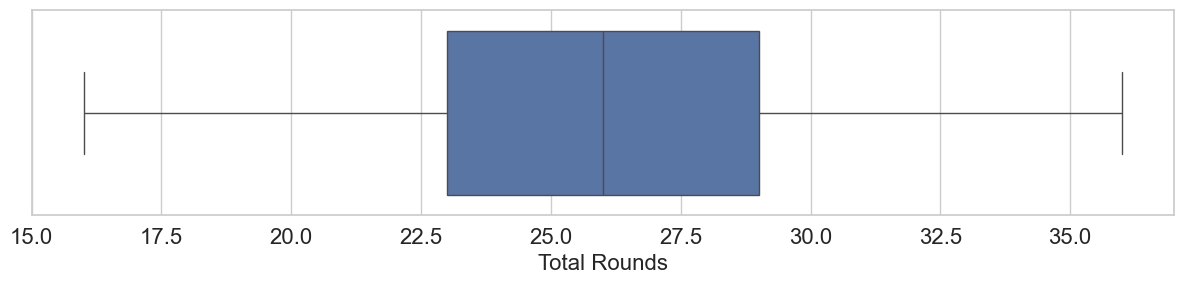

In [ ]:

fig, ax= plt.subplots(1, 1, figsize=(12, 3))

# Boxplot using seaborn
sns.boxplot(
    x=scores['total_rounds'],
    ax=ax,
    showfliers=False,
    color="C0"
)
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=16)
ax.set_xlabel('Total Rounds',fontsize=16)

plt.tight_layout()
plt.show()

In [ ]:
# Descriptive statistics on scorelines
print("="*80)
print("SCORELINE DESCRIPTIVE STATISTICS")
print("="*80)
print()

# Get final scores for each game - sort by round_num first to ensure we get the last round
game_scores = detailed_df.sort_values(['id_demo_exports', 'round_num']).groupby('id_demo_exports').agg({
    't1_score_end': 'last',
    't2_score_end': 'last',
    'team1_winner': 'last',
    'round_num': 'last'
}).reset_index()

# Calculate score differences
game_scores['score_diff'] = abs(game_scores['t1_score_end'] - game_scores['t2_score_end'])
game_scores['total_rounds'] = game_scores['t1_score_end'] + game_scores['t2_score_end']

# Calculate statistics for winner's score
winner_scores = []
loser_scores = []
for _, row in game_scores.iterrows():
    if row['t1_score_end'] > row['t2_score_end']:
        winner_scores.append(row['t1_score_end'])
        loser_scores.append(row['t2_score_end'])
    else:
        winner_scores.append(row['t2_score_end'])
        loser_scores.append(row['t1_score_end'])

winner_scores = pd.Series(winner_scores)
loser_scores = pd.Series(loser_scores)

print(f"Total Games: {len(game_scores):,}")
print()

print("Winner's Final Scores:")
print(f"  Mean:   {winner_scores.mean():.2f}")
print(f"  Median: {winner_scores.median():.0f}")
print(f"  Std:    {winner_scores.std():.2f}")
print(f"  Min:    {winner_scores.min():.0f}")
print(f"  Max:    {winner_scores.max():.0f}")
print()

print("Loser's Final Scores:")
print(f"  Mean:   {loser_scores.mean():.2f}")
print(f"  Median: {loser_scores.median():.0f}")
print(f"  Std:    {loser_scores.std():.2f}")
print(f"  Min:    {loser_scores.min():.0f}")
print(f"  Max:    {loser_scores.max():.0f}")
print()

print("Score Difference (Winner - Loser):")
print(f"  Mean:   {game_scores['score_diff'].mean():.2f}")
print(f"  Median: {game_scores['score_diff'].median():.0f}")
print(f"  Std:    {game_scores['score_diff'].std():.2f}")
print(f"  Min:    {game_scores['score_diff'].min():.0f}")
print(f"  Max:    {game_scores['score_diff'].max():.0f}")
print()

print("Total Rounds Per Game:")
print(f"  Mean:   {game_scores['total_rounds'].mean():.2f}")
print(f"  Median: {game_scores['total_rounds'].median():.0f}")
print(f"  Std:    {game_scores['total_rounds'].std():.2f}")
print(f"  Min:    {game_scores['total_rounds'].min():.0f}")
print(f"  Max:    {game_scores['total_rounds'].max():.0f}")
print()

# Close games (score diff <= 3)
close_games = game_scores[game_scores['score_diff'] <= 3]
print(f"Close Games (score difference ≤ 3): {len(close_games):,} ({len(close_games)/len(game_scores)*100:.1f}%)")
print()

# Overtime games (total rounds > 30)
ot_games = game_scores[game_scores['total_rounds'] > 30]
print(f"Overtime Games (>30 rounds): {len(ot_games):,} ({len(ot_games)/len(game_scores)*100:.1f}%)")
print()


SCORELINE DESCRIPTIVE STATISTICS

Total Games: 98,937

Winner's Final Scores:
  Mean:   16.39
  Median: 16
  Std:    1.42
  Min:    15
  Max:    40

Loser's Final Scores:
  Mean:   9.90
  Median: 10
  Std:    4.18
  Min:    0
  Max:    38

Score Difference (Winner - Loser):
  Mean:   6.49
  Median: 6
  Std:    3.54
  Min:    0
  Max:    16

Total Rounds Per Game:
  Mean:   26.30
  Median: 26
  Std:    5.14
  Min:    16
  Max:    78

Close Games (score difference ≤ 3): 26,156 (26.4%)

Overtime Games (>30 rounds): 9,158 (9.3%)



In [ ]:
#TODO: add ct/t side win streaks as well. Maybe change the sql query for that

# T1 streaks ending due to loss after win streak (halftime automatically included) or game end
t1_streaks_end = detailed_df[
    ((detailed_df['t1_win_streak'] == 0) & 
    (detailed_df['t1_loss_streak'] == 1) & (detailed_df['t1_win_streak_prev'] > 0))     
].copy().rename(columns={'t1_win_streak_prev': 'win_streak'})


# Get last round of each game for T1 winners
last_round_t1_winners = detailed_df[detailed_df['team1_winner'] == True].groupby('id_demo_exports')['round_num'].max()
is_last_round_t1_winner = (detailed_df['team1_winner'] == True) & (detailed_df['round_num'] == detailed_df['id_demo_exports'].map(last_round_t1_winners))
t1_last_round_winners = detailed_df[is_last_round_t1_winner].copy().rename(columns={'t1_win_streak': 'win_streak'})

t1_streaks_end = pd.concat([t1_streaks_end, t1_last_round_winners], ignore_index=True)


# T2 streaks ending due to loss after win streak or at halftime or game end
t2_streaks_end = detailed_df[
     ((detailed_df['t2_win_streak'] == 0) & 
    (detailed_df['t2_loss_streak'] == 1) & (detailed_df['t2_win_streak_prev'] > 0)) 
].copy().rename(columns={'t2_win_streak_prev': 'win_streak'})

# Get last round of each game for T2 winners
last_round_t2_winners = detailed_df[detailed_df['team1_winner'] == False].groupby('id_demo_exports')['round_num'].max()
is_last_round_t2_winner = (detailed_df['team1_winner'] == False) & (detailed_df['round_num'] == detailed_df['id_demo_exports'].map(last_round_t2_winners))
t2_last_round_winners = detailed_df[is_last_round_t2_winner].copy().rename(columns={'t2_win_streak': 'win_streak'})

t2_streaks_end = pd.concat([t2_streaks_end, t2_last_round_winners], ignore_index=True)





In [ ]:
# Merging Streak data to form one dataframe of the reversals, halftime and game end

# Add is_t1_streak column to identify which team's streak ended
t1_streaks_end['is_t1_streak'] = True
t2_streaks_end['is_t1_streak'] = False

# Combine both streak dataframes
game_reversals = pd.concat([t1_streaks_end, t2_streaks_end]).copy()

# Sort by game_id and round_number for better readability
game_reversals = game_reversals.sort_values(['id_demo_exports', 'round_num']).reset_index(drop=True)

# print(game_reversals[game_reversals['game_id'] == random_game_id])

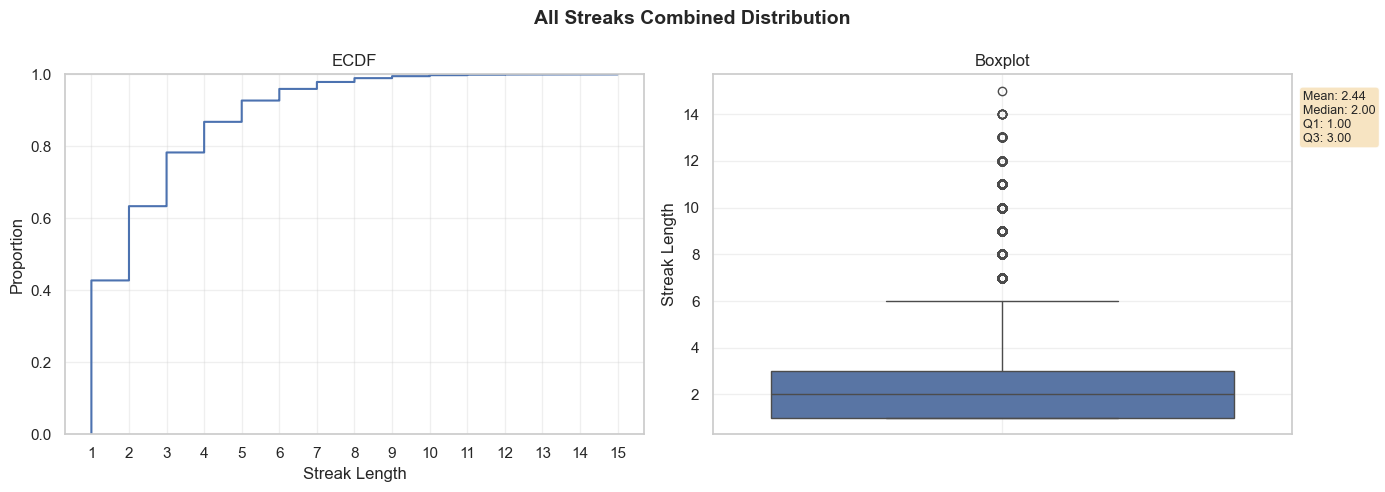

In [ ]:
# Create combined boxplot and histogram for all streak data
streak_columns = ['win_streak']

# Combine all streak data
combined_streaks = pd.concat([game_reversals[col].dropna() for col in streak_columns if col in game_reversals.columns])

if len(combined_streaks) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('All Streaks Combined Distribution', fontsize=14, fontweight='bold')
    
    # ECDF plot using seaborn
    sns.ecdfplot(data=combined_streaks, ax=ax1)
    ax1.set_xlabel('Streak Length')
    ax1.set_title('ECDF')
    ax1.grid(True, alpha=0.3)
    # Show each x-axis value
    unique_values = sorted(combined_streaks.unique())
    ax1.set_xticks(unique_values)
    
    # Boxplot using seaborn
    sns.boxplot(y=combined_streaks, ax=ax2)
    ax2.set_ylabel('Streak Length')
    ax2.set_title('Boxplot')
    ax2.grid(True, alpha=0.3)

    # Add statistics
    mean_val = combined_streaks.mean()
    median_val = combined_streaks.median()
    q1_val = combined_streaks.quantile(0.25)
    q3_val = combined_streaks.quantile(0.75)
    ax2.text(0.52, 15, 
                    f'Mean: {mean_val:.2f}\nMedian: {median_val:.2f}\nQ1: {q1_val:.2f}\nQ3: {q3_val:.2f}',
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                    fontsize=9)
    
    plt.tight_layout()
    plt.show()


### Statistical Power Analysis: Sample Size vs Minimum Detectable Win Rate Difference

This analysis shows how many games are needed to detect a significant difference from 50% win rate at the 0.05 significance level.

In [ ]:
from scipy.stats import binom

print("="*80)
print("STATISTICAL POWER ANALYSIS: MINIMUM DETECTABLE WIN RATE DIFFERENCE")
print("="*80)
print()
print("For a two-tailed binomial test at α = 0.005 significance level")
print("Null hypothesis: Win rate = 50%")
print()

# Create range of sample sizes (logarithmic scale for better coverage)
sample_sizes = []
for exp in range(1, 7):  # 10^1 to 10^6
    base = 10 ** exp
    if exp == 1:
        sample_sizes.extend([10, 20, 50])
    else:
        sample_sizes.extend([base, 2*base, 5*base])

sample_sizes = sorted(set(sample_sizes))

# Calculate minimum detectable difference for each sample size
results = []
for n in sample_sizes:
    # For two-tailed test at α = 0.005, we need p-value < 0.005
    # Find the minimum number of wins that would be significant
    # Start from 50% and go up
    null_prob = 0.5
    
    # Test win rates from 51% upward
    min_significant_rate = None
    for wins in range(int(n * 0.5), n + 1):
        win_rate = wins / n
        # Two-tailed test: calculate p-value
        # P(X >= wins) for upper tail
        p_value_upper = 1 - binom.cdf(wins - 1, n, null_prob)
        # For two-tailed, multiply by 2
        p_value = 2 * min(p_value_upper, 1 - p_value_upper)
        
        if p_value < 0.005:
            min_significant_rate = win_rate
            break
    
    if min_significant_rate:
        diff_from_50 = abs(min_significant_rate - 0.5) * 100
        results.append({
            'n_games': n,
            'min_win_rate': min_significant_rate * 100,
            'min_difference': diff_from_50
        })

# Create DataFrame
results_df = pd.DataFrame(results)

# Display table
print("Sample Size vs Minimum Detectable Win Rate Difference:")
print()
print(f"{'N Games':<12} {'Min Win Rate':<15} {'Min Diff from 50%':<20}")
print("-" * 50)
for _, row in results_df.iterrows():
    print(f"{row['n_games']:<12,} {row['min_win_rate']:>12.2f}% {row['min_difference']:>15.2f}%")



STATISTICAL POWER ANALYSIS: MINIMUM DETECTABLE WIN RATE DIFFERENCE

For a two-tailed binomial test at α = 0.005 significance level
Null hypothesis: Win rate = 50%

Sample Size vs Minimum Detectable Win Rate Difference:

N Games      Min Win Rate    Min Diff from 50%   
--------------------------------------------------
10.0               100.00%           50.00%
20.0                85.00%           35.00%
50.0                72.00%           22.00%
100.0               65.00%           15.00%
200.0               60.50%           10.50%
500.0               56.40%            6.40%
1,000.0             54.50%            4.50%
2,000.0             53.20%            3.20%
5,000.0             52.00%            2.00%
10,000.0            51.41%            1.41%
20,000.0            51.00%            1.00%
50,000.0            50.63%            0.63%
100,000.0           50.44%            0.44%
200,000.0           50.31%            0.31%
500,000.0           50.20%            0.20%
1,000,000.0        

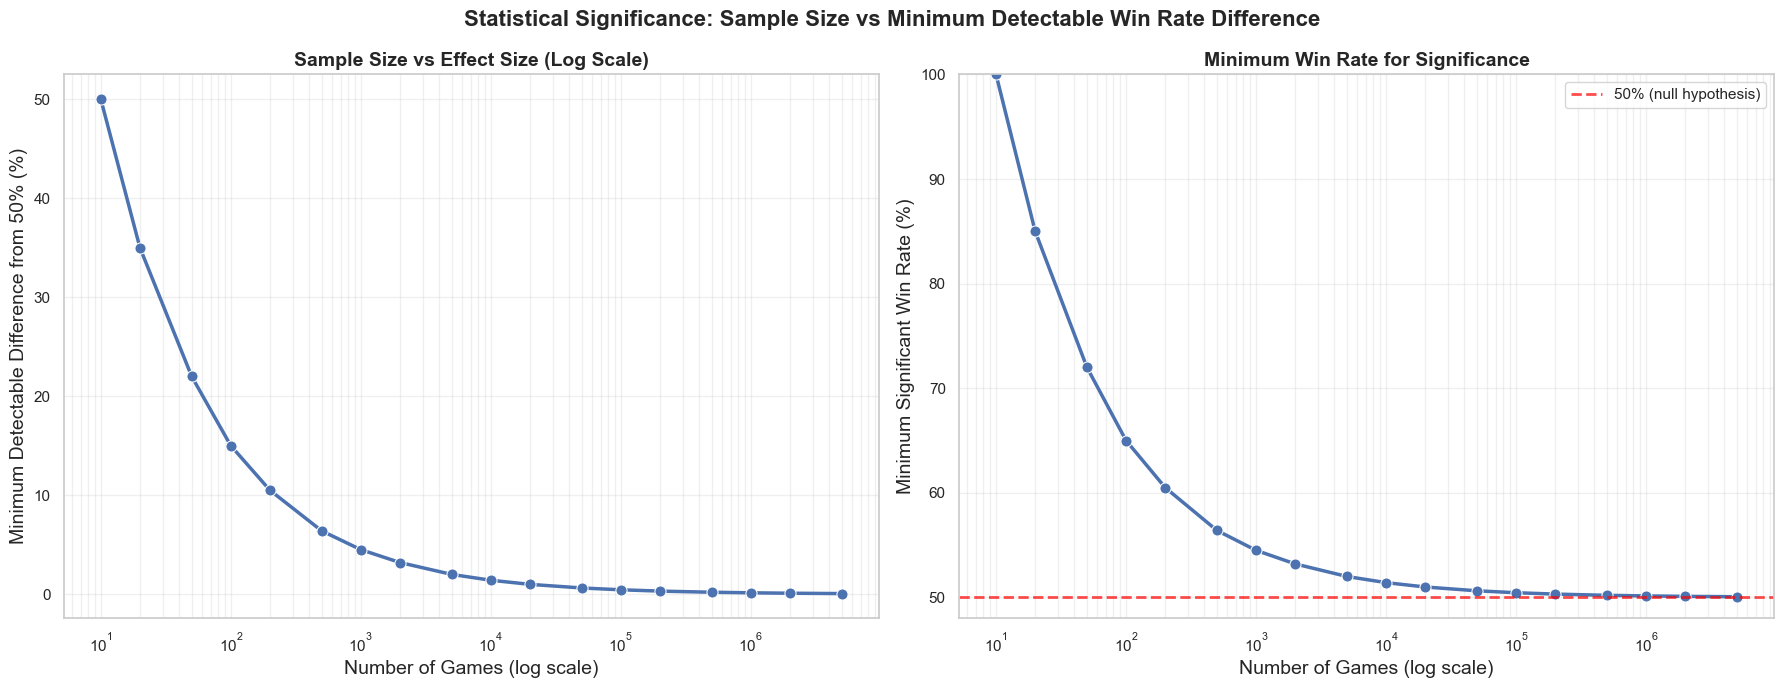


📊 Visualization complete!


In [ ]:
# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Statistical Significance: Sample Size vs Minimum Detectable Win Rate Difference', 
             fontsize=16, fontweight='bold')

# Plot 1: Log-scale x-axis showing the relationship
sns.lineplot(data=results_df, x='n_games', y='min_difference', marker='o', markersize=8, linewidth=2.5, ax=ax1)
ax1.set_xscale('log')
ax1.set_xlabel('Number of Games (log scale)', fontsize=14)
ax1.set_ylabel('Minimum Detectable Difference from 50% (%)', fontsize=14)
ax1.set_title('Sample Size vs Effect Size (Log Scale)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, which='both')



# Plot 2: Show how win rate converges to 50% with more games
sns.lineplot(data=results_df, x='n_games', y='min_win_rate', marker='o', markersize=8, linewidth=2.5, ax=ax2)
ax2.set_xscale('log')
ax2.axhline(y=50, color='red', linestyle='--', linewidth=2, alpha=0.7, label='50% (null hypothesis)')
ax2.set_xlabel('Number of Games (log scale)', fontsize=14)
ax2.set_ylabel('Minimum Significant Win Rate (%)', fontsize=14)
ax2.set_title('Minimum Win Rate for Significance', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')
ax2.legend(fontsize=11)
ax2.set_ylim(48, 100)

plt.tight_layout()
plt.show()

print()
print("📊 Visualization complete!")

#TODO: export the next couple of section to a different notebook because running all of this takes quite some time!

and add some of the tests used in 63)!

### Testing 63) pistol round outcome

In [ ]:
# Get H1 round 1 winners and H2 round 16 winners
h1_winners = detailed_df[detailed_df['round_num'] == 1][['id_demo_exports', 'team1_winner']].rename(columns={'team1_winner': 'h1_team1_winner'})
h2_winners = detailed_df[detailed_df['round_num'] == 16][['id_demo_exports', 'team1_winner']].rename(columns={'team1_winner': 'h2_team1_winner'})

# Merge into scores dataframe
scores = scores.merge(h1_winners, on='id_demo_exports', how='left')
print(f"Scores after H1 merge: {len(scores)}")

scores = scores.merge(h2_winners, on='id_demo_exports', how='left')
print(f"Scores after H2 merge: {len(scores)}")



Scores after H1 merge: 98937
Scores after H2 merge: 98937


In [ ]:

scores.dropna(inplace=True)

# Determine overall winner
scores['t1_is_winner'] = scores['t1_final'] > scores['t2_final']

# Create is_overallwinner_winner_h1: True if overall winner won round 1
# Fill NaN with False for games missing round 1 data
scores['is_overallwinner_winner_h1'] = (
    (scores['t1_is_winner'] & scores['h1_team1_winner']) | 
    (~scores['t1_is_winner'] & ~scores['h1_team1_winner'])
)

# Create is_overallwinner_winner_h2: True if overall winner won round 16
# Fill NaN with False for games missing round 16 data
scores['is_overallwinner_winner_h2'] = (
    (scores['t1_is_winner'] & scores['h2_team1_winner']) | 
    (~scores['t1_is_winner'] & ~scores['h2_team1_winner'])
)


In [ ]:
print("="*80)
print("FREQUENCY TABLE: PISTOL ROUND OUTCOMES")
print("="*80)
print()

# Create frequency table with counts and percentages
frequency_pistol_rounds = (
    scores.groupby(['is_overallwinner_winner_h1', 'is_overallwinner_winner_h2'])
    .size()
    .reset_index(name='count')
).copy()

frequency_pistol_rounds['percentage'] = (frequency_pistol_rounds['count'] / frequency_pistol_rounds['count'].sum() * 100).round(2)

# Rename columns for clarity
frequency_pistol_rounds.columns = ['Winner H1', 'Winner H2', 'Count', 'Percentage']

# Create labels for each combination
labels = []
for idx, row in frequency_pistol_rounds.iterrows():
    h1 = 'Won' if row['Winner H1'] else 'Lost'
    h2 = 'Won' if row['Winner H2'] else 'Lost'
    labels.append(f"{h1} H1, {h2} H2")

frequency_pistol_rounds.insert(0, 'Outcome', labels)

print(frequency_pistol_rounds.to_string(index=False))
print()
print(f"Total Games: {frequency_pistol_rounds['Count'].sum()}")
print()




FREQUENCY TABLE: PISTOL ROUND OUTCOMES

         Outcome  Winner H1  Winner H2  Count  Percentage
Lost H1, Lost H2      False      False   8463        8.57
 Lost H1, Won H2      False       True  13366       13.54
 Won H1, Lost H2       True      False  13393       13.56
  Won H1, Won H2       True       True  63528       64.33

Total Games: 98750




2x2 MATRIX: PISTOL ROUND OUTCOMES

Rows: H2 Pistol Outcome | Columns: H1 Pistol Outcome

         Lost H1  Won H1
Lost H2     8463   13393
Won H2     13366   63528

Percentages:
         Lost H1  Won H1
Lost H2      8.6    13.6
Won H2      13.5    64.3



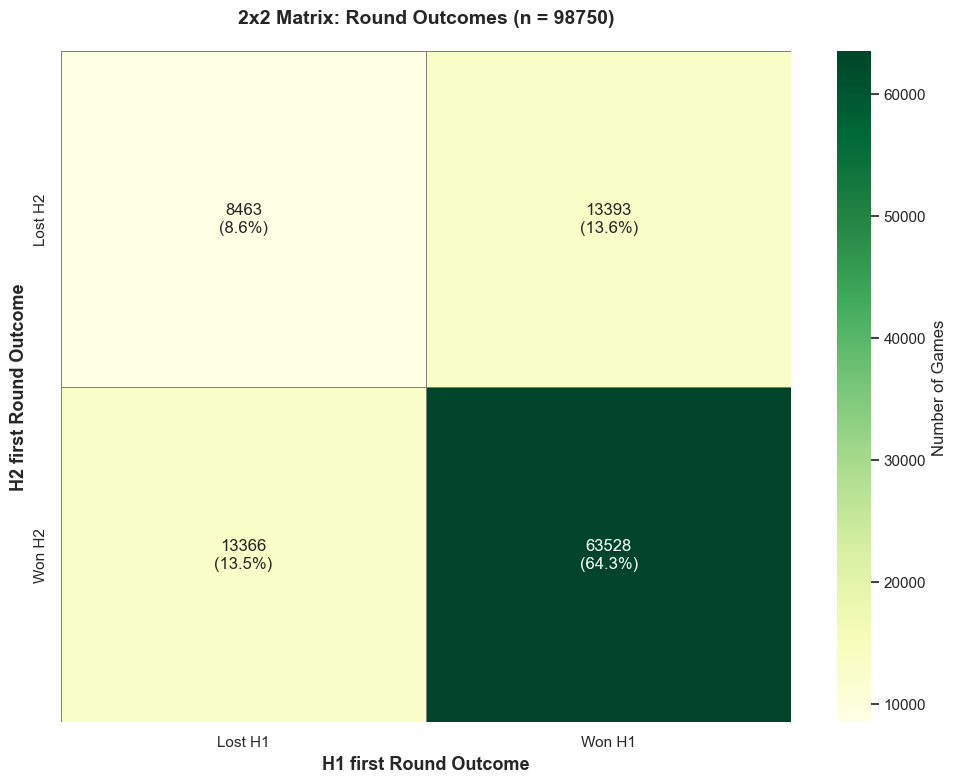

In [ ]:
# Create 2x2 matrix visualization
matrix_data = scores.groupby(['is_overallwinner_winner_h1', 'is_overallwinner_winner_h2']).size().unstack(fill_value=0)

# Rename index and columns for clarity
matrix_data.index = ['Lost H1', 'Won H1']
matrix_data.columns = ['Lost H2', 'Won H2']

# Transpose to switch x and y axes
matrix_data = matrix_data.T

print("\n" + "="*80)
print("2x2 MATRIX: PISTOL ROUND OUTCOMES")
print("="*80)
print()
print("Rows: H2 Pistol Outcome | Columns: H1 Pistol Outcome")
print()
print(matrix_data)
print()

# Calculate percentages
matrix_pct = (matrix_data / matrix_data.sum().sum() * 100).round(1)
print("Percentages:")
print(matrix_pct)
print()

# Create heatmap visualization using seaborn
fig, ax = plt.subplots(figsize=(10, 8))

# Create annotations with counts and percentages
annot_labels = np.empty_like(matrix_data.values, dtype=object)
for i in range(len(matrix_data.index)):
    for j in range(len(matrix_data.columns)):
        count = matrix_data.iloc[i, j]
        pct = matrix_pct.iloc[i, j]
        annot_labels[i, j] = f'{int(count)}\n({pct:.1f}%)'

# Create seaborn heatmap
sns.heatmap(matrix_data, annot=annot_labels, fmt='', cmap='YlGn', 
            cbar_kws={'label': 'Number of Games'},
            linewidths=0.5, linecolor='gray', ax=ax)

# Add labels
ax.set_xlabel('H1 first Round Outcome', fontsize=13, fontweight='bold')
ax.set_ylabel('H2 first Round Outcome', fontsize=13, fontweight='bold')
ax.set_title(f'2x2 Matrix: Round Outcomes (n = {matrix_data.values.sum()})', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()




Total games: 98750
Regular time games (no OT): 89608
OT games: 9142

2x2 MATRIX: PISTOL ROUND OUTCOMES (REGULAR TIME ONLY - NO OT)

Rows: H2 Pistol Outcome | Columns: H1 Pistol Outcome

         Lost H1  Won H1
Lost H2     7292   12177
Won H2     12090   58049

Percentages:
         Lost H1  Won H1
Lost H2      8.1    13.6
Won H2      13.5    64.8



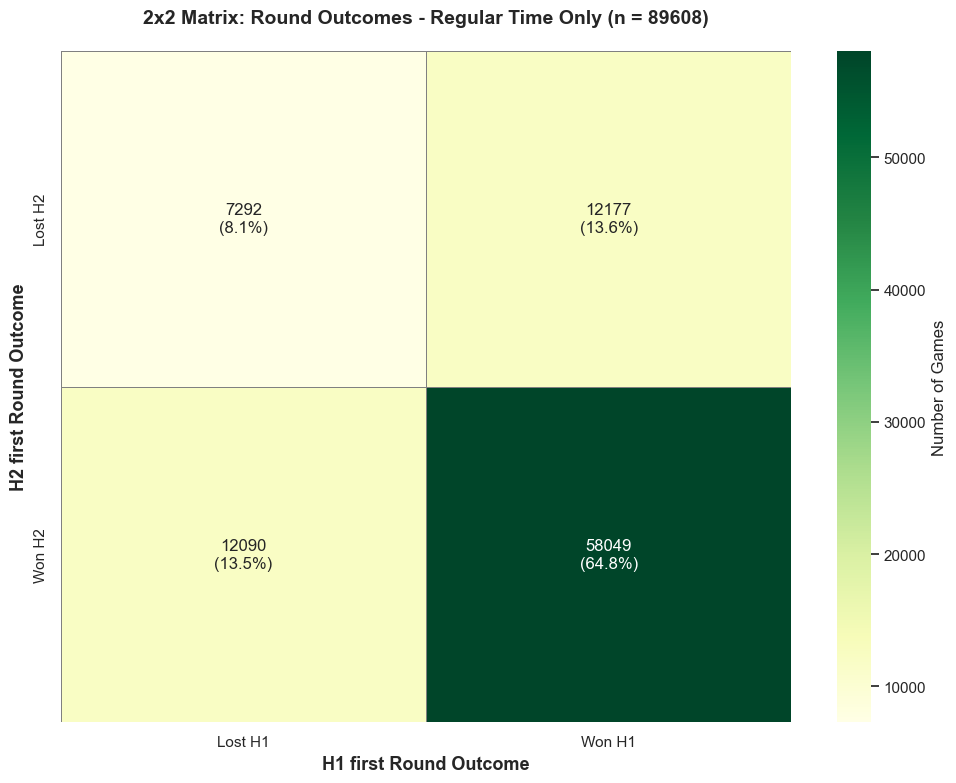

In [ ]:

# Mark games as OT or not OT
scores['is_ot'] = scores['total_rounds'] > 30

# Filter to regular time (non-OT) games
scores_regular = scores[~scores['is_ot']].copy()

print(f"Total games: {len(scores)}")
print(f"Regular time games (no OT): {len(scores_regular)}")
print(f"OT games: {scores['is_ot'].sum()}")
print()

# Create 2x2 matrix for regular time games
matrix_data_regular = scores_regular.groupby(['is_overallwinner_winner_h1', 'is_overallwinner_winner_h2']).size().unstack(fill_value=0)

# Rename index and columns for clarity
matrix_data_regular.index = ['Lost H1', 'Won H1']
matrix_data_regular.columns = ['Lost H2', 'Won H2']

# Transpose to switch x and y axes
matrix_data_regular = matrix_data_regular.T

print("="*80)
print("2x2 MATRIX: PISTOL ROUND OUTCOMES (REGULAR TIME ONLY - NO OT)")
print("="*80)
print()
print("Rows: H2 Pistol Outcome | Columns: H1 Pistol Outcome")
print()
print(matrix_data_regular)
print()

# Calculate percentages
matrix_pct_regular = (matrix_data_regular / matrix_data_regular.sum().sum() * 100).round(1)
print("Percentages:")
print(matrix_pct_regular)
print()

# Create heatmap visualization using seaborn
fig, ax = plt.subplots(figsize=(10, 8))

# Create annotations with counts and percentages
annot_labels = np.empty_like(matrix_data_regular.values, dtype=object)
for i in range(len(matrix_data_regular.index)):
    for j in range(len(matrix_data_regular.columns)):
        count = matrix_data_regular.iloc[i, j]
        pct = matrix_pct_regular.iloc[i, j]
        annot_labels[i, j] = f'{int(count)}\n({pct:.1f}%)'

# Create seaborn heatmap
sns.heatmap(matrix_data_regular, annot=annot_labels, fmt='', cmap='YlGn', 
            cbar_kws={'label': 'Number of Games'},
            linewidths=0.5, linecolor='gray', ax=ax)

# Add labels
ax.set_xlabel('H1 first Round Outcome', fontsize=13, fontweight='bold')
ax.set_ylabel('H2 first Round Outcome', fontsize=13, fontweight='bold')
ax.set_title(f'2x2 Matrix: Round Outcomes - Regular Time Only (n = {matrix_data_regular.values.sum()})', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

### Testing Buy Type Categories from Literature 8)

In [ ]:
print("="*80)
print("BUY TYPE ANALYSIS - Testing Literature Claims")
print("="*80)
print()
print("Paper's Definitions:")
print("1) Eco:           seq 0-3k,    sp 0-2k,     winr 3%")
print("2) Low buy:       seq 0-3k,    sp 2k-7.5k,  winr 27%")
print("3) Half buy:      seq 0-3k,    sp 7.5-20k,  winr 34%")
print("4) Hero low buy:  seq 3-20k,   sp 0-7.5k,   winr 25%")
print("5) Hero half buy: seq 3-20k,   sp 7.5-17k,  winr 48%")
print("6) Full buy:      seq+sp > 20k,            winr 59%")
print()
print("Where: seq = starting equipment value per team, sp = spend per team")
print()

# Create a copy of economy_df for buy type analysis
buy_type_df = economy_df.copy()

# Filter out rows where money_spent is < 0
print("🔹 Filtering data for buy type analysis:")
print(f"   Original rows: {len(buy_type_df):,}")

# Remove rows with negative money spent for either side
before_filter = len(buy_type_df)
buy_type_df = buy_type_df[
    (buy_type_df['ct_money_spent'] >= 0) & 
    (buy_type_df['t_money_spent'] >= 0)
]
print(f"   After removing negative money_spent: {len(buy_type_df):,} (removed {before_filter - len(buy_type_df):,})")

# Apply 99th percentile filter for money_spent
ct_q99 = buy_type_df['ct_money_spent'].quantile(0.99)
t_q99 = buy_type_df['t_money_spent'].quantile(0.99)

before_q99 = len(buy_type_df)
buy_type_df = buy_type_df[
    (buy_type_df['ct_money_spent'] <= ct_q99) & 
    (buy_type_df['t_money_spent'] <= t_q99)
]
print(f"   After 99th percentile filter: {len(buy_type_df):,} (removed {before_q99 - len(buy_type_df):,})")
print(f"   CT money_spent q99: ${ct_q99:,.0f}")
print(f"   T money_spent q99: ${t_q99:,.0f}")
print()

# Function to categorize buy types for each team
def categorize_buy_type(row, side):
    """
    Categorize buy type based on starting equipment and spending
    side: 'ct' or 't'
    """
    seq = row[f'{side}_starting_equipment']
    sp = row[f'{side}_money_spent']
    
    # Handle missing data
    if pd.isna(seq) or pd.isna(sp):
        return None
    
    # Convert to thousands for easier comparison
    seq_k = seq / 1000
    sp_k = sp / 1000
    
    # Category 6: Full buy - equipment + spend > 20k
    if seq + sp > 20000:
        return 'Full Buy'
    
    # Categories 1-3: Low starting equipment (0-3k)
    if seq_k <= 3:
        if sp_k <= 2:
            return 'Eco'
        elif sp_k <= 7.5:
            return 'Low Buy'
        else:  # sp 7.5-20k
            return 'Half Buy'
    
    # Categories 4-5: Higher starting equipment (3-20k)
    elif seq_k <= 20:
        if sp_k <= 7.5:
            return 'Hero Low Buy'
        elif sp_k <= 17:
            return 'Hero Half Buy'
        else:
            return 'Full Buy'  # This falls into full buy territory
    
    # seq > 20k
    else:
        return 'Full Buy'

# Create buy type columns for both sides on the filtered dataframe
buy_type_df['ct_buy_type'] = buy_type_df.apply(lambda row: categorize_buy_type(row, 'ct'), axis=1)
buy_type_df['t_buy_type'] = buy_type_df.apply(lambda row: categorize_buy_type(row, 't'), axis=1)

print("✅ Buy types categorized for both CT and T sides")
print()

BUY TYPE ANALYSIS - Testing Literature Claims

Paper's Definitions:
1) Eco:           seq 0-3k,    sp 0-2k,     winr 3%
2) Low buy:       seq 0-3k,    sp 2k-7.5k,  winr 27%
3) Half buy:      seq 0-3k,    sp 7.5-20k,  winr 34%
4) Hero low buy:  seq 3-20k,   sp 0-7.5k,   winr 25%
5) Hero half buy: seq 3-20k,   sp 7.5-17k,  winr 48%
6) Full buy:      seq+sp > 20k,            winr 59%

Where: seq = starting equipment value per team, sp = spend per team

🔹 Filtering data for buy type analysis:
   Original rows: 2,598,822
   After removing negative money_spent: 2,525,267 (removed 73,555)
   After 99th percentile filter: 2,477,045 (removed 48,222)
   CT money_spent q99: $31,250
   T money_spent q99: $27,150

✅ Buy types categorized for both CT and T sides



In [ ]:
# Calculate win rates for each buy type - CT side
ct_buy_stats = buy_type_df.groupby('ct_buy_type').agg({
    'ct_winner': ['count', 'sum', 'mean']
}).round(4)
ct_buy_stats.columns = ['Total Rounds', 'Wins', 'Win Rate']
ct_buy_stats['Win Rate %'] = (ct_buy_stats['Win Rate'] * 100).round(2)

# Calculate win rates for each buy type - T side
t_buy_stats = buy_type_df.groupby('t_buy_type').agg({
    'ct_winner': ['count', lambda x: (~x).sum(), lambda x: (~x).mean()]  # T wins when CT doesn't win
}).round(4)
t_buy_stats.columns = ['Total Rounds', 'Wins', 'Win Rate']
t_buy_stats['Win Rate %'] = (t_buy_stats['Win Rate'] * 100).round(2)

# Define category order for consistent display
category_order = ['Eco', 'Low Buy', 'Half Buy', 'Hero Low Buy', 'Hero Half Buy', 'Full Buy']

# Reindex to ensure consistent ordering
ct_buy_stats = ct_buy_stats.reindex(category_order).dropna(how='all')
t_buy_stats = t_buy_stats.reindex(category_order).dropna(how='all')

print("="*80)
print("CT SIDE - BUY TYPE WIN RATES")
print("="*80)
print()
print(ct_buy_stats.to_string())
print()

print("="*80)
print("T SIDE - BUY TYPE WIN RATES")
print("="*80)
print()
print(t_buy_stats.to_string())
print()

# Combine both sides for overall analysis
combined_buy_types = []
for side in ['ct', 't']:
    for idx, row in buy_type_df.iterrows():
        buy_type = row[f'{side}_buy_type']
        if pd.notna(buy_type):
            winner = row['ct_winner'] if side == 'ct' else not row['ct_winner']
            combined_buy_types.append({
                'buy_type': buy_type,
                'won': winner,
                'side': side.upper()
            })

combined_df = pd.DataFrame(combined_buy_types)
combined_stats = combined_df.groupby('buy_type').agg({
    'won': ['count', 'sum', 'mean']
})
combined_stats.columns = ['Total Rounds', 'Wins', 'Win Rate']
combined_stats['Win Rate %'] = (combined_stats['Win Rate'] * 100).round(2)
combined_stats = combined_stats.reindex(category_order).dropna(how='all')

print("="*80)
print("COMBINED (CT + T) - BUY TYPE WIN RATES")
print("="*80)
print()
print(combined_stats.to_string())
print()

# Create comparison table with paper's claims
paper_claims = {
    'Eco': 3,
    'Low Buy': 27,
    'Half Buy': 34,
    'Hero Low Buy': 25,
    'Hero Half Buy': 48,
    'Full Buy': 59
}

print("="*80)
print("COMPARISON: OBSERVED vs PAPER'S CLAIMS")
print("="*80)
print()
comparison = pd.DataFrame({
    'Buy Type': category_order,
    'Paper Win %': [paper_claims.get(cat, None) for cat in category_order],
    'Observed Win %': [combined_stats.loc[cat, 'Win Rate %'] if cat in combined_stats.index else None for cat in category_order],
})
comparison['Difference'] = comparison['Observed Win %'] - comparison['Paper Win %']
comparison = comparison.dropna()
print(comparison.to_string(index=False))
print()

CT SIDE - BUY TYPE WIN RATES

               Total Rounds     Wins  Win Rate  Win Rate %
ct_buy_type                                               
Eco                  115484     4580    0.0397        3.97
Low Buy              333763   119990    0.3595       35.95
Half Buy             219542    85683    0.3903       39.03
Hero Low Buy         106734    23652    0.2216       22.16
Hero Half Buy         26709    10793    0.4041       40.41
Full Buy            1674813  1023451    0.6111       61.11

T SIDE - BUY TYPE WIN RATES

               Total Rounds    Wins  Win Rate  Win Rate %
t_buy_type                                               
Eco                   90983    3228    0.0355        3.55
Low Buy              358949  116088    0.3234       32.34
Half Buy             316526  130163    0.4112       41.12
Hero Low Buy          23773    8211    0.3454       34.54
Hero Half Buy         22828   13578    0.5948       59.48
Full Buy            1663986  937628    0.5635       56.35

COM

C:\Users\peter\AppData\Local\Temp\ipykernel_8452\2907073060.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(categories, rotation=45, ha='right')


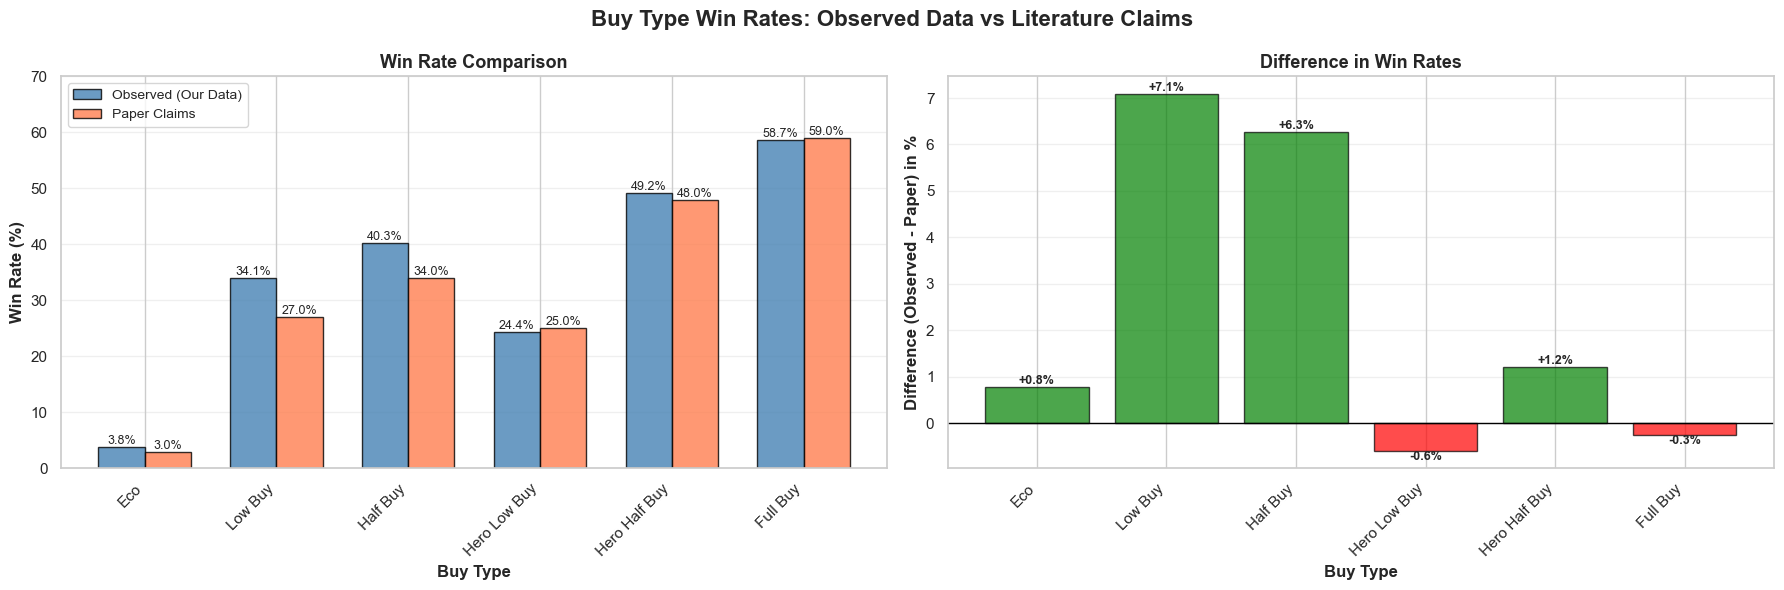

In [ ]:
# Create two-column visualization: Bar charts comparing observed vs paper claims
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Buy Type Win Rates: Observed Data vs Literature Claims', fontsize=16, fontweight='bold')

# Left plot: Bar chart comparing observed vs paper
categories = comparison['Buy Type'].values
observed = comparison['Observed Win %'].values
paper = comparison['Paper Win %'].values

x = np.arange(len(categories))
width = 0.35

bars1 = ax1.bar(x - width/2, observed, width, label='Observed (Our Data)', 
                color='steelblue', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, paper, width, label='Paper Claims', 
                color='coral', alpha=0.8, edgecolor='black')

ax1.set_xlabel('Buy Type', fontsize=12, fontweight='bold')
ax1.set_ylabel('Win Rate (%)', fontsize=12, fontweight='bold')
ax1.set_title('Win Rate Comparison', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(categories, rotation=45, ha='right')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, 70)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontsize=9)

# Right plot: Difference (Observed - Paper)
differences = comparison['Difference'].values
colors = ['green' if d >= 0 else 'red' for d in differences]

bars3 = ax2.bar(categories, differences, color=colors, alpha=0.7, edgecolor='black')

ax2.set_xlabel('Buy Type', fontsize=12, fontweight='bold')
ax2.set_ylabel('Difference (Observed - Paper) in %', fontsize=12, fontweight='bold')
ax2.set_title('Difference in Win Rates', fontsize=13, fontweight='bold')
ax2.set_xticklabels(categories, rotation=45, ha='right')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars3:
    height = bar.get_height()
    va = 'bottom' if height >= 0 else 'top'
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:+.1f}%',
            ha='center', va=va, fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

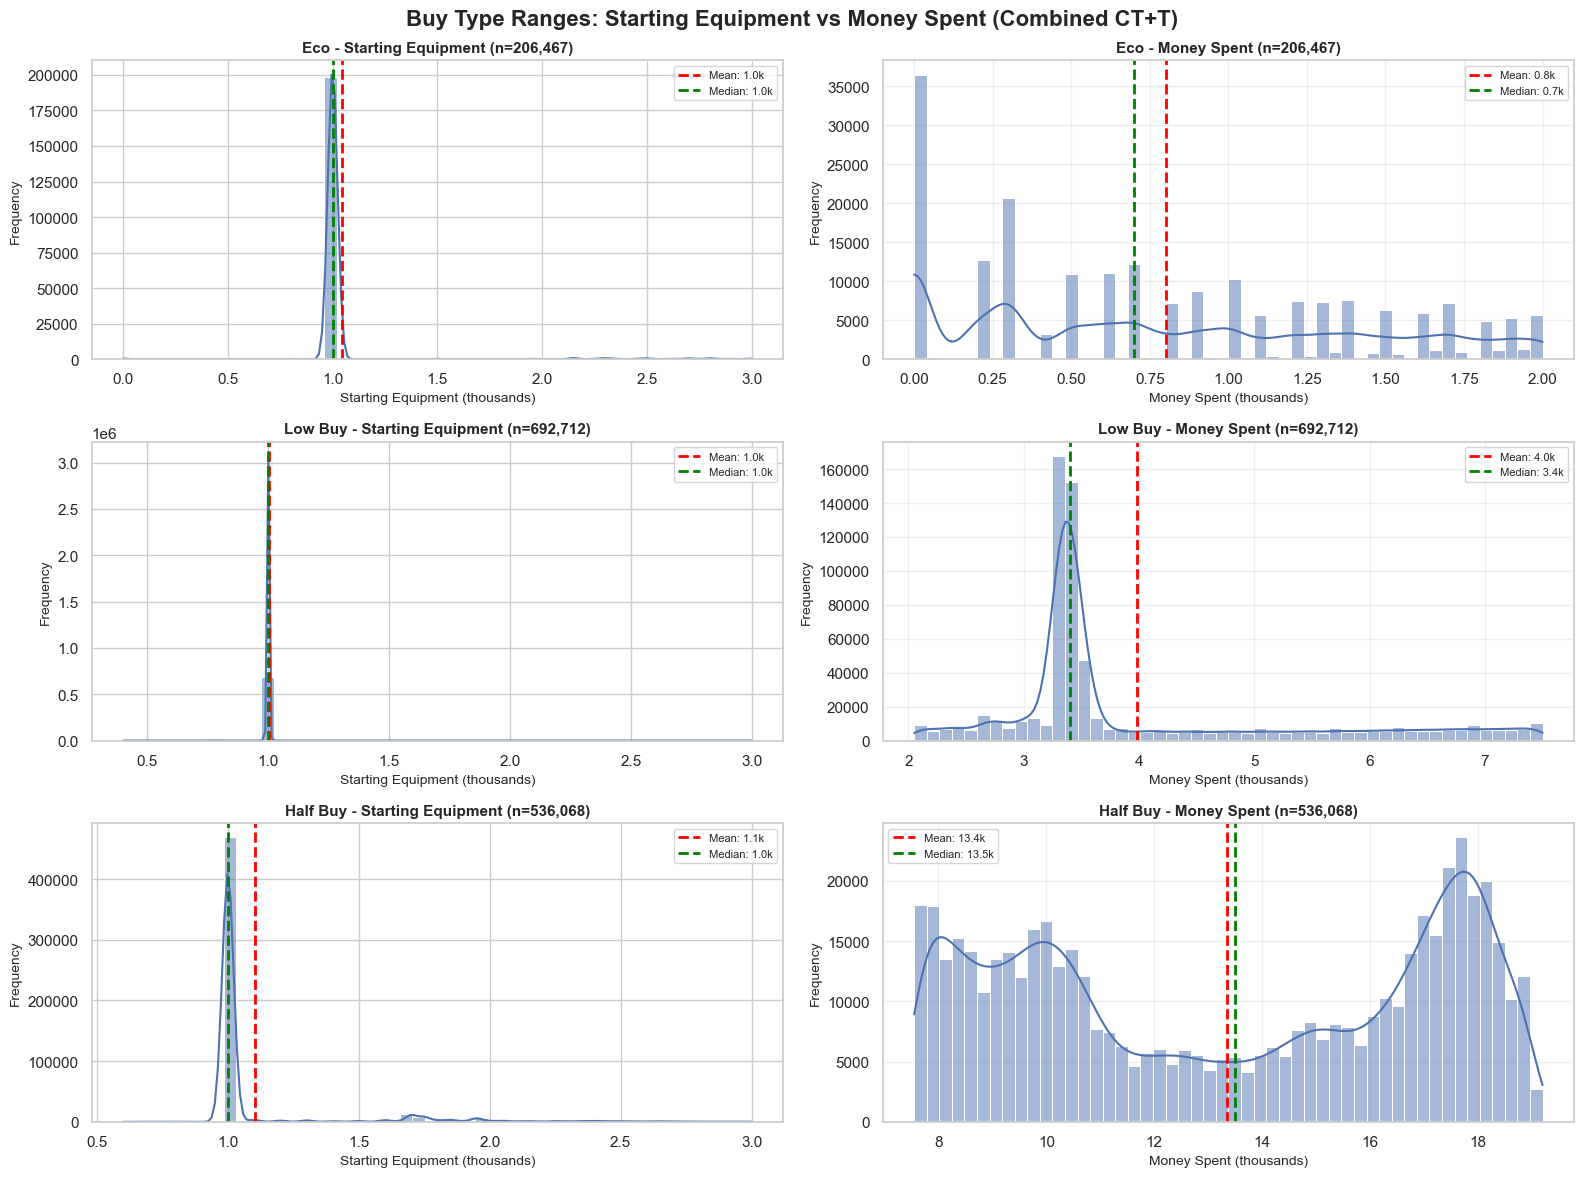

In [ ]:
# Create two-column visualization: Sample distributions of starting equipment and spending
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Buy Type Ranges: Starting Equipment vs Money Spent (Combined CT+T)', 
             fontsize=16, fontweight='bold')

# Combine CT and T data for each buy type
for idx, buy_type in enumerate(category_order):
    if idx >= len(axes):
        break
    
    row = idx
    
    # Get data for this buy type from both sides
    ct_mask = buy_type_df['ct_buy_type'] == buy_type
    t_mask = buy_type_df['t_buy_type'] == buy_type
    
    ct_seq = buy_type_df.loc[ct_mask, 'ct_starting_equipment'].dropna() / 1000  # Convert to thousands
    ct_sp = buy_type_df.loc[ct_mask, 'ct_money_spent'].dropna() / 1000
    
    t_seq = buy_type_df.loc[t_mask, 't_starting_equipment'].dropna() / 1000
    t_sp = buy_type_df.loc[t_mask, 't_money_spent'].dropna() / 1000
    
    # Combine both sides
    all_seq = pd.concat([ct_seq, t_seq])
    all_sp = pd.concat([ct_sp, t_sp])
    
    # Left column: Starting Equipment
    if len(all_seq) > 0:
        sns.histplot(all_seq, bins=50, kde=True, ax=axes[row, 0])
        axes[row, 0].axvline(all_seq.mean(), color='red', linestyle='--', linewidth=2, 
                            label=f'Mean: {all_seq.mean():.1f}k')
        axes[row, 0].axvline(all_seq.median(), color='green', linestyle='--', linewidth=2,
                            label=f'Median: {all_seq.median():.1f}k')
        axes[row, 0].set_xlabel('Starting Equipment (thousands)', fontsize=10)
        axes[row, 0].set_ylabel('Frequency', fontsize=10)
        axes[row, 0].set_title(f'{buy_type} - Starting Equipment (n={len(all_seq):,})', 
                              fontsize=11, fontweight='bold')
        axes[row, 0].legend(fontsize=8)
    else:
        axes[row, 0].text(0.5, 0.5, f'No data for {buy_type}', 
                         ha='center', va='center', transform=axes[row, 0].transAxes)
    
    # Right column: Money Spent
    if len(all_sp) > 0:
        sns.histplot(all_sp, bins=50, kde=True, ax=axes[row, 1])
        axes[row, 1].axvline(all_sp.mean(), color='red', linestyle='--', linewidth=2,
                            label=f'Mean: {all_sp.mean():.1f}k')
        axes[row, 1].axvline(all_sp.median(), color='green', linestyle='--', linewidth=2,
                            label=f'Median: {all_sp.median():.1f}k')
        axes[row, 1].set_xlabel('Money Spent (thousands)', fontsize=10)
        axes[row, 1].set_ylabel('Frequency', fontsize=10)
        axes[row, 1].set_title(f'{buy_type} - Money Spent (n={len(all_sp):,})', 
                              fontsize=11, fontweight='bold')
        axes[row, 1].legend(fontsize=8)
        axes[row, 1].grid(True, alpha=0.3)
    else:
        axes[row, 1].text(0.5, 0.5, f'No data for {buy_type}', 
                         ha='center', va='center', transform=axes[row, 1].transAxes)

plt.tight_layout()
plt.show()

In [ ]:
print("="*80)
print("BUY TYPE DISTRIBUTION ANALYSIS")
print("="*80)
print()

# Calculate distribution of buy types for CT and T sides
ct_distribution = buy_type_df['ct_buy_type'].value_counts()
t_distribution = buy_type_df['t_buy_type'].value_counts()

# Calculate percentages
ct_pct = (ct_distribution / ct_distribution.sum() * 100).round(2)
t_pct = (t_distribution / t_distribution.sum() * 100).round(2)

# Reindex to ensure consistent ordering
ct_distribution = ct_distribution.reindex(category_order).fillna(0)
ct_pct = ct_pct.reindex(category_order).fillna(0)
t_distribution = t_distribution.reindex(category_order).fillna(0)
t_pct = t_pct.reindex(category_order).fillna(0)

# Create distribution dataframes
ct_dist_df = pd.DataFrame({
    'Buy Type': ct_distribution.index,
    'Count': ct_distribution.values,
    'Percentage': ct_pct.values
})

t_dist_df = pd.DataFrame({
    'Buy Type': t_distribution.index,
    'Count': t_distribution.values,
    'Percentage': t_pct.values
})

print("CT SIDE - BUY TYPE DISTRIBUTION")
print("-"*80)
print(ct_dist_df.to_string(index=False))
print(f"\nTotal CT rounds: {ct_distribution.sum():,.0f}")
print()

print("T SIDE - BUY TYPE DISTRIBUTION")
print("-"*80)
print(t_dist_df.to_string(index=False))
print(f"\nTotal T rounds: {t_distribution.sum():,.0f}")
print()

# Combined distribution
combined_dist = pd.concat([
    buy_type_df['ct_buy_type'].value_counts(),
    buy_type_df['t_buy_type'].value_counts()
])
combined_dist = combined_dist.groupby(combined_dist.index).sum()
combined_pct = (combined_dist / combined_dist.sum() * 100).round(2)

combined_dist = combined_dist.reindex(category_order).fillna(0)
combined_pct = combined_pct.reindex(category_order).fillna(0)

combined_dist_df = pd.DataFrame({
    'Buy Type': combined_dist.index,
    'Count': combined_dist.values,
    'Percentage': combined_pct.values
})

print("COMBINED (CT + T) - BUY TYPE DISTRIBUTION")
print("-"*80)
print(combined_dist_df.to_string(index=False))
print(f"\nTotal combined rounds: {combined_dist.sum():,.0f}")
print()

BUY TYPE DISTRIBUTION ANALYSIS

CT SIDE - BUY TYPE DISTRIBUTION
--------------------------------------------------------------------------------
     Buy Type   Count  Percentage
          Eco  115484        4.66
      Low Buy  333763       13.47
     Half Buy  219542        8.86
 Hero Low Buy  106734        4.31
Hero Half Buy   26709        1.08
     Full Buy 1674813       67.61

Total CT rounds: 2,477,045

T SIDE - BUY TYPE DISTRIBUTION
--------------------------------------------------------------------------------
     Buy Type   Count  Percentage
          Eco   90983        3.67
      Low Buy  358949       14.49
     Half Buy  316526       12.78
 Hero Low Buy   23773        0.96
Hero Half Buy   22828        0.92
     Full Buy 1663986       67.18

Total T rounds: 2,477,045

COMBINED (CT + T) - BUY TYPE DISTRIBUTION
--------------------------------------------------------------------------------
     Buy Type   Count  Percentage
          Eco  206467        4.17
      Low Buy  6927

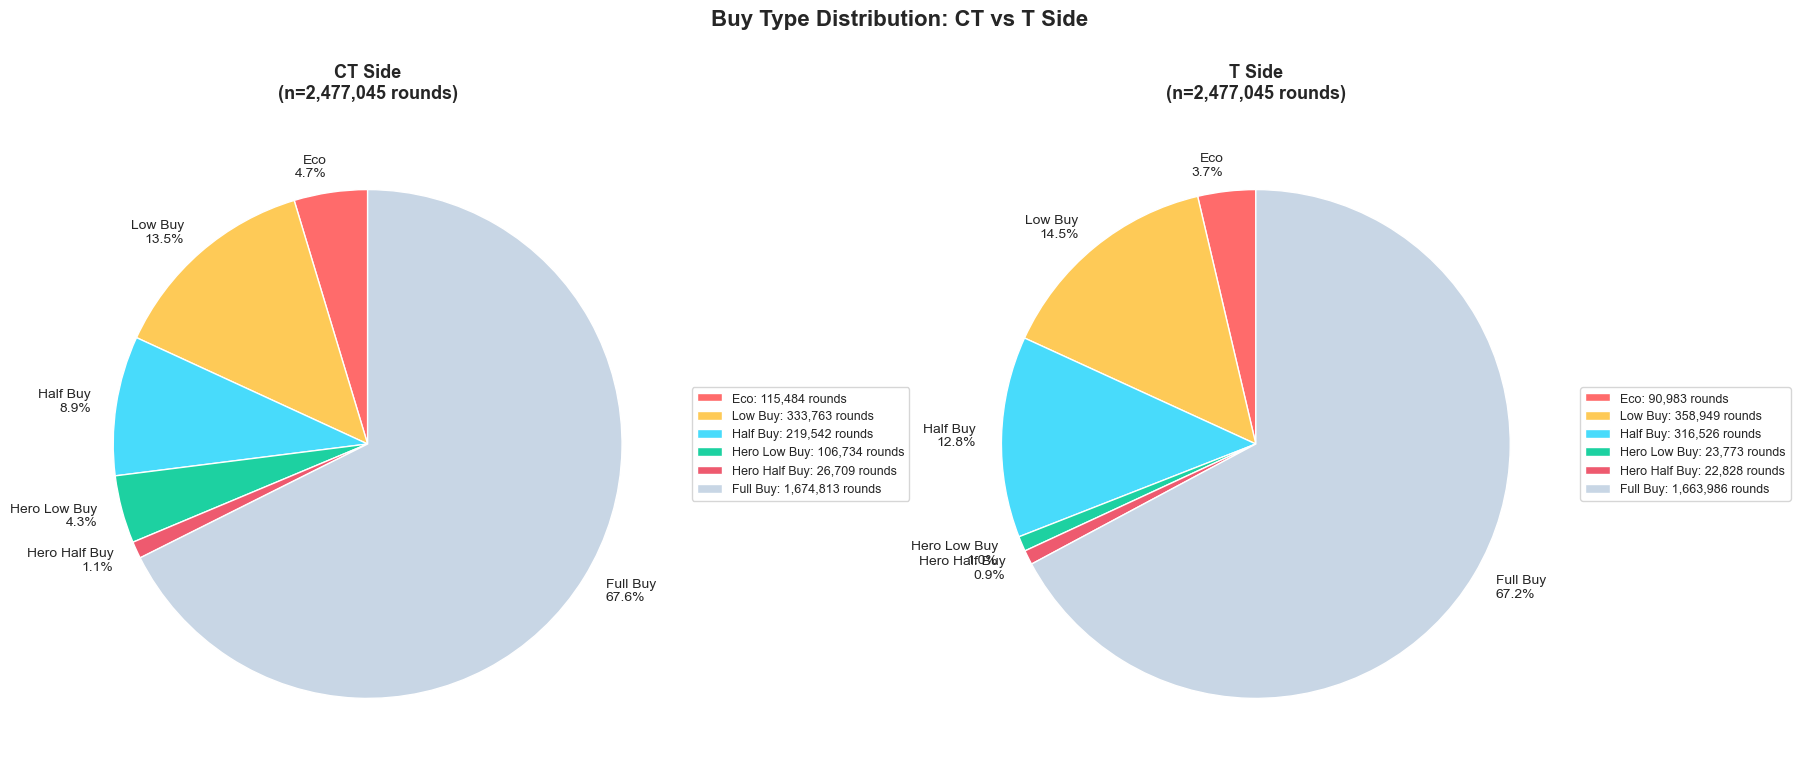

In [ ]:
# Create two-column visualization: Buy type distribution pie charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Buy Type Distribution: CT vs T Side', fontsize=16, fontweight='bold')

# Define colors for consistency
colors_palette = ['#ff6b6b', '#feca57', '#48dbfb', '#1dd1a1', '#ee5a6f', '#c8d6e5']

# Left plot: CT Side Distribution
ct_sizes = ct_distribution[ct_distribution > 0]
ct_labels = [f'{cat}\n{ct_pct[cat]:.1f}%' for cat in ct_sizes.index]

wedges1, texts1, autotexts1 = ax1.pie(ct_sizes, labels=ct_labels, autopct='',
                                        colors=colors_palette[:len(ct_sizes)],
                                        startangle=90, textprops={'fontsize': 10})

for autotext in autotexts1:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

ax1.set_title(f'CT Side\n(n={ct_distribution.sum():,.0f} rounds)', 
              fontsize=13, fontweight='bold', pad=20)

# Add legend with counts
legend_labels_ct = [f'{cat}: {int(ct_distribution[cat]):,} rounds' 
                    for cat in ct_sizes.index]
ax1.legend(legend_labels_ct, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), fontsize=9)

# Right plot: T Side Distribution
t_sizes = t_distribution[t_distribution > 0]
t_labels = [f'{cat}\n{t_pct[cat]:.1f}%' for cat in t_sizes.index]

wedges2, texts2, autotexts2 = ax2.pie(t_sizes, labels=t_labels, autopct='',
                                        colors=colors_palette[:len(t_sizes)],
                                        startangle=90, textprops={'fontsize': 10})

for autotext in autotexts2:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

ax2.set_title(f'T Side\n(n={t_distribution.sum():,.0f} rounds)', 
              fontsize=13, fontweight='bold', pad=20)

# Add legend with counts
legend_labels_t = [f'{cat}: {int(t_distribution[cat]):,} rounds' 
                   for cat in t_sizes.index]
ax2.legend(legend_labels_t, loc='center left', bbox_to_anchor=(1, 0, 0.5, 1), fontsize=9)

plt.tight_layout()
plt.show()

### Buy Type Matchup Matrix (CT vs T)

In [ ]:
print("="*80)
print("BUY TYPE MATCHUP MATRIX (CT vs T)")
print("="*80)
print()

# Create a crosstab of CT buy types vs T buy types
matchup_matrix = pd.crosstab(
    buy_type_df['ct_buy_type'], 
    buy_type_df['t_buy_type'],
    margins=True,
    margins_name='Total'
)

# Reindex to ensure consistent ordering (excluding Total for now)
matchup_matrix_ordered = matchup_matrix.reindex(
    index=category_order + ['Total'],
    columns=category_order + ['Total'],
    fill_value=0
)

print("Raw Counts Matrix:")
print("-"*80)
print(matchup_matrix_ordered)
print()

# Calculate percentage matrix (excluding margins)
matchup_pct = matchup_matrix_ordered.iloc[:-1, :-1].copy()
total_rounds = matchup_pct.sum().sum()
matchup_pct = (matchup_pct / total_rounds * 100).round(2)

print("Percentage Matrix (% of all rounds):")
print("-"*80)
print(matchup_pct)
print()
print(f"Total rounds in matrix: {total_rounds:,.0f}")
print()

BUY TYPE MATCHUP MATRIX (CT vs T)

Raw Counts Matrix:
--------------------------------------------------------------------------------
t_buy_type       Eco  Low Buy  Half Buy  Hero Low Buy  Hero Half Buy  \
ct_buy_type                                                            
Eco               27      123     12824          2652           5667   
Low Buy          375   195022     18335           234           1810   
Half Buy       15372    11018     59970           231           2146   
Hero Low Buy     501       96       639           571            908   
Hero Half Buy   1053      619      1325            82            166   
Full Buy       73655   152071    223433         20003          12131   
Total          90983   358949    316526         23773          22828   

t_buy_type     Full Buy    Total  
ct_buy_type                       
Eco               94191   115484  
Low Buy          117987   333763  
Half Buy         130805   219542  
Hero Low Buy     104019   106734  
Hero H

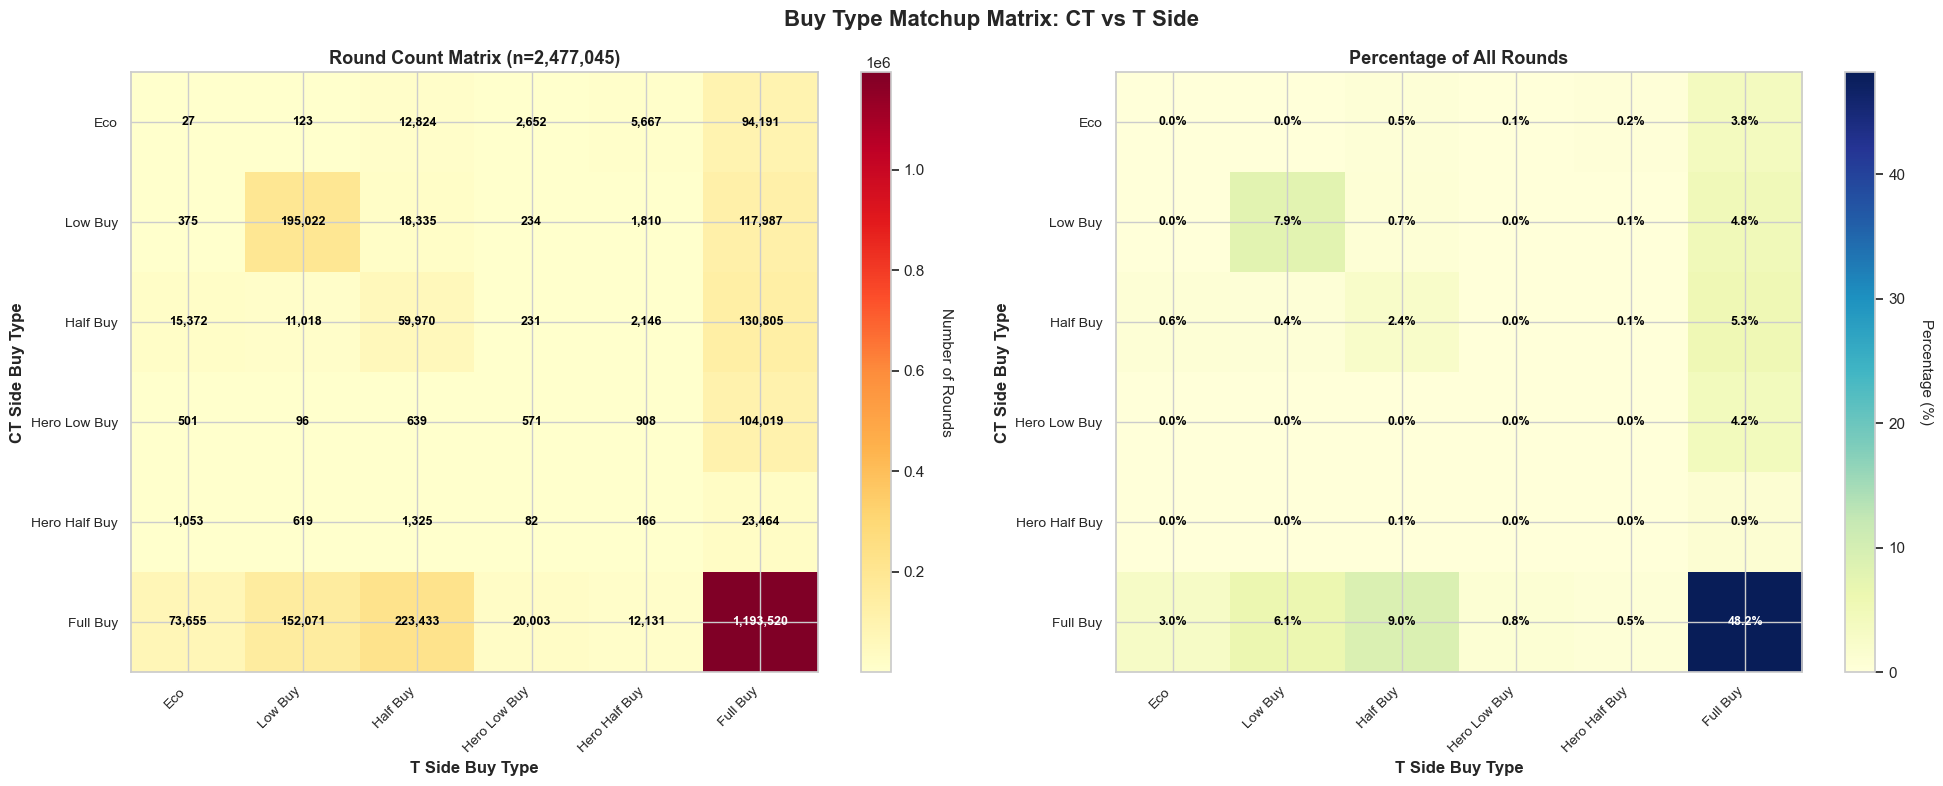

In [ ]:
# Create two-column visualization: Count matrix and Percentage matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Buy Type Matchup Matrix: CT vs T Side', fontsize=16, fontweight='bold')

# Left plot: Count Matrix Heatmap
count_matrix = matchup_matrix_ordered.iloc[:-1, :-1]
im1 = ax1.imshow(count_matrix.values, cmap='YlOrRd', aspect='auto')

# Set ticks and labels
ax1.set_xticks(range(len(count_matrix.columns)))
ax1.set_yticks(range(len(count_matrix.index)))
ax1.set_xticklabels(count_matrix.columns, rotation=45, ha='right', fontsize=10)
ax1.set_yticklabels(count_matrix.index, fontsize=10)

ax1.set_xlabel('T Side Buy Type', fontsize=12, fontweight='bold')
ax1.set_ylabel('CT Side Buy Type', fontsize=12, fontweight='bold')
ax1.set_title(f'Round Count Matrix (n={total_rounds:,.0f})', fontsize=13, fontweight='bold')

# Add text annotations for counts
for i in range(len(count_matrix.index)):
    for j in range(len(count_matrix.columns)):
        count = count_matrix.iloc[i, j]
        text_color = 'white' if count > count_matrix.values.max() * 0.5 else 'black'
        ax1.text(j, i, f'{int(count):,}',
                ha="center", va="center", color=text_color, fontsize=9, fontweight='bold')

# Add colorbar
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('Number of Rounds', rotation=270, labelpad=20, fontsize=11)

# Right plot: Percentage Matrix Heatmap
im2 = ax2.imshow(matchup_pct.values, cmap='YlGnBu', aspect='auto')

# Set ticks and labels
ax2.set_xticks(range(len(matchup_pct.columns)))
ax2.set_yticks(range(len(matchup_pct.index)))
ax2.set_xticklabels(matchup_pct.columns, rotation=45, ha='right', fontsize=10)
ax2.set_yticklabels(matchup_pct.index, fontsize=10)

ax2.set_xlabel('T Side Buy Type', fontsize=12, fontweight='bold')
ax2.set_ylabel('CT Side Buy Type', fontsize=12, fontweight='bold')
ax2.set_title('Percentage of All Rounds', fontsize=13, fontweight='bold')

# Add text annotations for percentages
for i in range(len(matchup_pct.index)):
    for j in range(len(matchup_pct.columns)):
        pct = matchup_pct.iloc[i, j]
        text_color = 'white' if pct > matchup_pct.values.max() * 0.5 else 'black'
        ax2.text(j, i, f'{pct:.1f}%',
                ha="center", va="center", color=text_color, fontsize=9, fontweight='bold')

# Add colorbar
cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('Percentage (%)', rotation=270, labelpad=20, fontsize=11)

plt.tight_layout()
plt.show()

In [ ]:
# Analyze win rates for each matchup combination
print("="*80)
print("WIN RATES BY BUY TYPE MATCHUP")
print("="*80)
print()

# Create a matrix showing CT win rate for each matchup
matchup_winrates = pd.crosstab(
    buy_type_df['ct_buy_type'],
    buy_type_df['t_buy_type'],
    values=buy_type_df['ct_winner'],
    aggfunc='mean'
) * 100

# Reindex to ensure consistent ordering
matchup_winrates = matchup_winrates.reindex(
    index=category_order,
    columns=category_order
).round(2)

print("CT Win Rate (%) by Matchup:")
print("-"*80)
print(matchup_winrates.to_string())
print()

# Find most common matchups
top_matchups = []
for i in range(len(count_matrix.index)):
    for j in range(len(count_matrix.columns)):
        ct_type = count_matrix.index[i]
        t_type = count_matrix.columns[j]
        count = count_matrix.iloc[i, j]
        if count > 0:
            pct = matchup_pct.iloc[i, j]
            ct_wr = matchup_winrates.loc[ct_type, t_type] if ct_type in matchup_winrates.index and t_type in matchup_winrates.columns else 0
            top_matchups.append({
                'CT Buy': ct_type,
                'T Buy': t_type,
                'Rounds': int(count),
                'Pct of Total': pct,
                'CT Win %': ct_wr
            })

top_matchups_df = pd.DataFrame(top_matchups).sort_values('Rounds', ascending=False).head(10)

print("Top 10 Most Common Matchups:")
print("-"*80)
print(top_matchups_df.to_string(index=False))
print()

WIN RATES BY BUY TYPE MATCHUP

CT Win Rate (%) by Matchup:
--------------------------------------------------------------------------------
t_buy_type       Eco  Low Buy  Half Buy  Hero Low Buy  Hero Half Buy  Full Buy
ct_buy_type                                                                   
Eco            51.85    61.79      2.92          3.09           3.92      4.05
Low Buy        48.53    51.11     19.55          6.41          11.66     13.84
Half Buy       97.34    80.77     36.82         46.32          31.03     29.79
Hero Low Buy   95.61    90.62     21.44         15.24          14.10     21.86
Hero Half Buy  97.06    85.78     55.02         74.39          37.95     35.74
Full Buy       96.52    87.85     71.37         76.04          65.62     53.30

Top 10 Most Common Matchups:
--------------------------------------------------------------------------------
      CT Buy    T Buy  Rounds  Pct of Total  CT Win %
    Full Buy Full Buy 1193520         48.18     53.30
    Full 

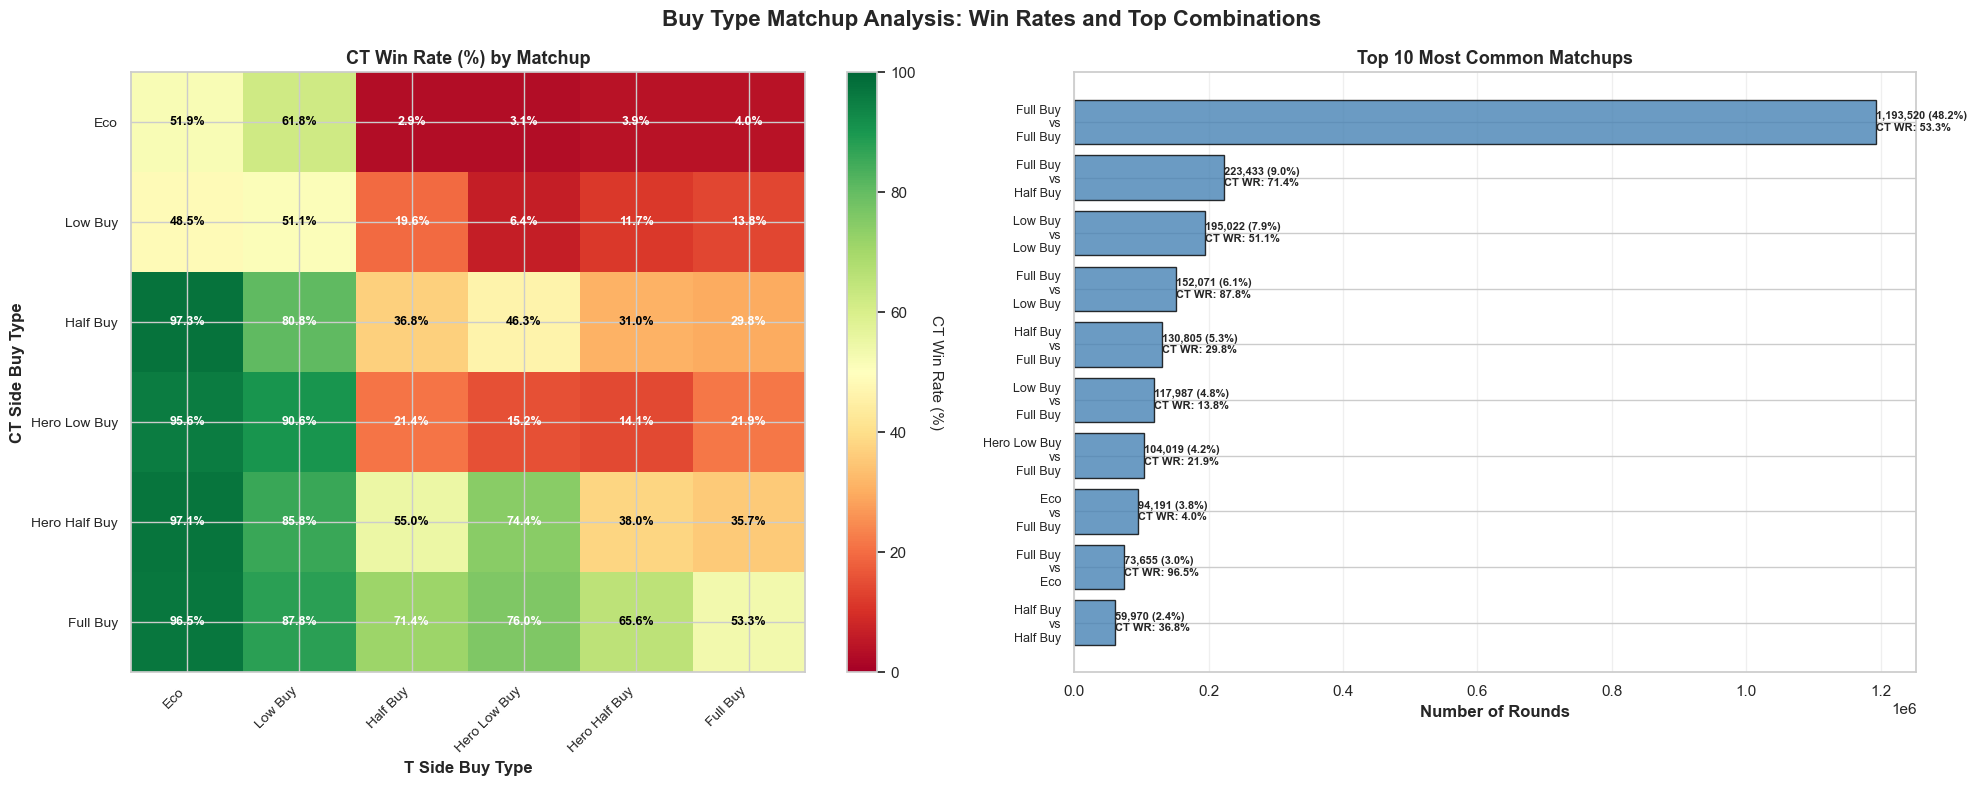

In [ ]:
# Create two-column visualization: Win rate heatmap and Top matchups bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Buy Type Matchup Analysis: Win Rates and Top Combinations', fontsize=16, fontweight='bold')

# Left plot: CT Win Rate Heatmap
im = ax1.imshow(matchup_winrates.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)

# Set ticks and labels
ax1.set_xticks(range(len(matchup_winrates.columns)))
ax1.set_yticks(range(len(matchup_winrates.index)))
ax1.set_xticklabels(matchup_winrates.columns, rotation=45, ha='right', fontsize=10)
ax1.set_yticklabels(matchup_winrates.index, fontsize=10)

ax1.set_xlabel('T Side Buy Type', fontsize=12, fontweight='bold')
ax1.set_ylabel('CT Side Buy Type', fontsize=12, fontweight='bold')
ax1.set_title('CT Win Rate (%) by Matchup', fontsize=13, fontweight='bold')

# Add text annotations
for i in range(len(matchup_winrates.index)):
    for j in range(len(matchup_winrates.columns)):
        win_rate = matchup_winrates.iloc[i, j]
        if not pd.isna(win_rate):
            text_color = 'white' if win_rate < 30 or win_rate > 70 else 'black'
            ax1.text(j, i, f'{win_rate:.1f}%',
                    ha="center", va="center", color=text_color, fontsize=9, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label('CT Win Rate (%)', rotation=270, labelpad=20, fontsize=11)

# Right plot: Top 10 Matchups Bar Chart
matchup_labels = [f"{row['CT Buy']}\nvs\n{row['T Buy']}" 
                  for _, row in top_matchups_df.iterrows()]
matchup_counts = top_matchups_df['Rounds'].values

bars = ax2.barh(range(len(matchup_labels)), matchup_counts, 
                color='steelblue', alpha=0.8, edgecolor='black')

ax2.set_yticks(range(len(matchup_labels)))
ax2.set_yticklabels(matchup_labels, fontsize=9)
ax2.set_xlabel('Number of Rounds', fontsize=12, fontweight='bold')
ax2.set_title('Top 10 Most Common Matchups', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
ax2.invert_yaxis()

# Add value labels on bars
for i, (bar, row) in enumerate(zip(bars, top_matchups_df.itertuples())):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2.,
            f'{int(width):,} ({row._4:.1f}%)\nCT WR: {row._5:.1f}%',
            ha='left', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

### Game Outcome Prediction Models

Predicting game outcome P(Yg|Rg,i) based on round information:
- Features: Current scores, score difference, equipment values, money, and buy types
- Target: Game winner (CT = 1, T = 0)
- Models: Logistic Regression and XGBoost

In [ ]:
print("="*80)
print("PREPARING GAME OUTCOME PREDICTION DATASET")
print("="*80)
print()

# Import additional libraries for modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

import xgboost as xgb

# Create modeling dataset from buy_type_df
model_df = buy_type_df.copy()

# Determine game winner (CT = 1, T = 0)
# Get the final round of each game to determine winner from final scores
game_winners = model_df.groupby('id_demo_exports').last().reset_index()

# Calculate game winner based on final scores
# If is_ct_t1 == 1, then t1 is CT, so CT wins if t1_score_end > t2_score_end
# If is_ct_t1 == 0, then t2 is CT, so CT wins if t2_score_end > t1_score_end
game_winners['ct_wins_game'] = (
    ((game_winners['is_ct_t1'] == 1) & (game_winners['t1_score_end'] > game_winners['t2_score_end'])) | 
    ((game_winners['is_ct_t1'] == 0) & (game_winners['t2_score_end'] > game_winners['t1_score_end']))
).astype(int)

# Merge back to model_df
model_df = model_df.merge(
    game_winners[['id_demo_exports', 'ct_wins_game']], 
    on='id_demo_exports', 
    how='left'
)

print(f"Total rounds in modeling dataset: {len(model_df):,}")
print(f"Total unique games: {model_df['id_demo_exports'].nunique():,}")
print()

# Check game outcome distribution
game_outcome_dist = model_df.groupby('id_demo_exports')['ct_wins_game'].first().value_counts()
print("Game Outcome Distribution:")
print(f"  CT Wins: {game_outcome_dist.get(1, 0):,} ({game_outcome_dist.get(1, 0) / game_outcome_dist.sum() * 100:.1f}%)")
print(f"  T Wins:  {game_outcome_dist.get(0, 0):,} ({game_outcome_dist.get(0, 0) / game_outcome_dist.sum() * 100:.1f}%)")
print()

PREPARING GAME OUTCOME PREDICTION DATASET

Total rounds in modeling dataset: 2,477,045
Total unique games: 98,933

Game Outcome Distribution:
  CT Wins: 49,799 (50.3%)
  T Wins:  49,134 (49.7%)



In [ ]:
# Calculate current scores at the start of each round
# t1_score_start and t2_score_start are the scores at the beginning of the round
model_df['ct_score_start'] = model_df.apply(
    lambda row: row['t1_score_start'] if row['is_ct_t1'] else row['t2_score_start'], 
    axis=1
)
model_df['t_score_start'] = model_df.apply(
    lambda row: row['t2_score_start'] if row['is_ct_t1'] else row['t1_score_start'], 
    axis=1
)

# Score difference (CT - T)
model_df['score_diff'] = model_df['ct_score_start'] - model_df['t_score_start']

# Encode buy types as numeric categories
le_ct = LabelEncoder()
le_t = LabelEncoder()

model_df['ct_buy_encoded'] = le_ct.fit_transform(model_df['ct_buy_type'].fillna('Unknown'))
model_df['t_buy_encoded'] = le_t.fit_transform(model_df['t_buy_type'].fillna('Unknown'))

print("Feature Engineering Complete:")
print(f"  - CT Buy Type Categories: {list(le_ct.classes_)}")
print(f"  - T Buy Type Categories: {list(le_t.classes_)}")
print()

# Select features for modeling
feature_cols = [
    'ct_score_start',           # CT current score
    't_score_start',            # T current score
    'score_diff',               # Score difference (CT - T)
    'ct_starting_equipment',    # CT starting equipment value
    't_starting_equipment',     # T starting equipment value
    'ct_money_start',           # CT starting money
    't_money_start',            # T starting money
    'ct_buy_encoded',           # CT buy type (encoded)
    't_buy_encoded'             # T buy type (encoded)
]

# Remove rows with missing values in features
model_df_clean = model_df[feature_cols + ['ct_wins_game', 'id_demo_exports']].dropna()

print(f"Clean modeling dataset: {len(model_df_clean):,} rounds")
print(f"Games represented: {model_df_clean['id_demo_exports'].nunique():,}")
print()

print("Feature Summary:")
print("-"*80)
for col in feature_cols:
    print(f"  {col:30s}: Mean={model_df_clean[col].mean():>10.2f}, Std={model_df_clean[col].std():>10.2f}")
print()

Feature Engineering Complete:
  - CT Buy Type Categories: ['Eco', 'Full Buy', 'Half Buy', 'Hero Half Buy', 'Hero Low Buy', 'Low Buy']
  - T Buy Type Categories: ['Eco', 'Full Buy', 'Half Buy', 'Hero Half Buy', 'Hero Low Buy', 'Low Buy']

Clean modeling dataset: 2,468,684 rounds
Games represented: 98,914

Feature Summary:
--------------------------------------------------------------------------------
  ct_score_start                : Mean=      6.48, Std=      4.67
  t_score_start                 : Mean=      6.52, Std=      4.71
  score_diff                    : Mean=     -0.04, Std=      4.39
  ct_starting_equipment         : Mean=   8791.88, Std=   8395.47
  t_starting_equipment          : Mean=   6643.07, Std=   7434.80
  ct_money_start                : Mean=  22221.68, Std=  11482.95
  t_money_start                 : Mean=  23933.40, Std=  12302.99
  ct_buy_encoded                : Mean=      1.73, Std=      1.48
  t_buy_encoded                 : Mean=      1.72, Std=      1.45



In [ ]:
# Split data into training and testing sets
# Use stratified split to maintain game outcome balance
X = model_df_clean[feature_cols]
y = model_df_clean['ct_wins_game']

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("="*80)
print("TRAIN/TEST SPLIT")
print("="*80)
print()
print(f"Training set: {len(X_train):,} rounds")
print(f"  CT Wins: {y_train.sum():,} ({y_train.mean()*100:.1f}%)")
print(f"  T Wins:  {(~y_train.astype(bool)).sum():,} ({(1-y_train.mean())*100:.1f}%)")
print()
print(f"Test set: {len(X_test):,} rounds")
print(f"  CT Wins: {y_test.sum():,} ({y_test.mean()*100:.1f}%)")
print(f"  T Wins:  {(~y_test.astype(bool)).sum():,} ({(1-y_test.mean())*100:.1f}%)")
print()

TRAIN/TEST SPLIT

Training set: 1,974,947 rounds
  CT Wins: 999,233 (50.6%)
  T Wins:  975,714 (49.4%)

Test set: 493,737 rounds
  CT Wins: 249,808 (50.6%)
  T Wins:  243,929 (49.4%)



In [ ]:
print("="*80)
print("MODEL 1: LOGISTIC REGRESSION")
print("="*80)
print()

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Evaluate
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, y_pred_proba_lr)

print("Performance Metrics:")
print(f"  Accuracy: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"  ROC AUC:  {lr_auc:.4f}")
print()

print("Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['T Wins', 'CT Wins']))
print()

print("Confusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(cm_lr)
print()

# Feature importance (coefficients)
feature_importance_lr = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("Feature Importance (Top 5 by absolute coefficient):")
print(feature_importance_lr.head().to_string(index=False))
print()

MODEL 1: LOGISTIC REGRESSION

Performance Metrics:
  Accuracy: 0.5778 (57.78%)
  ROC AUC:  0.6100

Classification Report:
              precision    recall  f1-score   support

      T Wins       0.58      0.53      0.55    243929
     CT Wins       0.58      0.62      0.60    249808

    accuracy                           0.58    493737
   macro avg       0.58      0.58      0.58    493737
weighted avg       0.58      0.58      0.58    493737


Confusion Matrix:
[[129345 114584]
 [ 93880 155928]]

Feature Importance (Top 5 by absolute coefficient):
       Feature  Coefficient
    score_diff     0.051867
ct_score_start     0.027532
 t_score_start    -0.024335
 t_buy_encoded     0.023376
ct_buy_encoded     0.002071



In [ ]:
print("="*80)
print("MODEL 2: XGBOOST")
print("="*80)
print()

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_auc = roc_auc_score(y_test, y_pred_proba_xgb)

print("Performance Metrics:")
print(f"  Accuracy: {xgb_accuracy:.4f} ({xgb_accuracy*100:.2f}%)")
print(f"  ROC AUC:  {xgb_auc:.4f}")
print()

print("Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['T Wins', 'CT Wins']))
print()

print("Confusion Matrix:")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(cm_xgb)
print()

# Feature importance
feature_importance_xgb = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance (Top 5):")
print(feature_importance_xgb.head().to_string(index=False))
print()

MODEL 2: XGBOOST

Performance Metrics:
  Accuracy: 0.7324 (73.24%)
  ROC AUC:  0.8188

Classification Report:
              precision    recall  f1-score   support

      T Wins       0.74      0.70      0.72    243929
     CT Wins       0.72      0.76      0.74    249808

    accuracy                           0.73    493737
   macro avg       0.73      0.73      0.73    493737
weighted avg       0.73      0.73      0.73    493737


Confusion Matrix:
[[171490  72439]
 [ 59684 190124]]

Feature Importance (Top 5):
       Feature  Importance
    score_diff    0.336241
 t_score_start    0.276480
ct_score_start    0.213811
ct_money_start    0.058641
 t_money_start    0.051791



In [ ]:
from sklearn.metrics import log_loss

# Calculate log-loss for both models
lr_logloss = log_loss(y_test, y_pred_proba_lr)
xgb_logloss = log_loss(y_test, y_pred_proba_xgb)

print("="*80)
print("MODEL COMPARISON")
print("="*80)
print()

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'ROC AUC', 'Log-Loss'],
    'Logistic Regression': [lr_accuracy, lr_auc, lr_logloss],
    'XGBoost': [xgb_accuracy, xgb_auc, xgb_logloss]
})

print(comparison_df.to_string(index=False))
print()

print("Note: For Log-Loss, LOWER is better (it measures prediction error)")
print(f"  LR Log-Loss:  {lr_logloss:.4f}")
print(f"  XGB Log-Loss: {xgb_logloss:.4f}")
print()

# Determine better model
if xgb_accuracy > lr_accuracy and xgb_logloss < lr_logloss:
    print(f"✅ XGBoost performs better on all metrics")
elif lr_accuracy > xgb_accuracy and lr_logloss < xgb_logloss:
    print(f"✅ Logistic Regression performs better on all metrics")
else:
    print("⚖️ Mixed results - different models excel at different metrics")
print()

MODEL COMPARISON

  Metric  Logistic Regression  XGBoost
Accuracy             0.577783 0.732402
 ROC AUC             0.609971 0.818768
Log-Loss             0.673769 0.514475

Note: For Log-Loss, LOWER is better (it measures prediction error)
  LR Log-Loss:  0.6738
  XGB Log-Loss: 0.5145

✅ XGBoost performs better on all metrics



## Understanding Log-Loss (Cross-Entropy Loss)

**Mathematical Definition:**

Log-loss for multi-class classification is defined as:

$$\text{Log-Loss} = -\frac{1}{N} \sum_{i=0}^{N-1} \sum_{k=0}^{K-1} y_{i,k} \log(p_{i,k})$$

Where:
- $N$ = number of samples
- $K$ = number of classes
- $y_{i,k}$ = 1 if sample $i$ belongs to class $k$, 0 otherwise
- $p_{i,k}$ = predicted probability that sample $i$ belongs to class $k$

**For Binary Classification (K=2):**

This simplifies to:

$$\text{Log-Loss} = -\frac{1}{N} \sum_{i=0}^{N-1} [y_i \log(p_i) + (1-y_i) \log(1-p_i)]$$

**Why Use Log-Loss:**

1. **Probabilistic Assessment**: Unlike accuracy (which only checks if prediction is correct), log-loss evaluates the **quality of predicted probabilities**
2. **Penalizes Confidence**: A confident but wrong prediction (e.g., predicting 95% probability for the wrong class) is heavily penalized
3. **Differentiable**: Smooth gradient allows for effective optimization during training
4. **Information Theory**: Measures the "surprise" or information loss - lower values mean less surprise/better predictions

**Interpretation:**
- **Lower is better**: 0 = perfect predictions, higher values = worse predictions
- Log-loss of 0.693 ≈ random guessing for binary classification
- Heavily penalizes predictions that are both wrong and confident

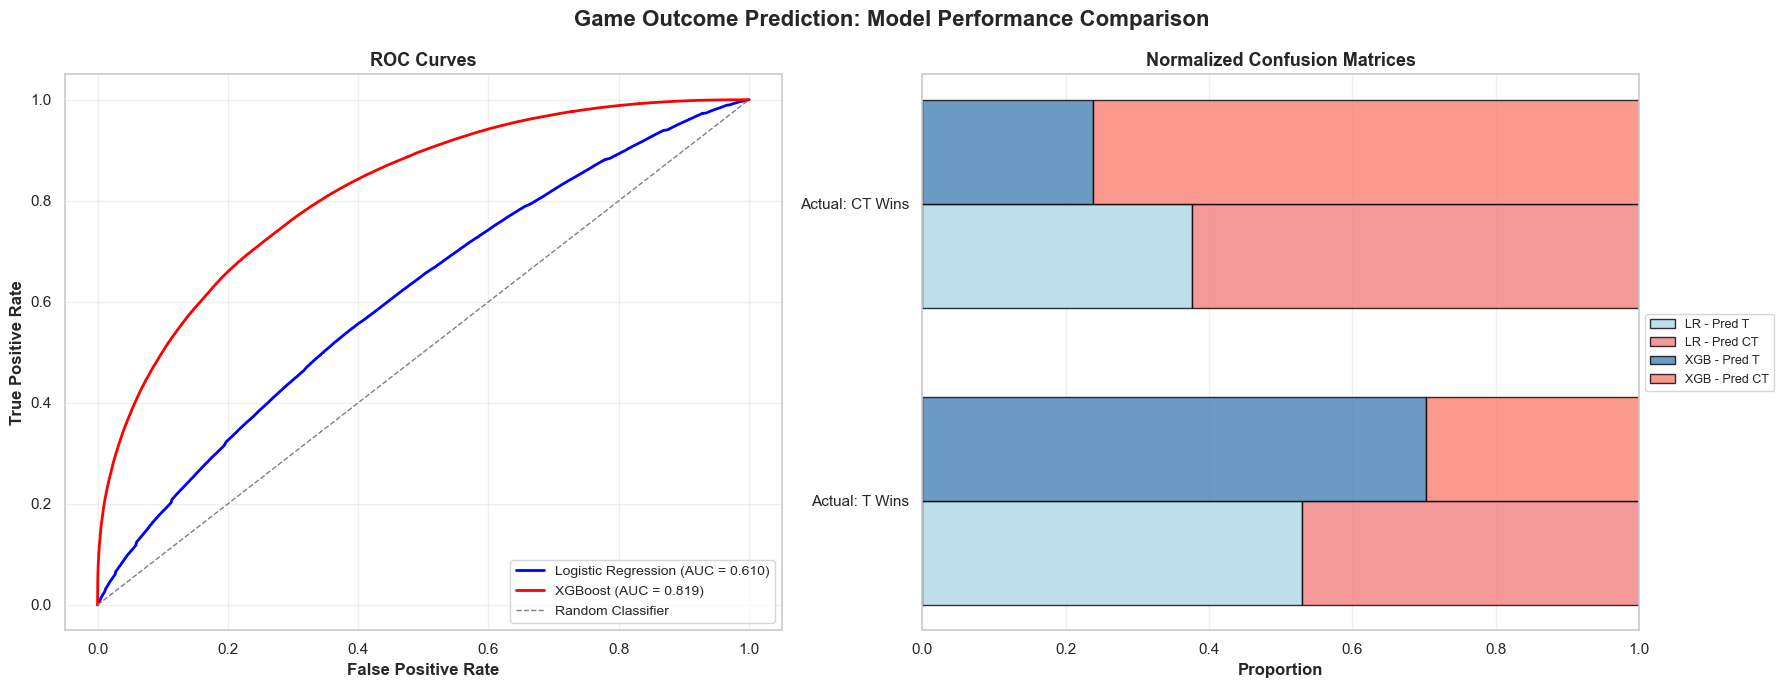

In [ ]:
# Create two-column visualization: ROC Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Game Outcome Prediction: Model Performance Comparison', fontsize=16, fontweight='bold')

# Left plot: ROC Curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

ax1.plot(fpr_lr, tpr_lr, color='blue', lw=2, 
         label=f'Logistic Regression (AUC = {lr_auc:.3f})')
ax1.plot(fpr_xgb, tpr_xgb, color='red', lw=2, 
         label=f'XGBoost (AUC = {xgb_auc:.3f})')
ax1.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')

ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax1.set_title('ROC Curves', fontsize=13, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Right plot: Confusion Matrices
# Normalize confusion matrices
cm_lr_norm = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, np.newaxis]
cm_xgb_norm = cm_xgb.astype('float') / cm_xgb.sum(axis=1)[:, np.newaxis]

# Create side-by-side confusion matrices
x_pos = np.arange(2)
width = 0.35

# Plot for each class (T Wins, CT Wins)
for i, class_name in enumerate(['T Wins', 'CT Wins']):
    lr_vals = cm_lr_norm[i, :]
    xgb_vals = cm_xgb_norm[i, :]
    
    ax2.barh(i - width/2, lr_vals[0], width, label='LR - Pred T' if i == 0 else '', 
             color='lightblue', alpha=0.8, edgecolor='black')
    ax2.barh(i - width/2, lr_vals[1], width, left=lr_vals[0], 
             label='LR - Pred CT' if i == 0 else '', 
             color='lightcoral', alpha=0.8, edgecolor='black')
    
    ax2.barh(i + width/2, xgb_vals[0], width, label='XGB - Pred T' if i == 0 else '', 
             color='steelblue', alpha=0.8, edgecolor='black')
    ax2.barh(i + width/2, xgb_vals[1], width, left=xgb_vals[0], 
             label='XGB - Pred CT' if i == 0 else '', 
             color='salmon', alpha=0.8, edgecolor='black')

ax2.set_yticks([0, 1])
ax2.set_yticklabels(['Actual: T Wins', 'Actual: CT Wins'])
ax2.set_xlabel('Proportion', fontsize=12, fontweight='bold')
ax2.set_title('Normalized Confusion Matrices', fontsize=13, fontweight='bold')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
ax2.grid(True, alpha=0.3, axis='x')
ax2.set_xlim([0, 1])

plt.tight_layout()
plt.show()

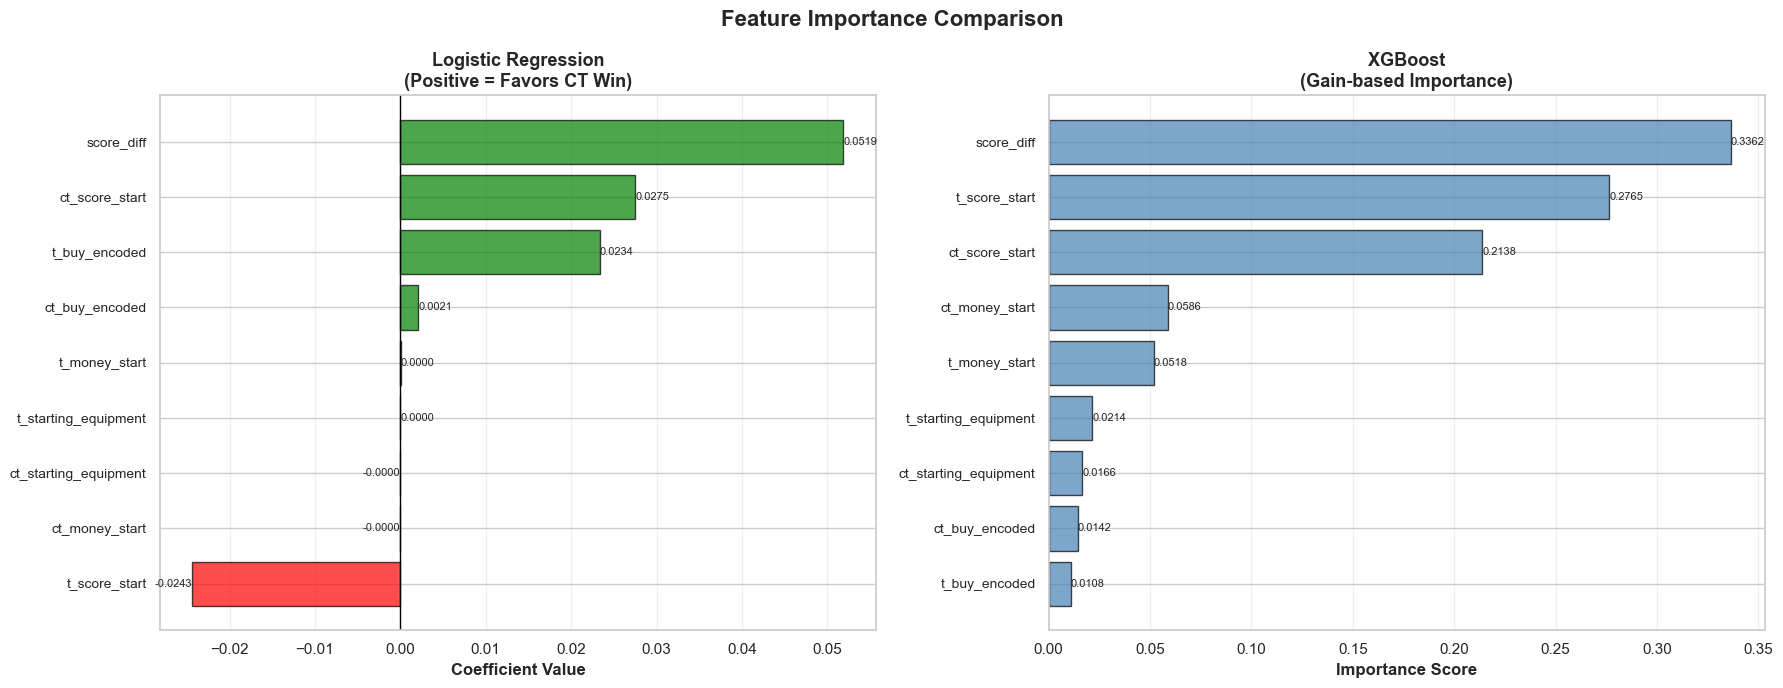

In [ ]:
# Create two-column visualization: Feature Importance Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Feature Importance Comparison', fontsize=16, fontweight='bold')

# Left plot: Logistic Regression Coefficients
feature_importance_lr_sorted = feature_importance_lr.sort_values('Coefficient')
colors_lr = ['red' if x < 0 else 'green' for x in feature_importance_lr_sorted['Coefficient']]

ax1.barh(range(len(feature_importance_lr_sorted)), 
         feature_importance_lr_sorted['Coefficient'],
         color=colors_lr, alpha=0.7, edgecolor='black')

ax1.set_yticks(range(len(feature_importance_lr_sorted)))
ax1.set_yticklabels(feature_importance_lr_sorted['Feature'], fontsize=10)
ax1.set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
ax1.set_title('Logistic Regression\n(Positive = Favors CT Win)', fontsize=13, fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(feature_importance_lr_sorted.iterrows()):
    val = row['Coefficient']
    ax1.text(val, i, f'{val:.4f}', 
            ha='left' if val > 0 else 'right', va='center', fontsize=8)

# Right plot: XGBoost Feature Importance
feature_importance_xgb_sorted = feature_importance_xgb.sort_values('Importance')

ax2.barh(range(len(feature_importance_xgb_sorted)), 
         feature_importance_xgb_sorted['Importance'],
         color='steelblue', alpha=0.7, edgecolor='black')

ax2.set_yticks(range(len(feature_importance_xgb_sorted)))
ax2.set_yticklabels(feature_importance_xgb_sorted['Feature'], fontsize=10)
ax2.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax2.set_title('XGBoost\n(Gain-based Importance)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (idx, row) in enumerate(feature_importance_xgb_sorted.iterrows()):
    val = row['Importance']
    ax2.text(val, i, f'{val:.4f}', 
            ha='left', va='center', fontsize=8)

plt.tight_layout()
plt.show()

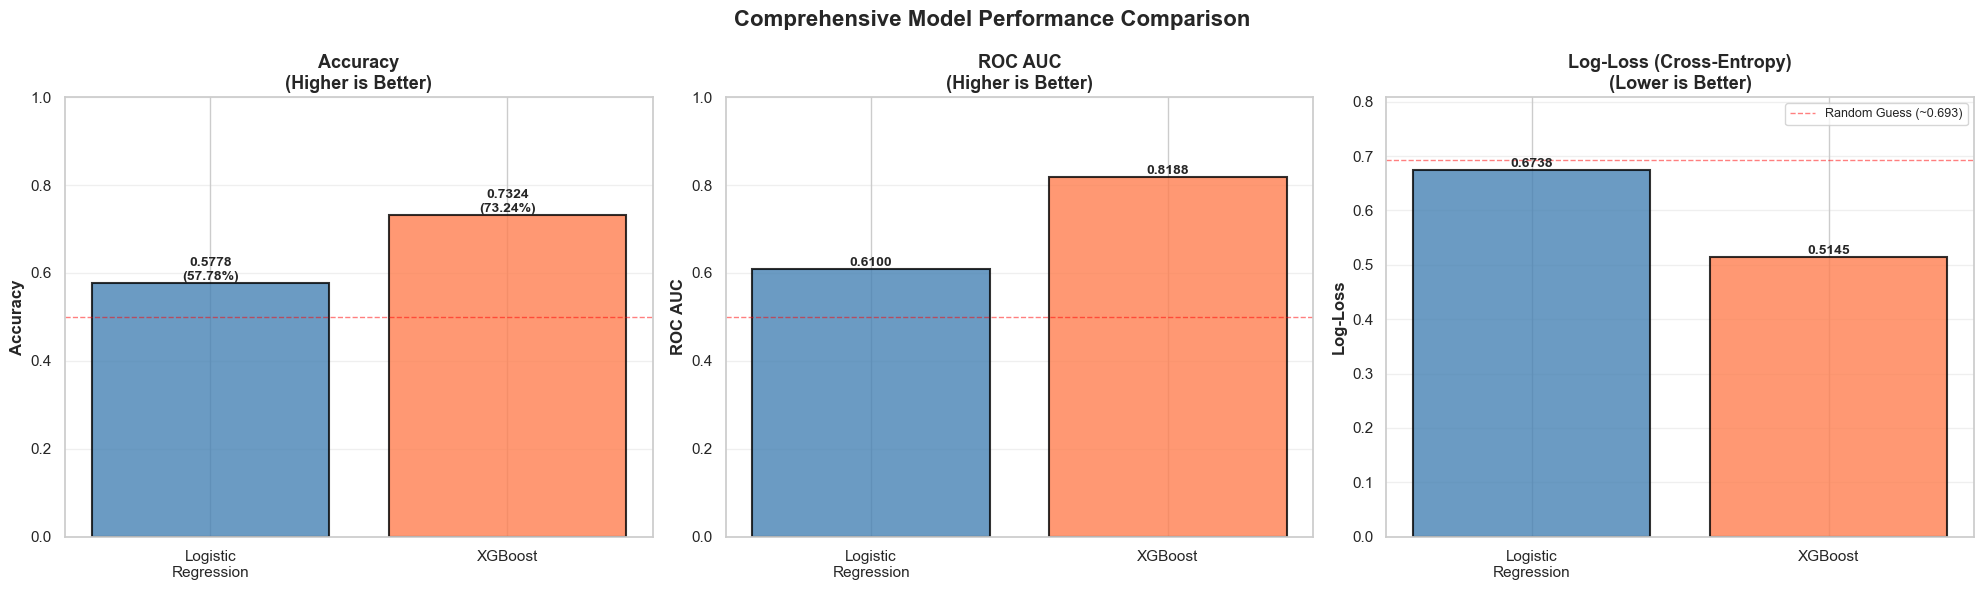


INTERPRETATION

Accuracy: Both models significantly outperform random guessing (50%)
  - Logistic Regression: 57.78%
  - XGBoost: 73.24%

ROC AUC: Measures ability to discriminate between classes across all thresholds
  - Logistic Regression: 0.6100
  - XGBoost: 0.8188
  - Both substantially better than random (0.5)

Log-Loss: Penalizes confident wrong predictions (lower is better)
  - Logistic Regression: 0.6738
  - XGBoost: 0.5145
  - Random baseline: ~0.693
  - Both models show good probability calibration (well below random baseline)



In [ ]:
# Create comprehensive model comparison visualization including log-loss
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Comprehensive Model Performance Comparison', fontsize=16, fontweight='bold')

models = ['Logistic\nRegression', 'XGBoost']
accuracies = [lr_accuracy, xgb_accuracy]
aucs = [lr_auc, xgb_auc]
loglosses = [lr_logloss, xgb_logloss]

# Plot 1: Accuracy
ax1 = axes[0]
bars1 = ax1.bar(models, accuracies, color=['steelblue', 'coral'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Accuracy\n(Higher is Better)', fontsize=13, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Random Guess')
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}\n({height*100:.2f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

# Plot 2: ROC AUC
ax2 = axes[1]
bars2 = ax2.bar(models, aucs, color=['steelblue', 'coral'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('ROC AUC', fontsize=12, fontweight='bold')
ax2.set_title('ROC AUC\n(Higher is Better)', fontsize=13, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Random Guess')
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

# Plot 3: Log-Loss (LOWER IS BETTER)
ax3 = axes[2]
bars3 = ax3.bar(models, loglosses, color=['steelblue', 'coral'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Log-Loss', fontsize=12, fontweight='bold')
ax3.set_title('Log-Loss (Cross-Entropy)\n(Lower is Better)', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
ax3.axhline(y=0.693, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Random Guess (~0.693)')
ax3.legend(fontsize=9)

# Set y-limit to show data clearly
max_logloss = max(loglosses)
ax3.set_ylim([0, max_logloss * 1.2])

for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
print(f"""
Accuracy: Both models significantly outperform random guessing (50%)
  - Logistic Regression: {lr_accuracy*100:.2f}%
  - XGBoost: {xgb_accuracy*100:.2f}%

ROC AUC: Measures ability to discriminate between classes across all thresholds
  - Logistic Regression: {lr_auc:.4f}
  - XGBoost: {xgb_auc:.4f}
  - Both substantially better than random (0.5)

Log-Loss: Penalizes confident wrong predictions (lower is better)
  - Logistic Regression: {lr_logloss:.4f}
  - XGBoost: {xgb_logloss:.4f}
  - Random baseline: ~0.693
  - Both models show good probability calibration (well below random baseline)
""")

## Model Export for ABM Integration

Export both trained models in JSON format for use in Agent-Based Model simulations.

In [ ]:
import json
import os
from datetime import datetime

print("="*80)
print("EXPORTING MODELS FOR ABM")
print("="*80)
print()

# Create export directory
export_dir = "go_models_game_outcome"
os.makedirs(export_dir, exist_ok=True)

# ============================================================================
# 1. EXPORT LOGISTIC REGRESSION MODEL
# ============================================================================

lr_export = {
    "model_type": "logistic_regression",
    "model_name": "Game Outcome Prediction - Logistic Regression",
    "description": "Predicts P(CT wins game | game state at round i)",
    "created_at": datetime.now().isoformat(),
    
    # Model parameters
    "coefficients": lr_model.coef_[0].tolist(),
    "intercept": float(lr_model.intercept_[0]),
    "classes": lr_model.classes_.tolist(),
    
    # Feature information
    "features": feature_cols,
    "feature_count": len(feature_cols),
    
    # Label encoders for buy types
    "ct_buy_encoder": {
        "classes": le_ct.classes_.tolist(),
        "mapping": {str(i): cls for i, cls in enumerate(le_ct.classes_)}
    },
    "t_buy_encoder": {
        "classes": le_t.classes_.tolist(),
        "mapping": {str(i): cls for i, cls in enumerate(le_t.classes_)}
    },
    
    # Performance metrics
    "performance": {
        "accuracy": float(lr_accuracy),
        "roc_auc": float(lr_auc),
        "log_loss": float(lr_logloss),
        "test_set_size": len(y_test)
    },
    
    # Feature importance (absolute coefficient values)
    "feature_importance": {
        feat: float(abs(coef)) 
        for feat, coef in zip(feature_cols, lr_model.coef_[0])
    }
}

# Save Logistic Regression model
lr_path = os.path.join(export_dir, "logistic_regression_model.json")
with open(lr_path, 'w') as f:
    json.dump(lr_export, f, indent=2)

print(f"✅ Logistic Regression model exported to: {lr_path}")
print(f"   - Coefficients: {len(lr_model.coef_[0])}")
print(f"   - Intercept: {lr_model.intercept_[0]:.4f}")
print(f"   - Accuracy: {lr_accuracy:.4f}")
print()

# ============================================================================
# 2. EXPORT XGBOOST MODEL
# ============================================================================

# Export XGBoost model in its native JSON format
xgb_native_path = os.path.join(export_dir, "xen_xgboost_model.json")
xgb_model.save_model(xgb_native_path)

# Also create a metadata file with additional information
xgb_export = {
    "model_type": "xgboost",
    "model_name": "Game Outcome Prediction - XGBoost",
    "description": "Predicts P(CT wins game | game state at round i)",
    "created_at": datetime.now().isoformat(),
    
    # Model file reference
    "model_file": "xen_xgboost_model.json",
    
    # Model parameters
    "n_estimators": int(xgb_model.n_estimators),
    "max_depth": int(xgb_model.max_depth),
    "learning_rate": float(xgb_model.learning_rate),
    
    # Feature information
    "features": feature_cols,
    "feature_count": len(feature_cols),
    
    # Label encoders for buy types
    "ct_buy_encoder": {
        "classes": le_ct.classes_.tolist(),
        "mapping": {str(i): cls for i, cls in enumerate(le_ct.classes_)}
    },
    "t_buy_encoder": {
        "classes": le_t.classes_.tolist(),
        "mapping": {str(i): cls for i, cls in enumerate(le_t.classes_)}
    },
    
    # Performance metrics
    "performance": {
        "accuracy": float(xgb_accuracy),
        "roc_auc": float(xgb_auc),
        "log_loss": float(xgb_logloss),
        "test_set_size": len(y_test)
    },
    
    # Feature importance
    "feature_importance": {
        feat: float(imp) 
        for feat, imp in zip(feature_cols, xgb_model.feature_importances_)
    }
}

# Save XGBoost metadata
xgb_meta_path = os.path.join(export_dir, "xen_xgboost_metadata.json")
with open(xgb_meta_path, 'w') as f:
    json.dump(xgb_export, f, indent=2)

print(f"✅ XGBoost model exported to: {xgb_native_path}")
print(f"✅ XGBoost metadata exported to: {xgb_meta_path}")
print(f"   - Trees: {xgb_model.n_estimators}")
print(f"   - Max depth: {xgb_model.max_depth}")
print(f"   - Accuracy: {xgb_accuracy:.4f}")
print()


EXPORTING MODELS FOR ABM

✅ Logistic Regression model exported to: go_models_game_outcome\logistic_regression_model.json
   - Coefficients: 9
   - Intercept: -0.1306
   - Accuracy: 0.5778

✅ XGBoost model exported to: go_models_game_outcome\xen_xgboost_model.json
✅ XGBoost metadata exported to: go_models_game_outcome\xen_xgboost_metadata.json
   - Trees: 100
   - Max depth: 6
   - Accuracy: 0.7324

